In [24]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_openml
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.optimize as sopt
import seaborn as sns
import torch
from scipy.special import expit
# TensorFlow and tf.keras
import tensorflow as tf
import cv2
from skimage.transform import downscale_local_mean

In [25]:
# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, as_frame=True)

In [26]:
# Generate and preprocess data
X = np.array(mnist.data, dtype=np.float32)/255.0  # Convert to float
y = np.array(mnist.target, dtype=np.int32)  # Convert to integer (labels)

print(X.shape)
print(y)

(70000, 784)
[5 0 4 ... 4 5 6]


In [27]:
# plot gaussian sample for each digit after estimating mean and std dev
def plot_gaussian_sample(X, y, digit):
    X_digit = X[y == digit]
    y_digit = y[y == digit]
    mean = np.mean(X_digit, axis=0)
    std = np.std(X_digit, axis=0)
    sample = np.random.normal(mean, std, (1, X_digit.shape[1]))
    return sample

In [28]:
def plot_fn(X, digit):
    # X is an array of images
    length = len(X)
    idx = np.random.randint(0, 5000)
    plt.figure(figsize=(12, 6))
    for i in range(length):
        plt.subplot(1, length, i+1)
        image = X[i][y==digit][idx]
        plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

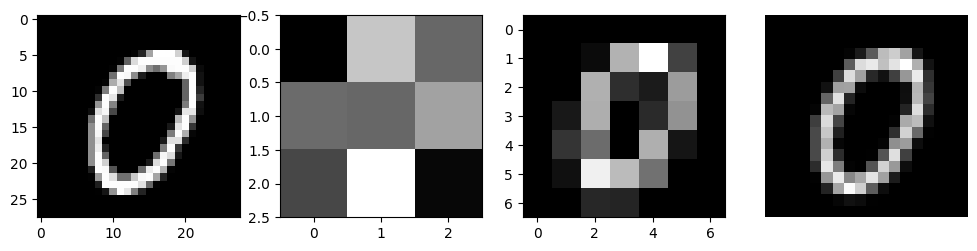

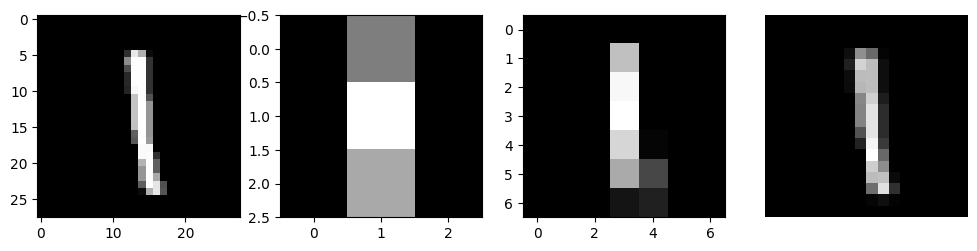

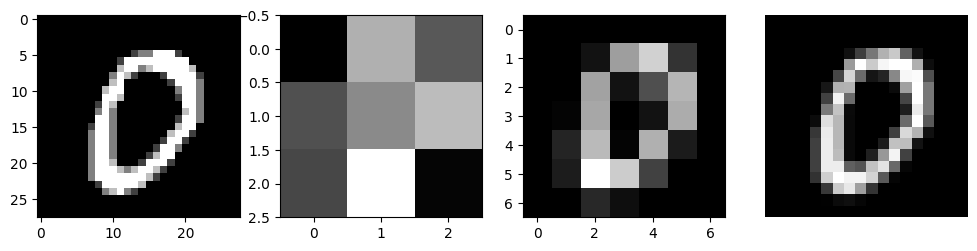

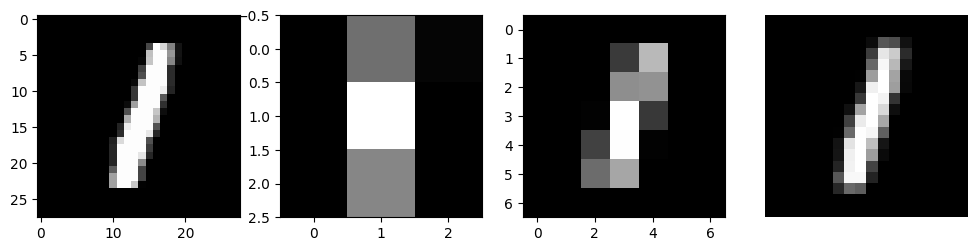

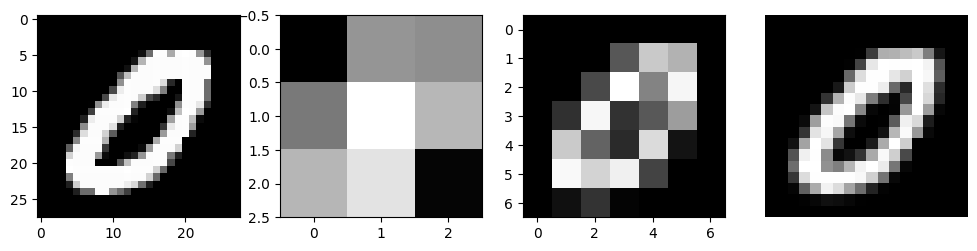

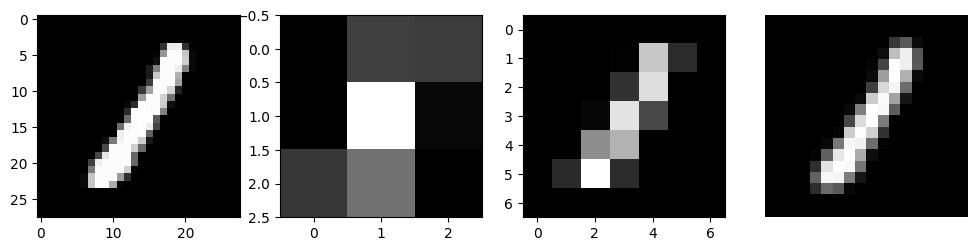

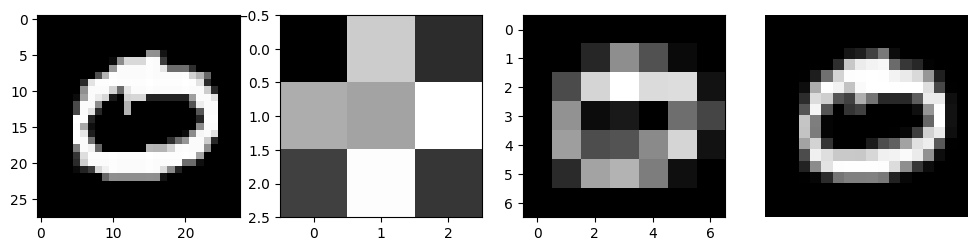

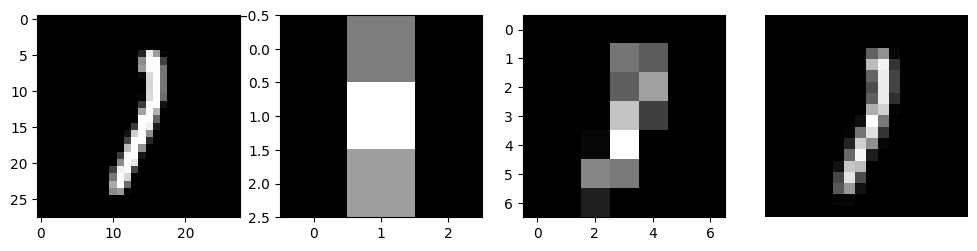

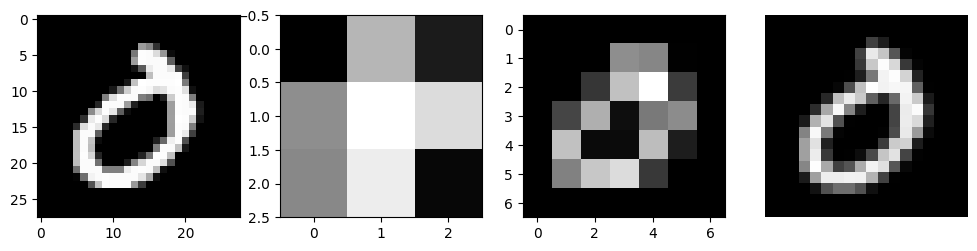

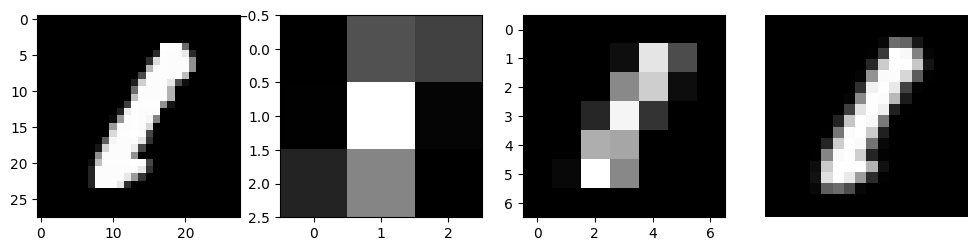

In [29]:
# subsampling the data by picking every 4th pixel
new_shape = (3, 3)
new_shape_2 = (7, 7)
new_shape_3 = (18, 18)

# reshape x to 28x28
X = X.reshape(-1, 28, 28)

# subsample the data every 2nd pixel
# X_subsampled = X[:, ::step, ::step].reshape(X.shape[0], int(X.shape[1]/step), -1)
X_subsampled = np.array([cv2.resize(X[i], new_shape, interpolation = cv2.INTER_AREA) for i in range(len(X))])
X_subsampled_2 = np.array([cv2.resize(X[i], new_shape_2, interpolation = cv2.INTER_AREA) for i in range(len(X))])
X_subsampled_3 = np.array([cv2.resize(X[i], new_shape_3, interpolation = cv2.INTER_AREA) for i in range(len(X))])
# image_downscaled = np.array([downscale_local_mean(X[i], (10, 10)) for i in range(len(X))]) # Factor of (28/4)
X_test = [X, X_subsampled, X_subsampled_2, X_subsampled_3]
for j in range(5):
    for i in range(0, 2):
        plot_fn(X_test, i)


In [30]:
from numpy.random import multivariate_normal

# fn for decorrelation and whitening

def decorr_white(X_subsampled, final_shape):

    # decorrelation of data
    X_sub_flat = X_subsampled.reshape(X_subsampled.shape[0], -1)
    X_sub_flat_0 = X_sub_flat[y == 0]
    X_sub_flat_1 = X_sub_flat[y == 1]

    # compute means
    mean0 = np.mean(X_sub_flat_0, axis=0)
    mean1 = np.mean(X_sub_flat_1, axis=0)

    # Compute the covariance matrix
    cov0 = np.cov(X_sub_flat_0, rowvar=False)
    cov1 = np.cov(X_sub_flat_1, rowvar=False)

    # find eigenvalues and eigenvectors
    eigenvalues0, eigenvectors0 = np.linalg.eigh(cov0)
    eigenvalues1, eigenvectors1 = np.linalg.eigh(cov1)

    # Replace negative eigenvalues with very small constant
    eigenvalues0[eigenvalues0 < 0] = 1e-8
    eigenvalues1[eigenvalues1 < 0] = 1e-8
    
    # compute the square root of eigenvalues
    sqrt_eigenvalues0 = np.sqrt(eigenvalues0)
    sqrt_eigenvalues1 = np.sqrt(eigenvalues1)
    
    # Replace zero or negative eigenvalues on the diagonal with very small constant
    sqrt_eigenvalues0[sqrt_eigenvalues0 <= 0] = 1e-8
    sqrt_eigenvalues1[sqrt_eigenvalues1 <= 0] = 1e-8
    sqrt_eigenvalues0 = np.diag(sqrt_eigenvalues0)
    sqrt_eigenvalues1 = np.diag(sqrt_eigenvalues1)

    # invert sqrt of eigenvalues
    inv_sqrt_eigenvalues0 = np.linalg.inv(sqrt_eigenvalues0)
    inv_sqrt_eigenvalues1 = np.linalg.inv(sqrt_eigenvalues1)

    final_transform_0 = np.matmul(eigenvectors0, inv_sqrt_eigenvalues0)
    final_transform_1 = np.matmul(eigenvectors1, inv_sqrt_eigenvalues1)

    final_data_0 = np.matmul(X_sub_flat_0, final_transform_0)
    final_data_1 = np.matmul(X_sub_flat_1, final_transform_1)

    final_mean_0 = np.matmul(final_transform_0.T, mean0)
    final_mean_1 = np.matmul(final_transform_1.T, mean1)
    avg_mean = (final_mean_0 + final_mean_1)/2.0
    diff_mean = (final_mean_0 - final_mean_1)/2.0

    final_mean = np.array([10.0]*(final_shape[0]*final_shape[1]))

    final_data_0 = final_data_0 - diff_mean - avg_mean - final_mean
    final_data_1 = final_data_1 + diff_mean - avg_mean + final_mean

    final_cov_0 = np.cov(final_data_0, rowvar=False)
    final_cov_1 = np.cov(final_data_1, rowvar=False)

    # plot final covariance matrix
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.cov(final_data_0, rowvar=False), cmap='hot')
    plt.title('Final Covariance matrix of digit 0')
    plt.subplot(1, 2, 2)
    plt.imshow(np.cov(final_data_1, rowvar=False), cmap='hot')
    plt.title('Final Covariance matrix of digit 1')
    plt.colorbar()
    plt.show()
    plt.close()

    # sample random point to demonstrate reconstruction

    mean_0 = np.mean(final_data_0, axis=0)
    mean_1 = np.mean(final_data_1, axis=0)
    image_0 = multivariate_normal(mean_0, final_cov_0)
    image_1 = multivariate_normal(-mean_0, final_cov_0)

    inv_transform_0 = np.linalg.inv(final_transform_0)
    inv_transform_1 = np.linalg.inv(final_transform_1)
    image_0 = np.matmul((image_0 + avg_mean + diff_mean + final_mean), inv_transform_0).reshape(-1, final_shape[1]) 
    image_1 = np.matmul((image_1 + avg_mean - diff_mean - final_mean), inv_transform_1).reshape(-1, final_shape[1])

    # plot 
    plt.figure(figsize=(10, 5))
    plt.imshow(image_0, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

    plt.figure(figsize=(10, 5))
    plt.imshow(image_1, cmap='gray')
    plt.axis('off')
    plt.show()
    plt.close()

    return final_data_0, final_data_1, inv_transform_0, inv_transform_1, avg_mean, diff_mean, final_mean, final_cov_0


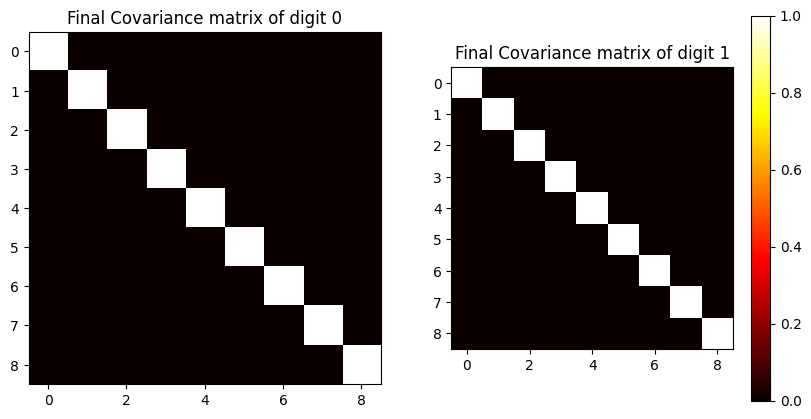

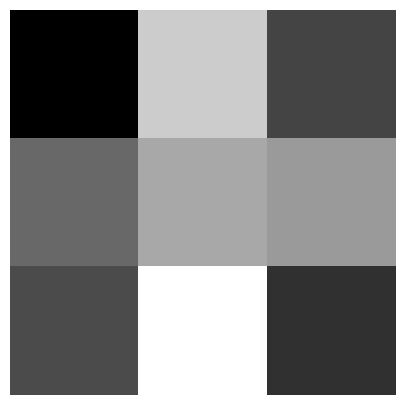

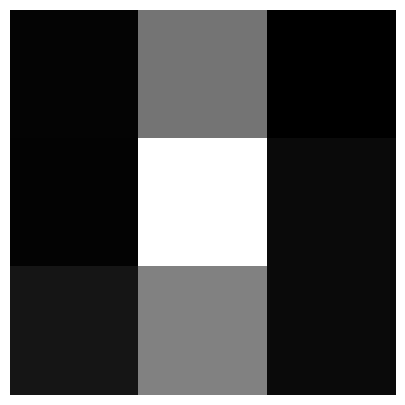

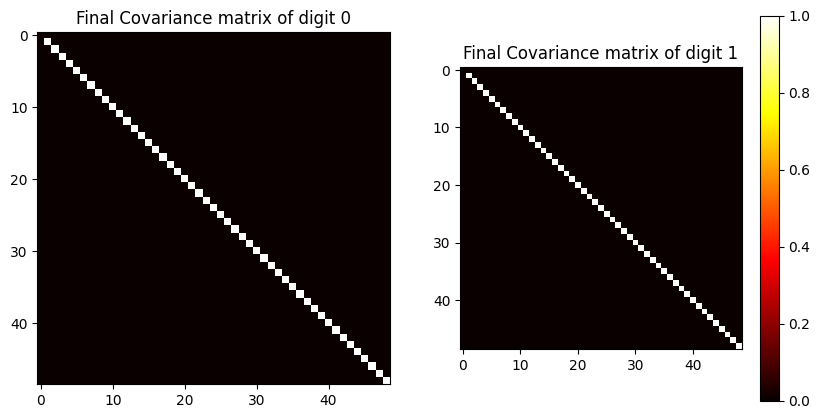

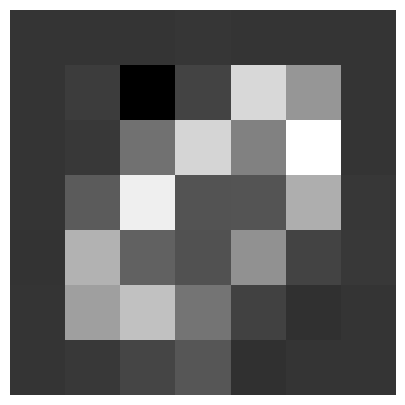

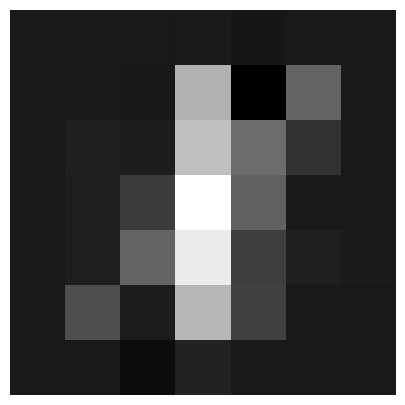

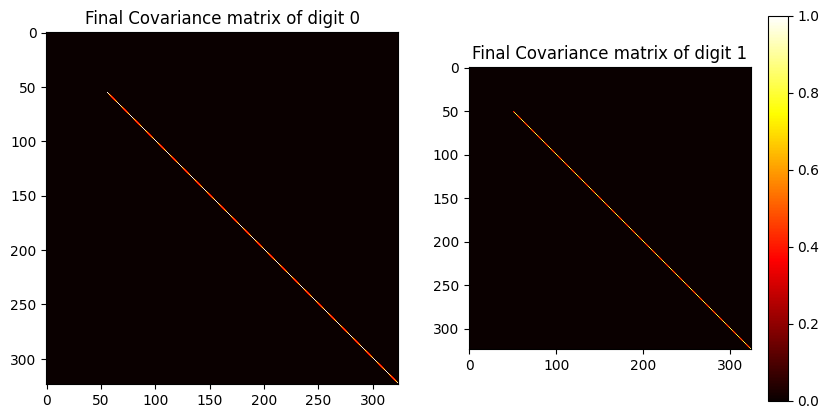

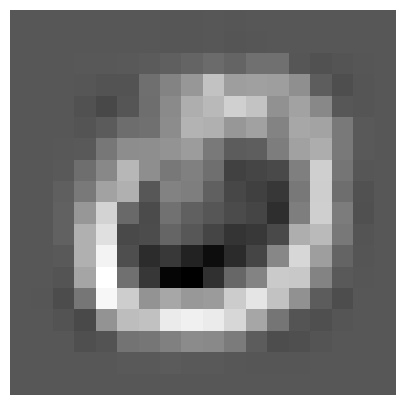

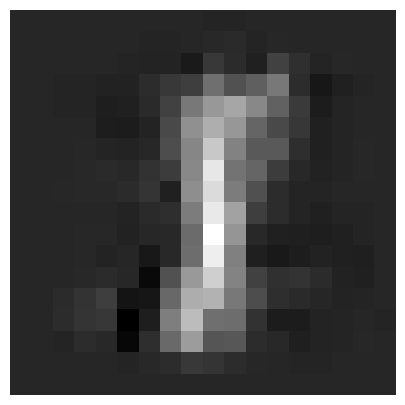

In [31]:
final_0_9, final_1_9, inv_0_9, inv_1_9, avg_mean_9, diff_mean_9, final_mean_9, final_cov_9 = decorr_white(X_subsampled, new_shape)
final_0_49, final_1_49, inv_0_49, inv_1_49, avg_mean_49, diff_mean_49, final_mean_49, final_cov_49 = decorr_white(X_subsampled_2, new_shape_2)
final_0_324, final_1_324, inv_0_324, inv_1_324, avg_mean_324, diff_mean_324, final_mean_324, final_cov_324 = decorr_white(X_subsampled_3, new_shape_3)

In [32]:
# generate a random variable which is + 1 or -1 with probability p or 1-p
def generate_random_variable(p):
    if np.random.rand() < p:
        return 1
    else:
        return -1

In [33]:
def generate_dataset_multivariate_gen(mu, var, p, num_samples, dim):
    # generate a dataset of 1000 samples of x = mu*generate_random_variable(p) + sigma*z
    x = []
    # cov = np.diag(var)
    std = np.sqrt(var)
    std_mat = np.diag(std)
    mu = np.array(mu)
    for i in range(num_samples):
        new_pt = mu*generate_random_variable(p) + np.matmul(std_mat, np.random.normal(0, 1, dim))
        x.append(new_pt)
    return torch.tensor(np.array(x))

In [34]:
def equations_d_dim_stable(vars, x_data):
    vars = torch.tensor(vars, dtype=torch.float64, device=x_data.device, requires_grad=False)
    n_val, d_val = x_data.shape
    mu_hat = vars[:-1]
    c_hat = torch.clamp(vars[-1], -50, 50)

    epsilon = 1e-5
    x2_col_sum = torch.sum(x_data ** 2, dim=0) / n_val
    var_hat = torch.clamp(x2_col_sum - mu_hat ** 2, min=epsilon)
    inv_var_hat = 1 / (var_hat + epsilon)

    s = torch.matmul(x_data * inv_var_hat, mu_hat)
    tanh_val = torch.tanh(torch.clamp(s + c_hat, -10, 10))

    eq1 = torch.sum(x_data * tanh_val.unsqueeze(1), dim=0) - n_val * mu_hat
    eq2 = torch.sum(tanh_val) - n_val * torch.tanh(c_hat)
    
    return torch.cat([eq1, eq2.unsqueeze(0)]).cpu()

In [35]:
from numpy.random import multivariate_normal

def sample_reconstruct(mean_arr, cov_arr, p_arr, idx_list, mean_tuple, inv_transform_0, inv_transform_1, final_shape):

    dim = len(mean_arr[0])

    avg_mean, diff_mean, final_mean = mean_tuple

    for idx in idx_list:
        mean = mean_arr[idx]
        var = cov_arr[idx]
        p = p_arr[idx]

        print(f'mean = {mean}')
        print(f'var = {var}')
        print(f'p = {p}')

        # sample and reconstruct 5 images as a subfigure
        fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharex=True, sharey=True)

        image_list = generate_dataset_multivariate_gen(mean, var, p, 5, dim).numpy()
        for i in range(5):
            image = image_list[i]
            dist_metric = np.linalg.norm(image - final_mean) - np.linalg.norm(image + final_mean)
            digit = 0 if dist_metric > 0 else 1
            if digit == 0:
                image = np.matmul((image + avg_mean + diff_mean + final_mean), inv_transform_0).reshape(-1, final_shape[1])
            else:
                image = np.matmul((image + avg_mean - diff_mean - final_mean), inv_transform_1).reshape(-1, final_shape[1]) 
            axes[i].imshow(image, cmap='gray')
            axes[i].axis('off')

        plt.tight_layout()
        plt.title(f'Sample and Reconstruct for digit {digit} and epoch {idx}')
        plt.show()
        plt.close()


def plot_fn_mnist(mu_arr, var_arr, p_arr, mean_tuple, inv_transform_0, inv_transform_1, final_shape):

    # Create a figure for all mu dimensions
    fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

    axes = axes.flatten()

    factor = int(final_shape[0] * final_shape[1]/9)

    idx_list = [factor*i for i in range(8)]
    idx_list.append(-1)

    for i in range(9):
        ax = axes[i]  # Select the subplot axis
        for mu in mu_arr:
            ax.plot([row[idx_list[i]] for row in mu])
        ax.set_xlabel("Generation")
        ax.set_ylabel(fr"$\widehat{{\mu}}_{{{idx_list[i]}, \mathrm{{ML}}}}$")
        # set y from -4 to 4
        # ax.set_ylim(-1, 1.5)
        ax.set_title(fr"Estimated $\mu_{{{idx_list[i]}}}$")
        ax.legend()

    fig.tight_layout()
    plt.show(fig)
    plt.savefig('mnist_mu.png')
    plt.close(fig)

    # Separate figures for sigma and p
    # Sigma
    # Create a figure for all mu dimensions
    fig_1, axes_1 = plt.subplots(3, 3, figsize=(20, 20), sharex=True, sharey=True)

    axes_1 = axes_1.flatten()

    for i in range(9):
        ax1 = axes_1[i]  # Select the subplot axis
        for var in var_arr:
            ax1.plot([var_row[idx_list[i]] for var_row in var])
        ax1.set_xlabel("Generation")
        ax1.set_ylabel(fr"$\widehat{{\sigma}}_{{{idx_list[i]}, \mathrm{{ML}}}}$")
        # ax1.set_ylim(-1, 1.5)
        ax1.set_title("Estimated var")
        ax1.legend()

    fig_1.tight_layout()
    plt.show(fig_1)
    plt.savefig('mnist_sigma.png')
    plt.close()

    # Probabilities
    plt.figure(figsize=(7, 5))
    for p_vals in p_arr:
        sns.lineplot(data=np.array(p_vals))
    plt.xlabel("Generation")
    plt.ylabel(r"$\widehat{p}_{ML}$")
    plt.title("Estimated Probabilities")
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig('mnist_p.png')
    plt.close()

    test_idx = np.random.randint(0, len(mu_arr))
    test_mu_traj = mu_arr[test_idx]
    test_var_traj = var_arr[test_idx]
    test_p_traj = p_arr[test_idx]
    idx_list = np.arange(0, len(test_mu_traj) - 1, len(test_mu_traj)//10)
    idx_list = np.append(idx_list, len(test_mu_traj) - 1)
    print(f'idx_list = {idx_list}')
    sample_reconstruct(test_mu_traj, test_var_traj, test_p_traj, idx_list, mean_tuple, inv_transform_0, inv_transform_1, final_shape)
    # sample_reconstruct(test_mu_traj, test_var_traj, 1, idx_list, mean_tuple, inv_transform_1, final_shape)


In [40]:
def mnist_exp(x_data, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, mean_tuple, inv_transform_0, inv_transform_1, final_shape, add_old_data=0):
    for mu_0 in mu_0_vals:
        for var_0 in var_0_vals:
            for p_0 in p_0_vals:
                pbar1 = tqdm(total=num_trajectories * num_generations)
                mu_arr, var_arr, p_arr = [], [], []
                
                for _ in range(num_trajectories):
                    mu, var, p = [mu_0], [var_0], [p_0]
                    
                    for i in range(1, num_generations + 1):
                        if i == 1:
                            print(f'Generation {i}')
                        Y = torch.tensor(x_data) if i == 1 else generate_dataset_multivariate_gen(mu[-1], var[-1], p[-1], n, dim).to(device)

                        if add_old_data > 0 and i > 1:
                            # shuffle old data and add it to the new data
                            old_data = x_data[torch.randperm(x_data.shape[0])]
                            old_data = old_data[:add_old_data]
                            Y = torch.cat([Y, torch.tensor(old_data).to(device)], dim=0)

                        n = Y.shape[0]
                        
                        init_guess = torch.tensor([7.0]*(dim) + [0.2], device=device) + torch.randn(dim + 1, device=device)
                        soln_vals = torch.tensor(sopt.least_squares(lambda vars: equations_d_dim_stable(vars, Y), x0 = init_guess).x)
                        # soln_vals = torch.linalg.lstsq(equations_d_dim_stable(init_guess, Y)).solution
                        
                        y2_data = torch.clamp(Y, min=-1e8, max=1e8) ** 2
                        var_hat = torch.sum(y2_data, axis=0) / n - soln_vals[:-1] ** 2
                        var_hat = torch.clamp(var_hat, min=1e-5, max=1e5)
                        
                        if (torch.abs(soln_vals[:-1]) > 1e3).any():
                            print(f'Overflow in mu: {soln_vals[:-1]}')
                            break
                        
                        mu.append(soln_vals[:-1])
                        var.append(var_hat)
                        p.append(torch.sigmoid(soln_vals[-1]))
                        
                        pbar1.update(1)
                    
                    mu_arr.append(mu)
                    var_arr.append(var)
                    p_arr.append(p)
                
                plot_fn_mnist(mu_arr, var_arr, p_arr, mean_tuple, inv_transform_0, inv_transform_1, final_shape)
                pbar1.close()


In [ ]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim = 9
num_trajectories = 1
num_generations = 1000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_9 = shuffle(np.concatenate((final_0_9[:num_0], final_1_9[:num_1]), axis=0))
x_data_49 = shuffle(np.concatenate((final_0_49[:num_0], final_1_49[:num_1]), axis=0))
x_data_324 = shuffle(np.concatenate((final_0_324[:num_0], final_1_324[:num_1]), axis=0))

# # Convert numpy arrays to torch tensors
# final_var_9 = final_cov_9.diagonal()
# mu_0_vals = [torch.tensor(final_mean_9, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_9, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_9, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, (avg_mean_9, diff_mean_9, final_mean_9), inv_0_9, inv_1_9, new_shape)

# # repeat for 49
# dim_49 = 49
# final_var_49 = final_cov_49.diagonal()
# mu_0_vals = [torch.tensor(final_mean_49, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_49, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_49, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_49, device, (avg_mean_49, diff_mean_49, final_mean_49), inv_0_49, inv_1_49, new_shape_2)

# repeat for 324
dim_324 = 324
final_var_324 = final_cov_324.diagonal()
mu_0_vals = [torch.tensor(final_mean_324, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_324, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_324, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_324, device, (avg_mean_324, diff_mean_324, final_mean_324), inv_0_324, inv_1_324, new_shape_3, add_old_data = 1)

  0%|          | 0/3000 [00:00<?, ?it/s]

Generation 1


  0%|          | 1/3000 [00:01<1:12:54,  1.46s/it]C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)
100%|██████████| 3000/3000 [8:08:22<00:00, 16.41s/it]   C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\1173561831.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


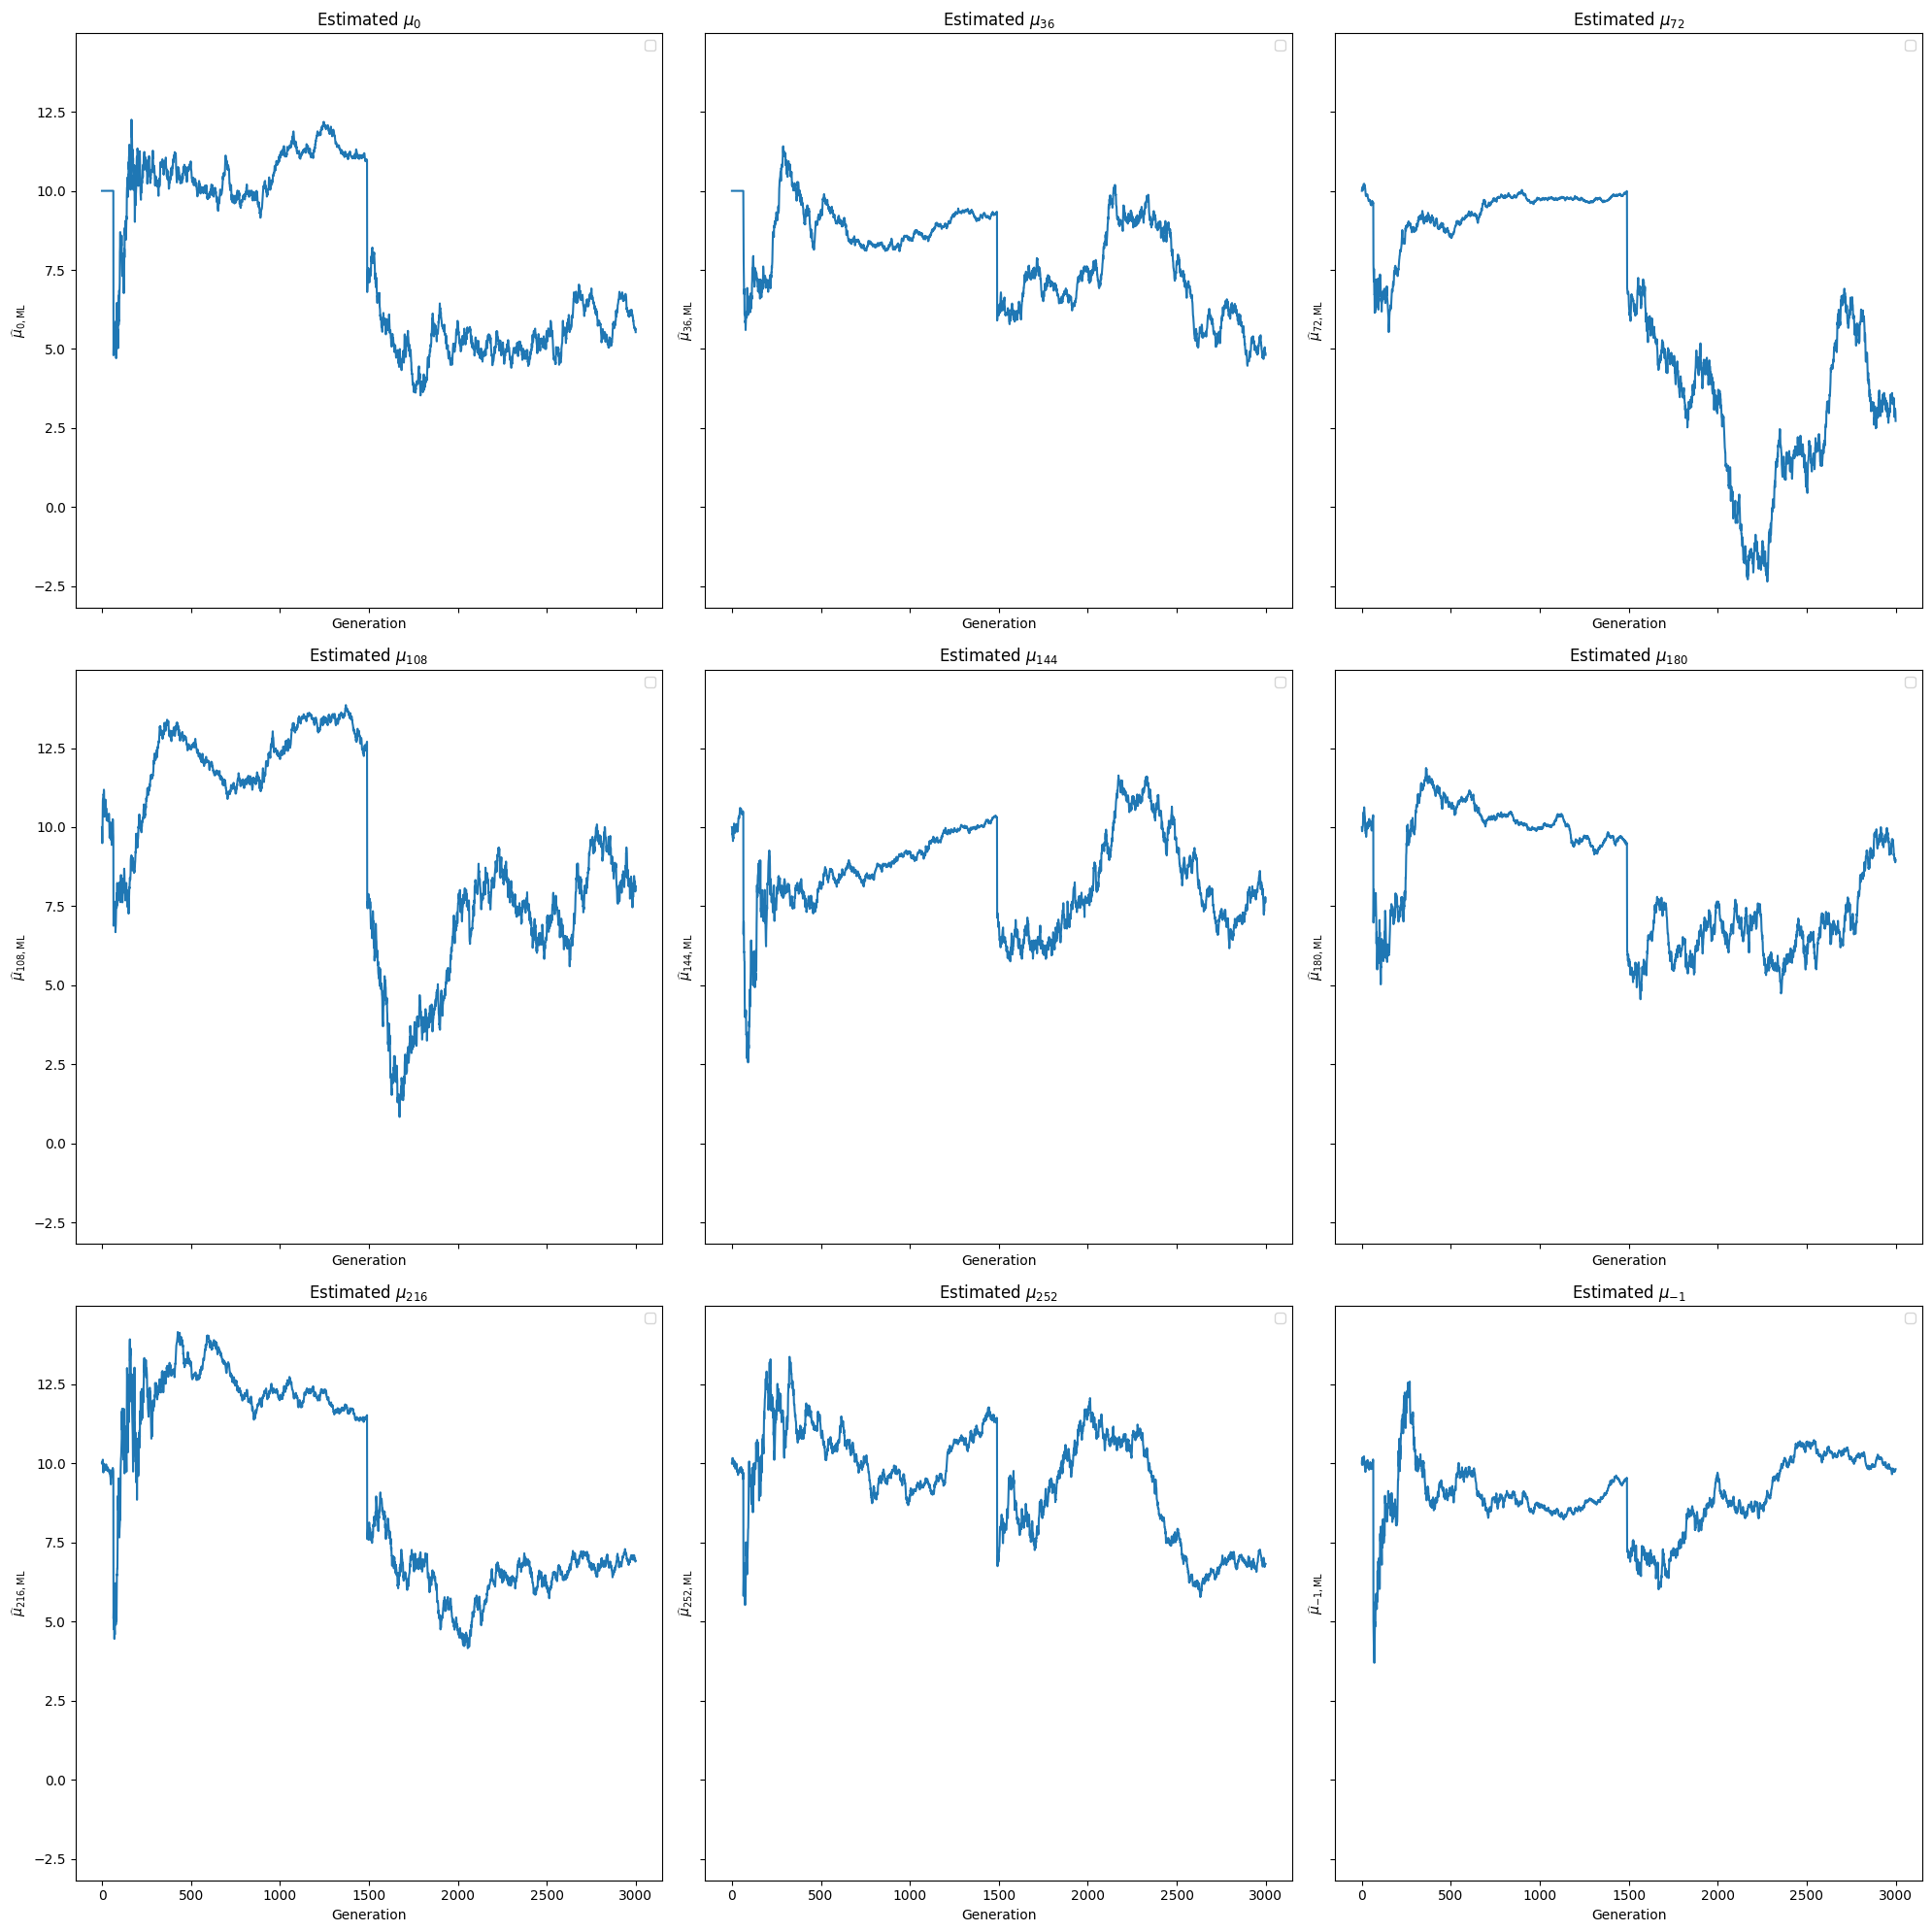

C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\1173561831.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

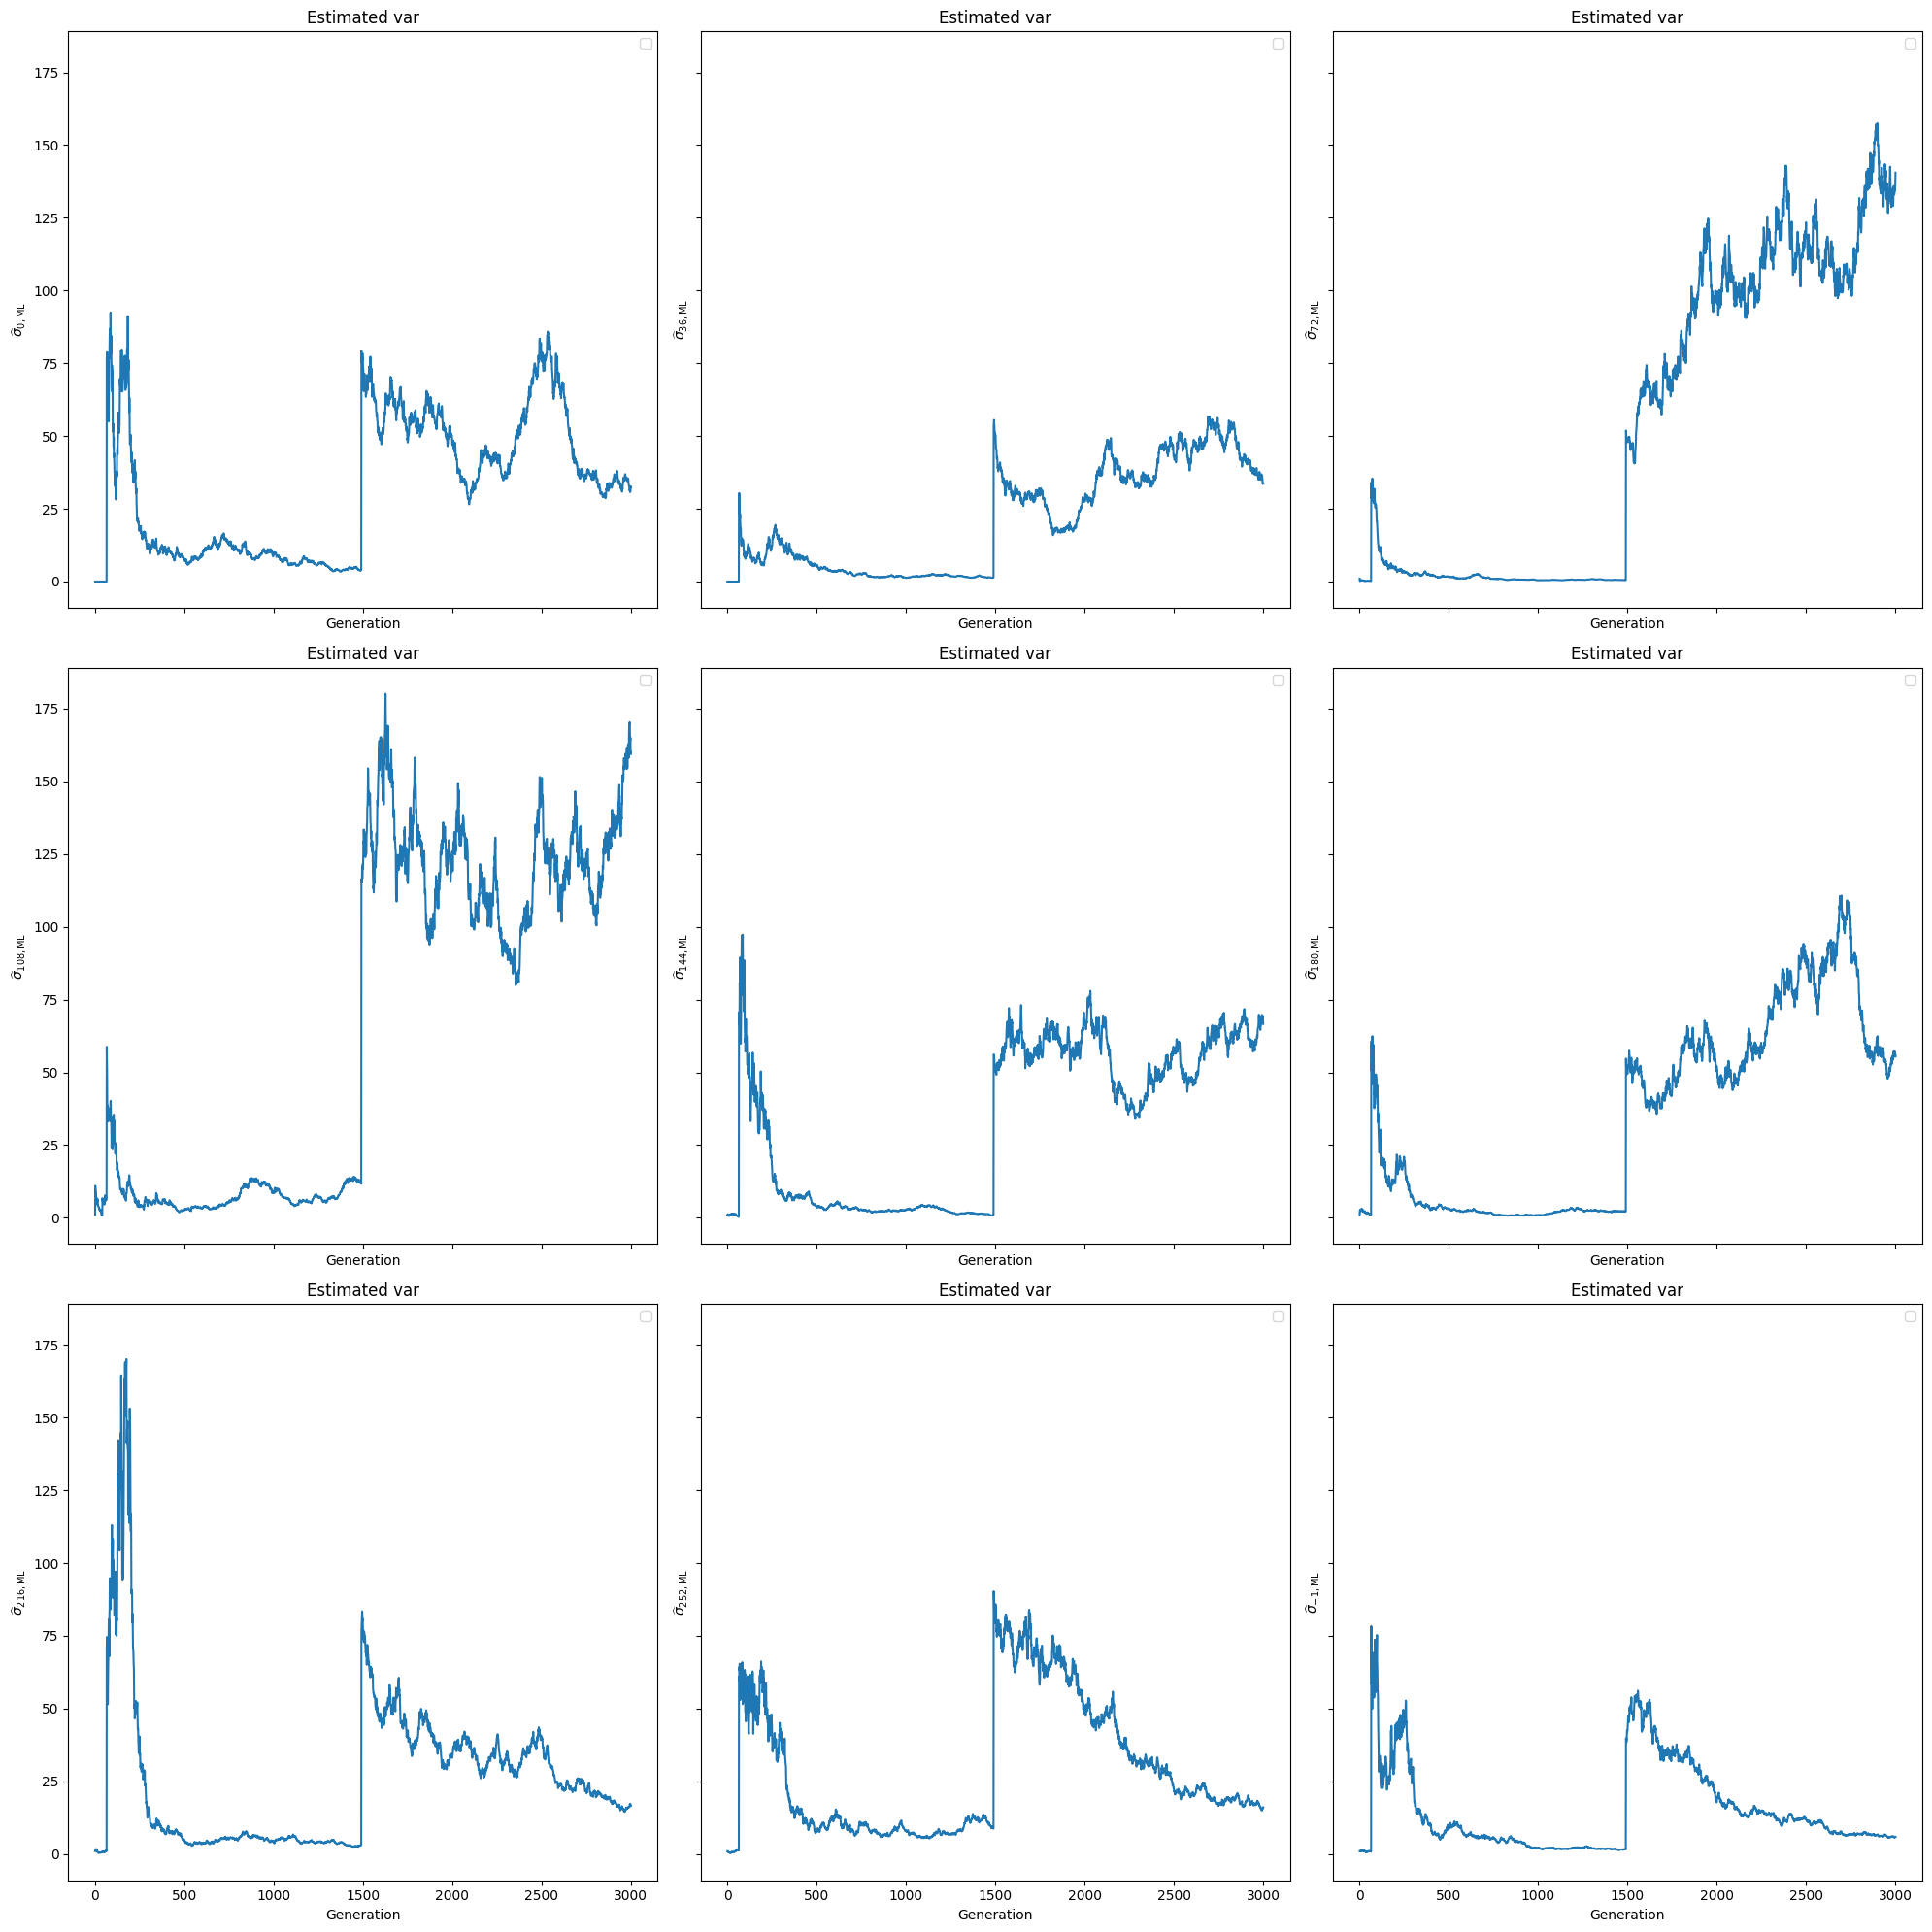

C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\1173561831.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


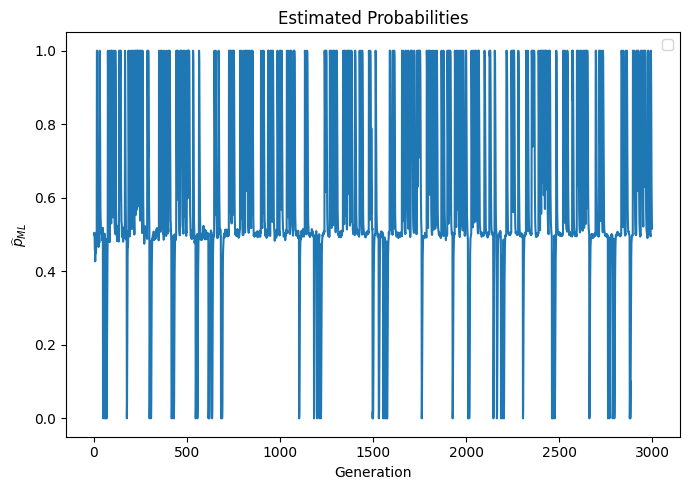

idx_list = [   0  300  600  900 1200 1500 1800 2100 2400 2700 3000]
mean = tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,

C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)


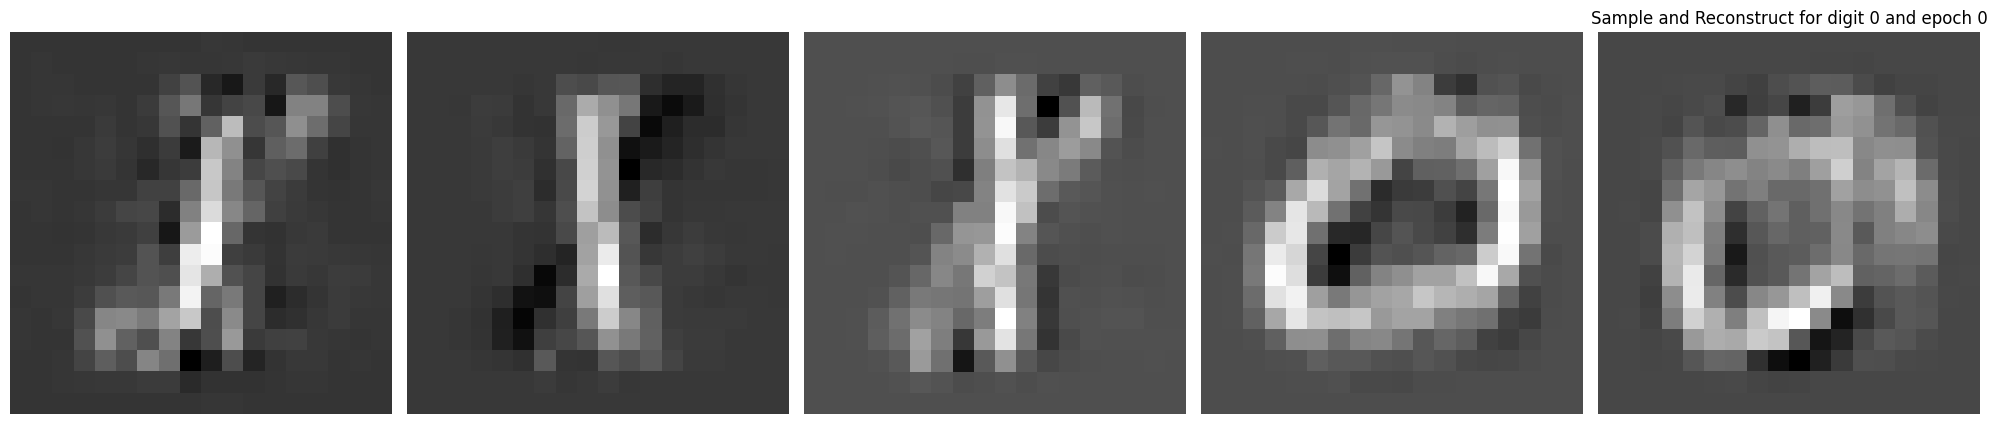

mean = tensor([10.2741,  7.7104,  8.2928,  8.0379,  8.2999,  7.9592,  9.9560,  8.6068,
         8.5099, 12.0012, 10.5983, 10.1874, 10.1330,  9.5978,  8.0249,  7.7390,
         6.8887,  9.3107, 13.2914,  9.3805,  5.6685, 12.0845,  7.2935,  7.6226,
         8.8096, 10.3516, 11.0673,  8.3944,  9.4788,  7.2029, 10.7327,  5.5747,
         8.4628, 12.9756,  8.0545,  7.3936, 11.0735, 11.0991,  7.4065, 11.3812,
         9.4972, 10.6199, 10.0062,  7.7034,  7.8736,  8.2187, 10.7182, 10.5899,
        10.3712,  7.3867,  7.4854,  8.6765,  8.9750,  8.4419,  7.9482,  8.1816,
        10.2734,  8.6451,  9.4470, 13.6033, 10.1457, 10.0350,  3.2623,  6.9822,
         8.7351, 10.1766,  8.3019,  9.9619,  6.9513,  7.8740,  5.6035, 11.3574,
         8.8288, 12.7016,  7.8363,  9.1845,  6.1009,  8.7379, 11.4725,  6.0314,
         8.7355,  9.8944,  8.5300,  5.7013, 10.2602, 10.0487,  9.1738, 13.4304,
         7.9328,  9.1832,  7.1694,  9.1799,  7.9714,  8.0429, 10.6653,  8.3654,
         9.3376,  7.2754,  7.3840

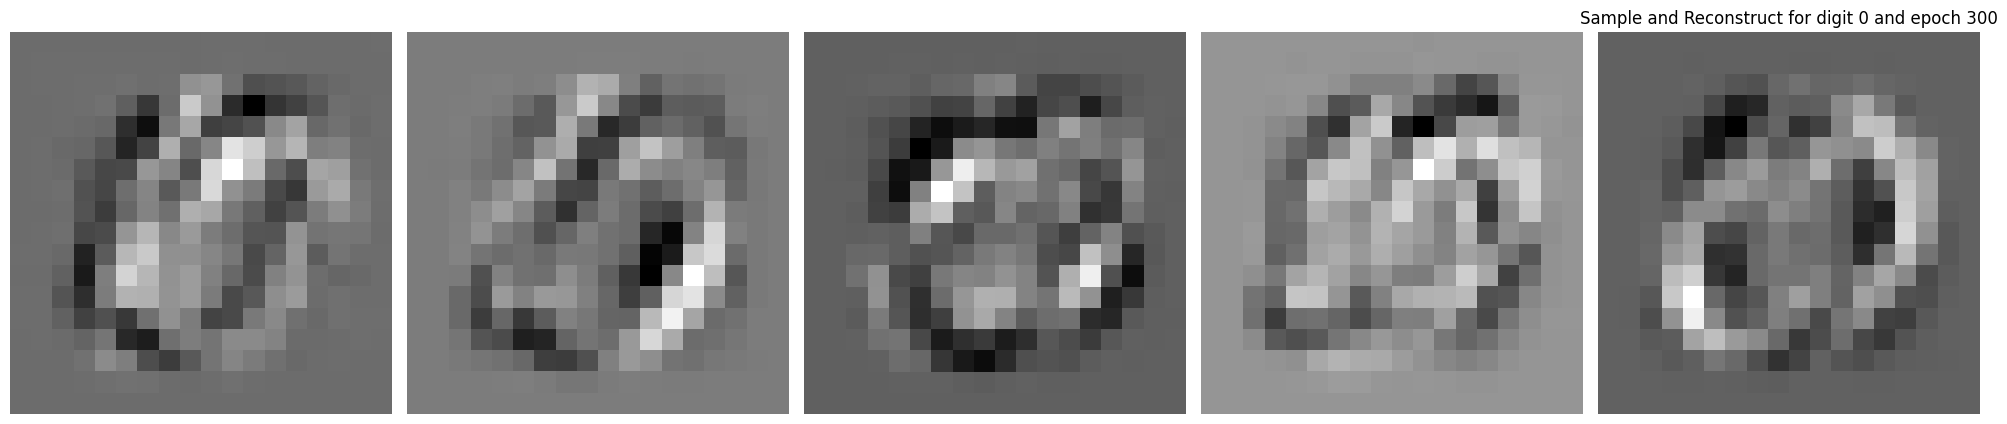

mean = tensor([  9.8275,  10.1604,   9.6935,   8.5931,   9.9492,   8.3693,  10.0161,
          9.0926,   9.3068,  10.9634,   9.5457,  10.3484,   9.2510,  10.2020,
          8.5757,   7.3952,  12.7160,   9.9355,  10.7306,  11.2201,   6.6241,
         11.5648,   7.5810,   8.7853,   9.8371,   9.2236,  10.0811,   8.3454,
          9.7642,   9.7417,  10.1765,   7.1177,   9.6457,  11.7992,   7.6692,
          6.3105,   9.2053,  10.2617,   7.8774,  11.0906,   9.3970,   9.8676,
         10.9382,   8.9261,   9.0571,   8.9357,  10.2710,  10.6226,  10.2319,
          8.6918,   6.4934,   8.1072,   9.2749,   8.9513,   8.4145,   7.0685,
         10.1014,   8.0499,   9.0276,  13.8238,   7.6273,  10.0234,   7.9865,
          6.7347,   9.7794,  11.9031,   8.8367,   9.8472,   8.5541,   8.0438,
          8.3096,   9.5390,   9.3060,  11.6633,   9.4931,   9.4404,   6.7469,
          5.3399,   9.4933,   7.0737,   9.5820,   9.5193,   9.7038,   7.5461,
         10.6055,   6.5186,   8.7609,   7.9461,   9.2407,

  1%|          | 28/3000 [8:09:50<866:34:03, 1049.68s/it]


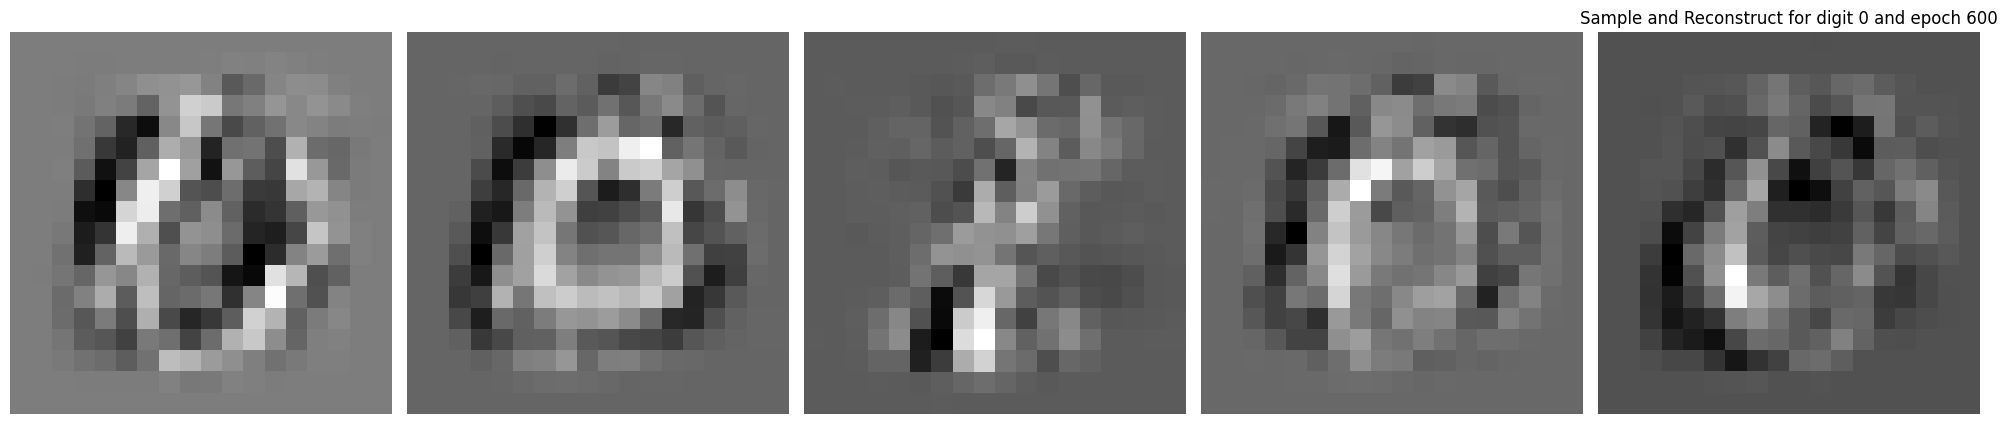

mean = tensor([ 9.4948, 10.1404,  9.7126,  9.4899,  9.8030,  8.9346,  9.5506,  9.5411,
         9.3262, 11.3632,  9.6898, 10.9828,  9.0548, 10.2525,  8.5628,  7.9425,
        10.5153, 10.0472, 10.6831, 11.8158,  8.2686, 11.3758,  8.6833, 10.1983,
         9.8914,  9.4664, 10.6131,  9.6726,  9.7282,  8.2215,  9.5097,  8.3110,
        10.7887, 11.1437,  7.5354,  6.9658,  8.4054, 10.1435,  8.2904, 10.6939,
        10.0814,  9.4929, 10.0556,  8.2857,  9.4387, 10.6318,  9.4800, 10.4573,
        10.1459,  9.3016,  8.4304,  9.3406,  9.5331,  6.7733,  9.2716,  7.8449,
        10.0338, 10.6895,  9.2955, 11.6163,  8.6636,  9.6340,  7.3185,  8.1133,
         8.2653, 11.4889,  8.8486,  9.6922,  9.7640,  8.2487,  9.3857, 10.5421,
        10.0278,  9.9768,  9.6046,  9.0629,  8.4902,  6.5718,  9.8137,  8.2828,
         9.4352,  9.7144, 10.5400,  9.0674, 10.3027,  8.8124,  9.3448,  8.4565,
         8.7373,  8.1719,  8.9262,  9.9204,  9.0122,  9.3935,  9.4988, 10.4263,
         9.7900,  8.7175,  9.4405

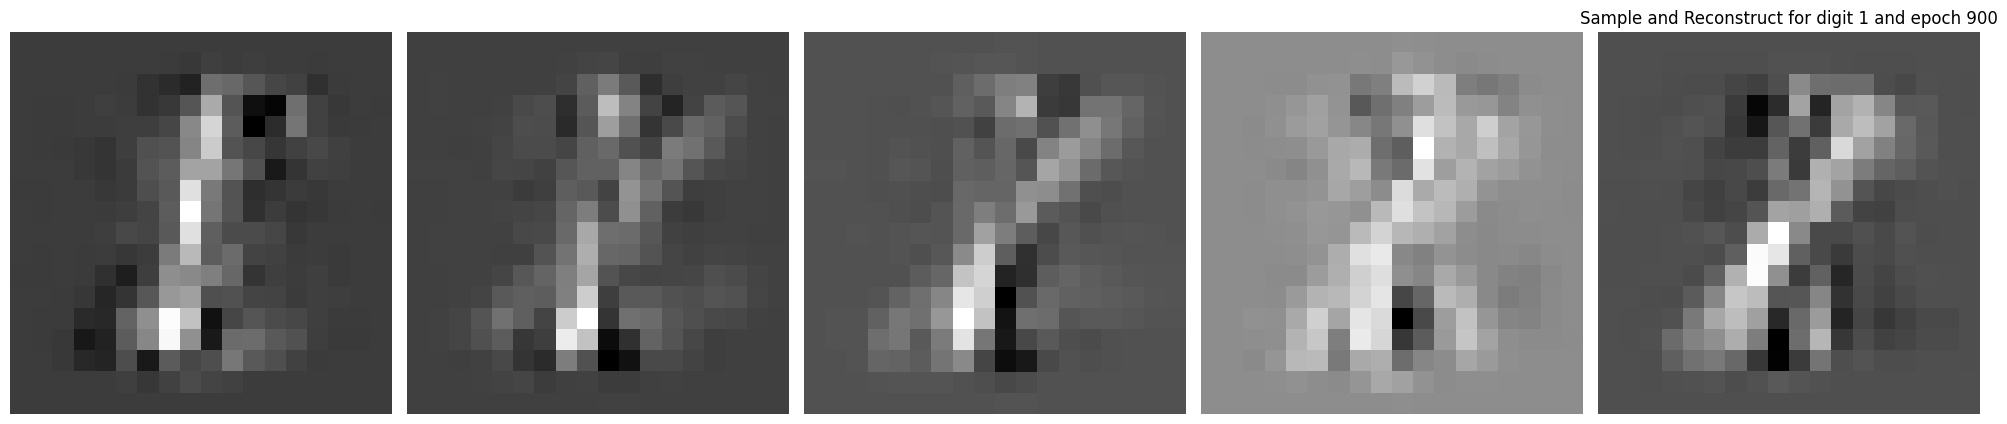

mean = tensor([11.4612, 10.7030,  9.7096,  8.5747,  9.9546,  8.6214,  9.4152,  9.7065,
         9.5409, 10.7023,  9.0142, 10.9033,  9.2440,  9.9805,  8.8419,  8.8081,
        10.5072,  9.7985, 10.1455, 11.9870,  8.5168, 11.1291,  9.1289,  9.9163,
         9.9428,  9.6570, 10.6031,  9.9324,  9.7059,  8.1636,  9.5901,  8.5951,
        10.7005, 11.0486,  7.3341,  9.1088,  8.9202,  9.6302,  9.0679, 10.9331,
         9.5863,  9.4379, 10.2378,  7.9421,  9.6226, 10.3530,  9.6219, 10.6557,
         9.8359,  9.3669, 10.5396,  9.9484,  9.5539,  5.8427, 10.0653,  7.2386,
        10.1395, 10.0828,  9.4505, 10.8134,  9.2809,  9.7602,  9.7539,  9.1352,
         8.3905, 11.8855,  8.8204, 10.0036,  9.3806,  8.7843,  9.4243, 10.7991,
         9.7884, 10.3433,  9.5804,  9.5934,  8.6723,  5.1998, 10.0264,  9.7114,
         9.2652,  9.5444, 10.4570,  9.3931, 10.2217,  8.8934,  9.4368,  8.8461,
         8.5877,  8.4401,  9.0499, 10.0106,  9.4652,  9.8258,  9.5869, 10.3419,
        10.3819,  9.6890,  9.3640

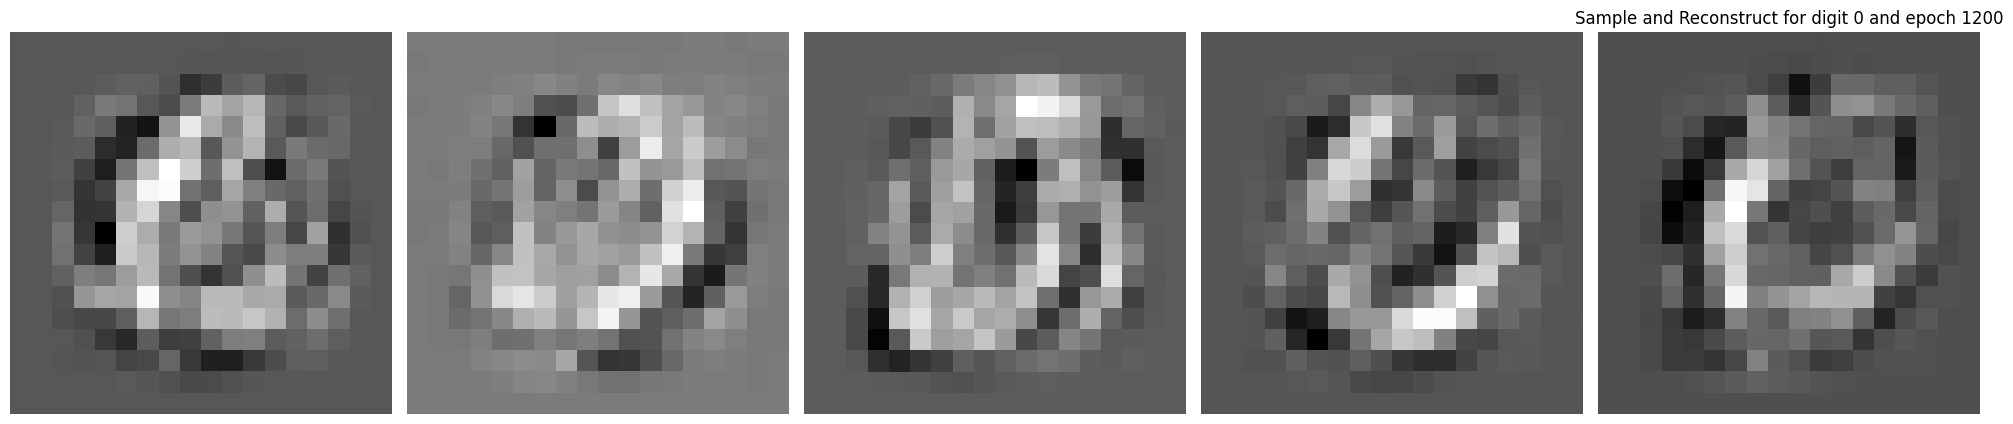

mean = tensor([7.5073, 7.5309, 7.4351, 7.4152, 6.2510, 7.8203, 5.5590, 8.0537, 8.0037,
        7.8410, 6.6076, 6.9446, 8.2096, 7.4570, 5.5994, 8.9068, 7.0023, 6.8578,
        8.8260, 7.7129, 6.7377, 7.3940, 7.3472, 7.0602, 5.6516, 5.4641, 6.2108,
        8.2863, 6.6923, 6.6425, 8.2078, 7.1228, 6.6455, 7.7977, 5.5469, 7.1628,
        6.0646, 5.9166, 5.6486, 7.2808, 7.4932, 6.1244, 6.5876, 5.9989, 6.7378,
        7.1379, 7.2965, 6.0663, 7.0364, 6.8563, 5.9937, 6.4957, 7.2266, 7.1092,
        6.2250, 7.8849, 8.1135, 8.3672, 6.1573, 6.9282, 6.8517, 5.4266, 7.8714,
        6.4410, 5.4866, 7.5280, 8.0829, 5.7713, 5.5811, 6.8019, 5.6818, 8.2820,
        6.5372, 6.5779, 6.7334, 7.9004, 7.2508, 8.0677, 7.2038, 6.2181, 8.2742,
        4.9466, 8.0648, 7.5407, 7.3092, 6.6179, 6.5470, 6.1864, 5.4315, 6.5632,
        4.2092, 7.9652, 5.8758, 6.4881, 6.6910, 7.5533, 6.6273, 6.7478, 7.6444,
        5.6818, 7.1461, 5.2560, 7.5777, 6.6408, 7.5508, 5.8319, 8.0085, 7.1166,
        7.7022, 6.9663, 8.4099, 5

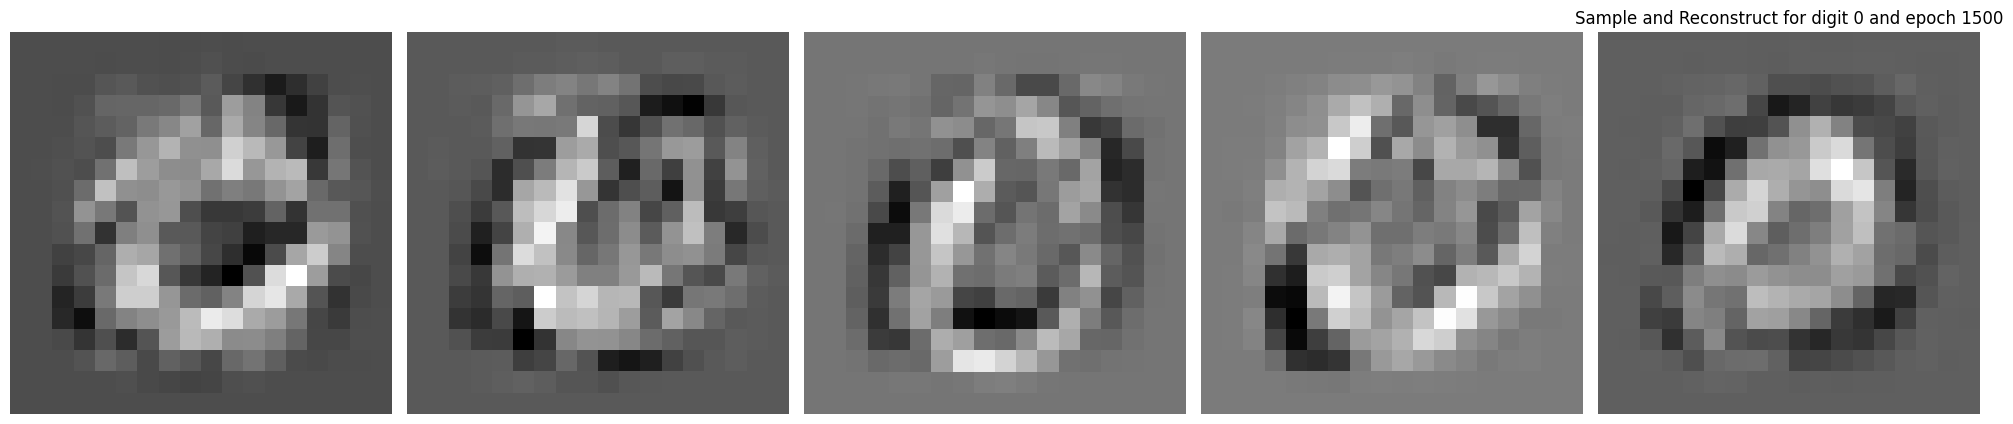

mean = tensor([ 3.8337,  7.7688,  7.9098,  7.1145,  7.3247,  6.3428,  5.0402, 10.5941,
         9.5615,  7.9521,  7.0342,  8.5948,  9.5315,  6.0362,  6.0880,  8.0352,
        12.6952,  6.9547,  8.5836,  8.1786,  7.0840,  8.0878,  6.3336,  6.6712,
         6.0940,  6.2382,  7.3465,  7.7797,  4.1374,  6.4987,  8.2728,  7.8828,
         5.8512,  6.5586,  4.6453,  7.5385,  7.0489, 10.7646,  9.3140,  8.8801,
         6.9562,  7.6117,  6.2371,  7.2185,  7.1738,  7.9119,  6.7397,  5.5684,
         8.2527,  8.6515,  8.0439,  6.5979,  8.1280,  7.5081,  5.1141,  9.4141,
         8.0067,  6.2282,  6.9217,  6.6739,  8.3286,  5.7922,  9.5884,  8.4725,
         7.0960, 13.0483,  6.7851,  6.0912,  7.9083,  6.3703,  4.9490, 11.5266,
         3.6511,  7.8097,  8.3863,  9.8972,  9.2086,  8.5054,  5.6641,  9.0746,
         8.3129,  5.8883, 11.2082,  9.9568,  9.2898,  8.5300, 11.3077,  5.6016,
         8.6661,  9.2324,  5.3466,  8.7222,  6.6535,  6.8395,  8.0763, 10.0347,
         7.4030,  5.7441,  5.6517

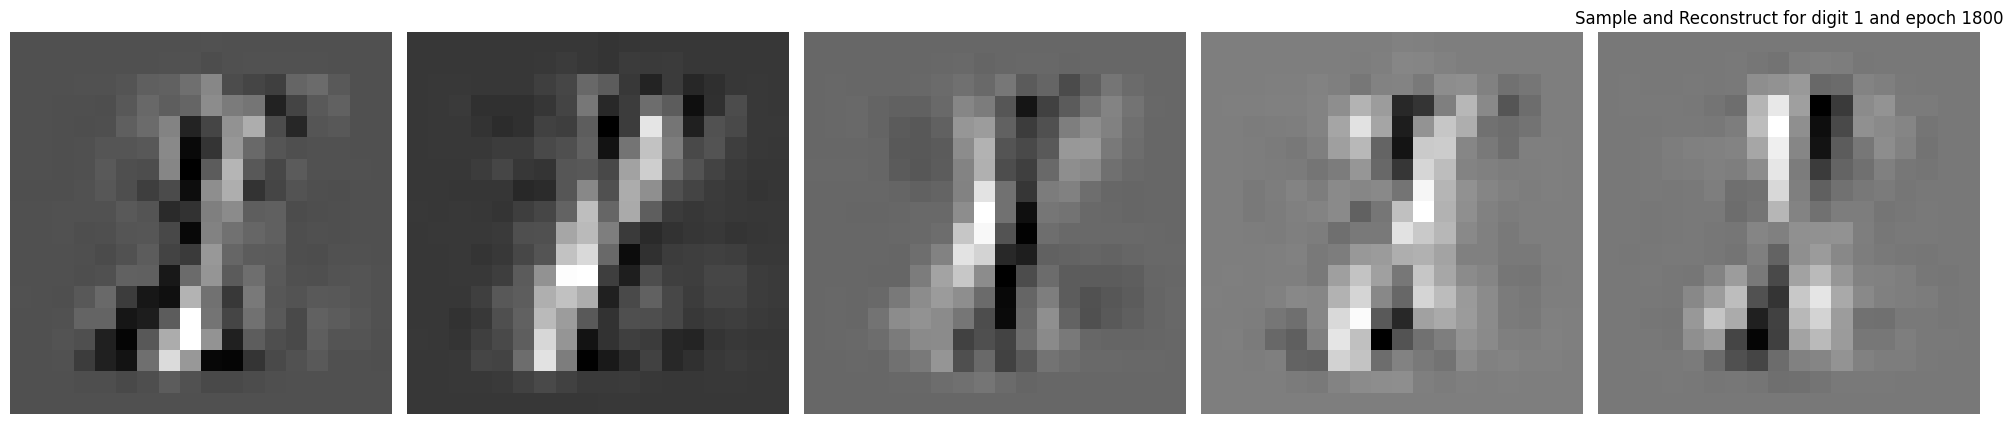

mean = tensor([ 5.3666,  9.1077,  7.3933,  6.7258,  9.6960,  3.6295,  4.1774, 10.6558,
        10.0150,  8.3982,  7.6000,  6.9810,  9.7563,  8.2257,  6.9630,  8.9700,
        10.1613,  8.5598,  9.6950,  7.4059,  7.9356,  8.8018,  5.9063,  7.0221,
         9.6908,  5.8474, 13.2801,  7.6832,  5.1510,  7.6868, 10.3475,  7.7658,
         6.4614,  9.1054,  3.8495,  7.2639,  8.6143, 13.2266,  9.7512,  7.9969,
         6.2862,  6.5710,  8.2789,  8.6770, 10.3399,  7.7212,  8.2633,  5.0857,
        11.8192,  7.7475, 13.1092,  7.7429,  7.3396,  8.2454,  5.3221, 10.0847,
         7.6998,  6.1757,  7.0394, 10.2537,  9.1607,  6.1142, 13.7200,  6.7423,
         9.1892, 11.5331,  8.8421,  5.6366,  9.9087,  5.6456,  5.5109, 10.0829,
        -0.0616,  7.4819,  7.0421,  9.6211,  9.3414, 10.1217,  5.7994,  9.4044,
         8.8402,  7.2728, 10.3866,  8.6402, 10.0333,  6.1230, 10.7549,  6.5533,
         8.6807,  9.1089,  9.4781,  7.6010,  6.7669,  8.3147,  8.1513, 10.9623,
         7.3269,  5.7042,  6.7824

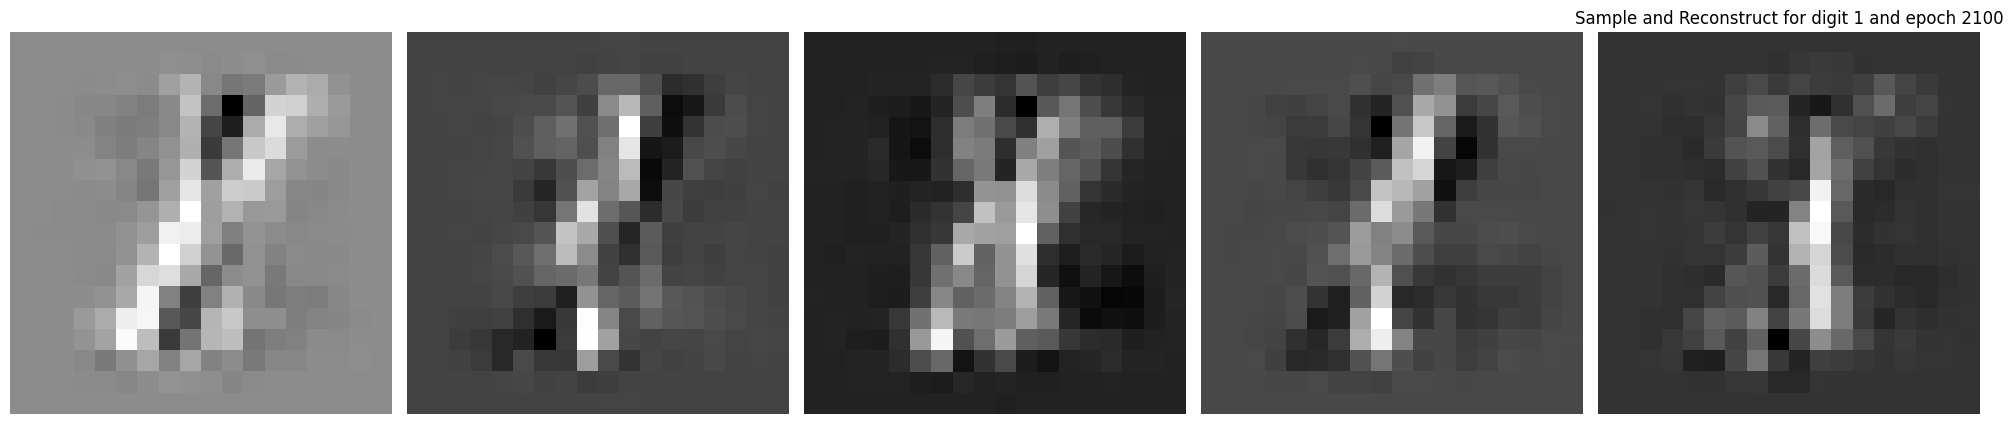

mean = tensor([ 4.7289,  8.6895,  7.8901,  8.1211,  4.6067,  6.7249,  4.8565, 13.2797,
        10.7889,  8.4353,  8.6067,  6.4087,  9.3422, 10.0296,  7.1517,  8.8871,
        10.8145,  7.1227,  9.7639,  6.8085,  8.2876,  7.7612,  4.8343,  6.9950,
        10.2276,  8.0370, 13.2562,  9.4956,  5.4825,  7.2517,  9.0456,  8.2604,
         4.7096,  8.3620,  4.3843,  8.8389,  8.9538, 12.1165,  9.6517,  8.1130,
         5.7900,  4.7744,  5.8231,  9.6516, 11.0776,  8.2738,  9.5102,  6.8117,
        10.4526,  7.7020, 14.0791,  6.9875,  7.8534,  8.4463,  5.3853, 10.0690,
         8.1245,  6.6910,  7.2499,  9.2414,  7.9261,  7.0712, 12.3045,  7.4640,
         9.5154,  9.0496,  8.4141,  4.7314,  8.7979,  5.8658,  6.1158,  9.9198,
         1.5022,  6.9350,  5.8800, 10.6581,  6.0888,  9.6934,  6.6617,  8.7865,
         8.1718,  9.9149,  9.1591,  9.1357,  8.9072,  6.7066,  9.9196,  6.8822,
         9.4179,  7.8084,  7.9696,  4.9563,  3.5051,  7.0406,  7.2195, 10.7992,
         6.8904,  5.5512,  6.5125

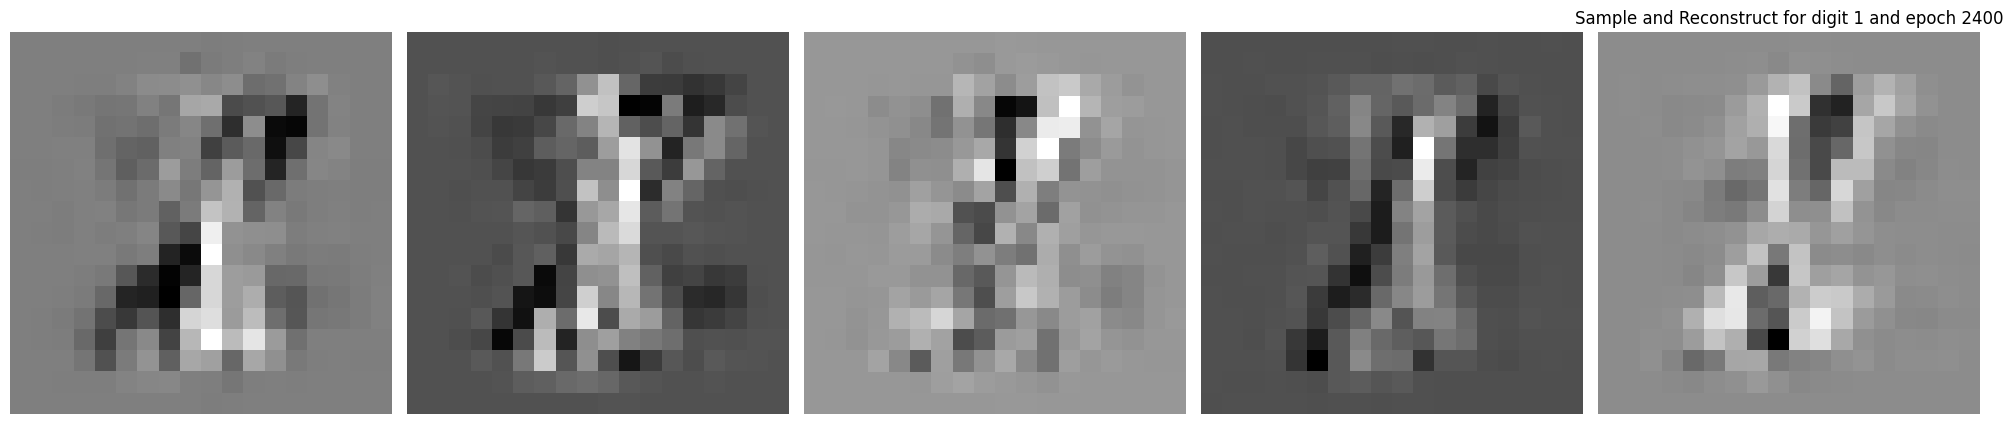

mean = tensor([ 6.5863,  8.2480,  6.1862,  9.6879,  6.7957,  4.5895,  4.4021, 12.6251,
         9.3164,  8.8678,  8.7833,  6.4334,  9.6410,  9.0254,  9.5427,  9.4958,
        10.1948,  8.5344,  9.9961,  8.6993,  8.0304,  6.8645,  6.5903,  6.7296,
         9.4893,  7.8904, 15.3887,  8.0415,  4.3748,  7.7532,  5.6981,  8.0667,
         5.9874,  8.5485,  6.0605,  9.9116,  5.9589, 11.3071,  8.1967,  9.6062,
         7.2863,  5.3235,  8.1027,  9.4974,  9.6637,  7.7128,  8.6816,  7.6154,
        10.8646,  8.2633, 14.2120,  7.0089,  7.8344,  8.3260,  6.0820,  8.9917,
         9.4077,  6.7831,  6.5560,  7.1120, 10.2842,  7.0472, 13.1345,  8.7438,
         9.3794, 10.6432,  8.5895,  3.5338,  6.3084,  6.2859,  6.2508, 10.6924,
         6.3790,  6.8395,  6.1595,  9.6399,  6.9613, 10.2877,  6.6592,  8.6659,
        10.1011, 10.6493,  9.8518, 10.1292,  7.4019,  7.2949,  9.5975,  6.3718,
         9.8504,  7.9695,  9.6620,  6.0128,  3.0243, 10.0933,  8.8612, 10.6223,
         7.5881,  6.3093,  4.8208

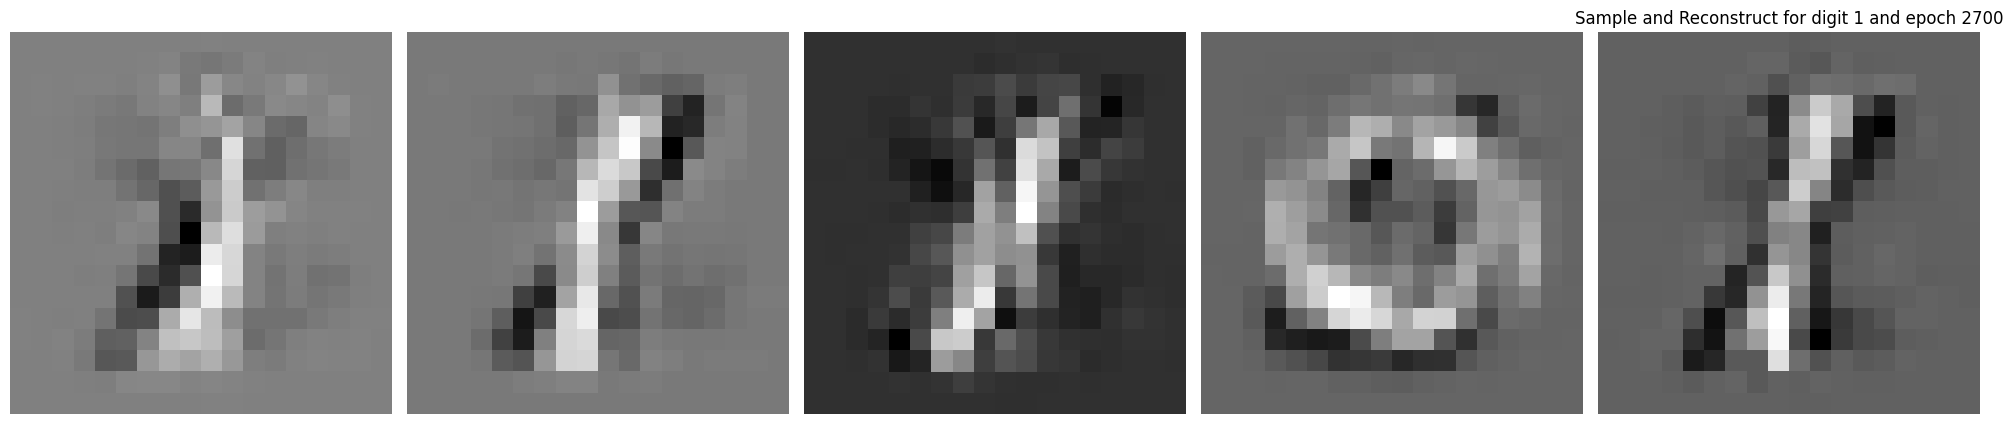

mean = tensor([ 5.5326e+00,  8.6482e+00,  7.1475e+00,  9.6629e+00,  5.3000e+00,
         6.4358e+00,  6.5588e+00,  1.2756e+01,  8.9226e+00,  8.1009e+00,
         8.4631e+00,  6.4298e+00,  9.3635e+00,  9.2309e+00,  1.0065e+01,
         9.5164e+00,  1.1663e+01,  7.6643e+00,  9.8464e+00,  7.2429e+00,
         7.2975e+00,  6.3848e+00,  6.3019e+00,  6.5654e+00,  6.9098e+00,
         7.6544e+00,  1.5300e+01,  7.5176e+00,  5.9138e+00,  7.6980e+00,
         5.8032e+00,  7.9257e+00,  6.2983e+00,  8.4009e+00,  4.8991e+00,
         8.9704e+00,  4.8138e+00,  1.1265e+01,  8.6526e+00,  9.5905e+00,
         6.8792e+00,  4.7625e+00,  8.5494e+00,  9.7470e+00,  1.1851e+01,
         8.1784e+00,  8.6575e+00,  8.1601e+00,  8.7594e+00,  7.8209e+00,
         1.3962e+01,  7.3722e+00,  8.8341e+00,  8.9089e+00,  5.9894e+00,
         9.8884e+00,  8.8510e+00,  6.4378e+00,  6.1203e+00,  7.1652e+00,
         1.1936e+01,  1.0311e+01,  1.2857e+01,  7.7432e+00,  1.0340e+01,
         1.0442e+01,  7.7426e+00,  4.4884e+0

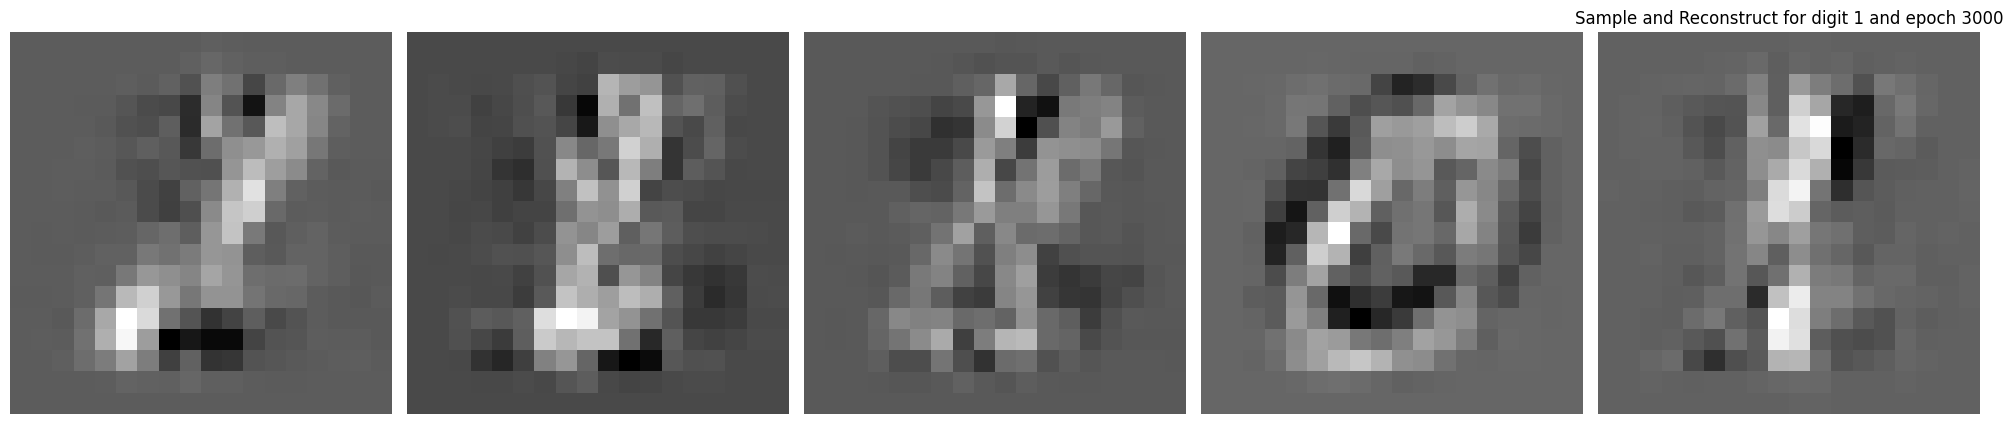

100%|██████████| 3000/3000 [8:08:29<00:00,  9.77s/it]


In [43]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim = 9
num_trajectories = 1
num_generations = 3000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_9 = shuffle(np.concatenate((final_0_9[:num_0], final_1_9[:num_1]), axis=0))
x_data_49 = shuffle(np.concatenate((final_0_49[:num_0], final_1_49[:num_1]), axis=0))
x_data_324 = shuffle(np.concatenate((final_0_324[:num_0], final_1_324[:num_1]), axis=0))

# # Convert numpy arrays to torch tensors
# final_var_9 = final_cov_9.diagonal()
# mu_0_vals = [torch.tensor(final_mean_9, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_9, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_9, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, (avg_mean_9, diff_mean_9, final_mean_9), inv_0_9, inv_1_9, new_shape)

# # repeat for 49
# dim_49 = 49
# final_var_49 = final_cov_49.diagonal()
# mu_0_vals = [torch.tensor(final_mean_49, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_49, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_49, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_49, device, (avg_mean_49, diff_mean_49, final_mean_49), inv_0_49, inv_1_49, new_shape_2)

# repeat for 324
dim_324 = 324
final_var_324 = final_cov_324.diagonal()
mu_0_vals = [torch.tensor(final_mean_324, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_324, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_324, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_324, device, (avg_mean_324, diff_mean_324, final_mean_324), inv_0_324, inv_1_324, new_shape_3, add_old_data = 2)

  0%|          | 0/1000 [00:00<?, ?it/s]

Generation 1


  0%|          | 1/1000 [00:00<16:29,  1.01it/s]C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)
100%|██████████| 1000/1000 [4:59:40<00:00, 32.71s/it] C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\1173561831.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


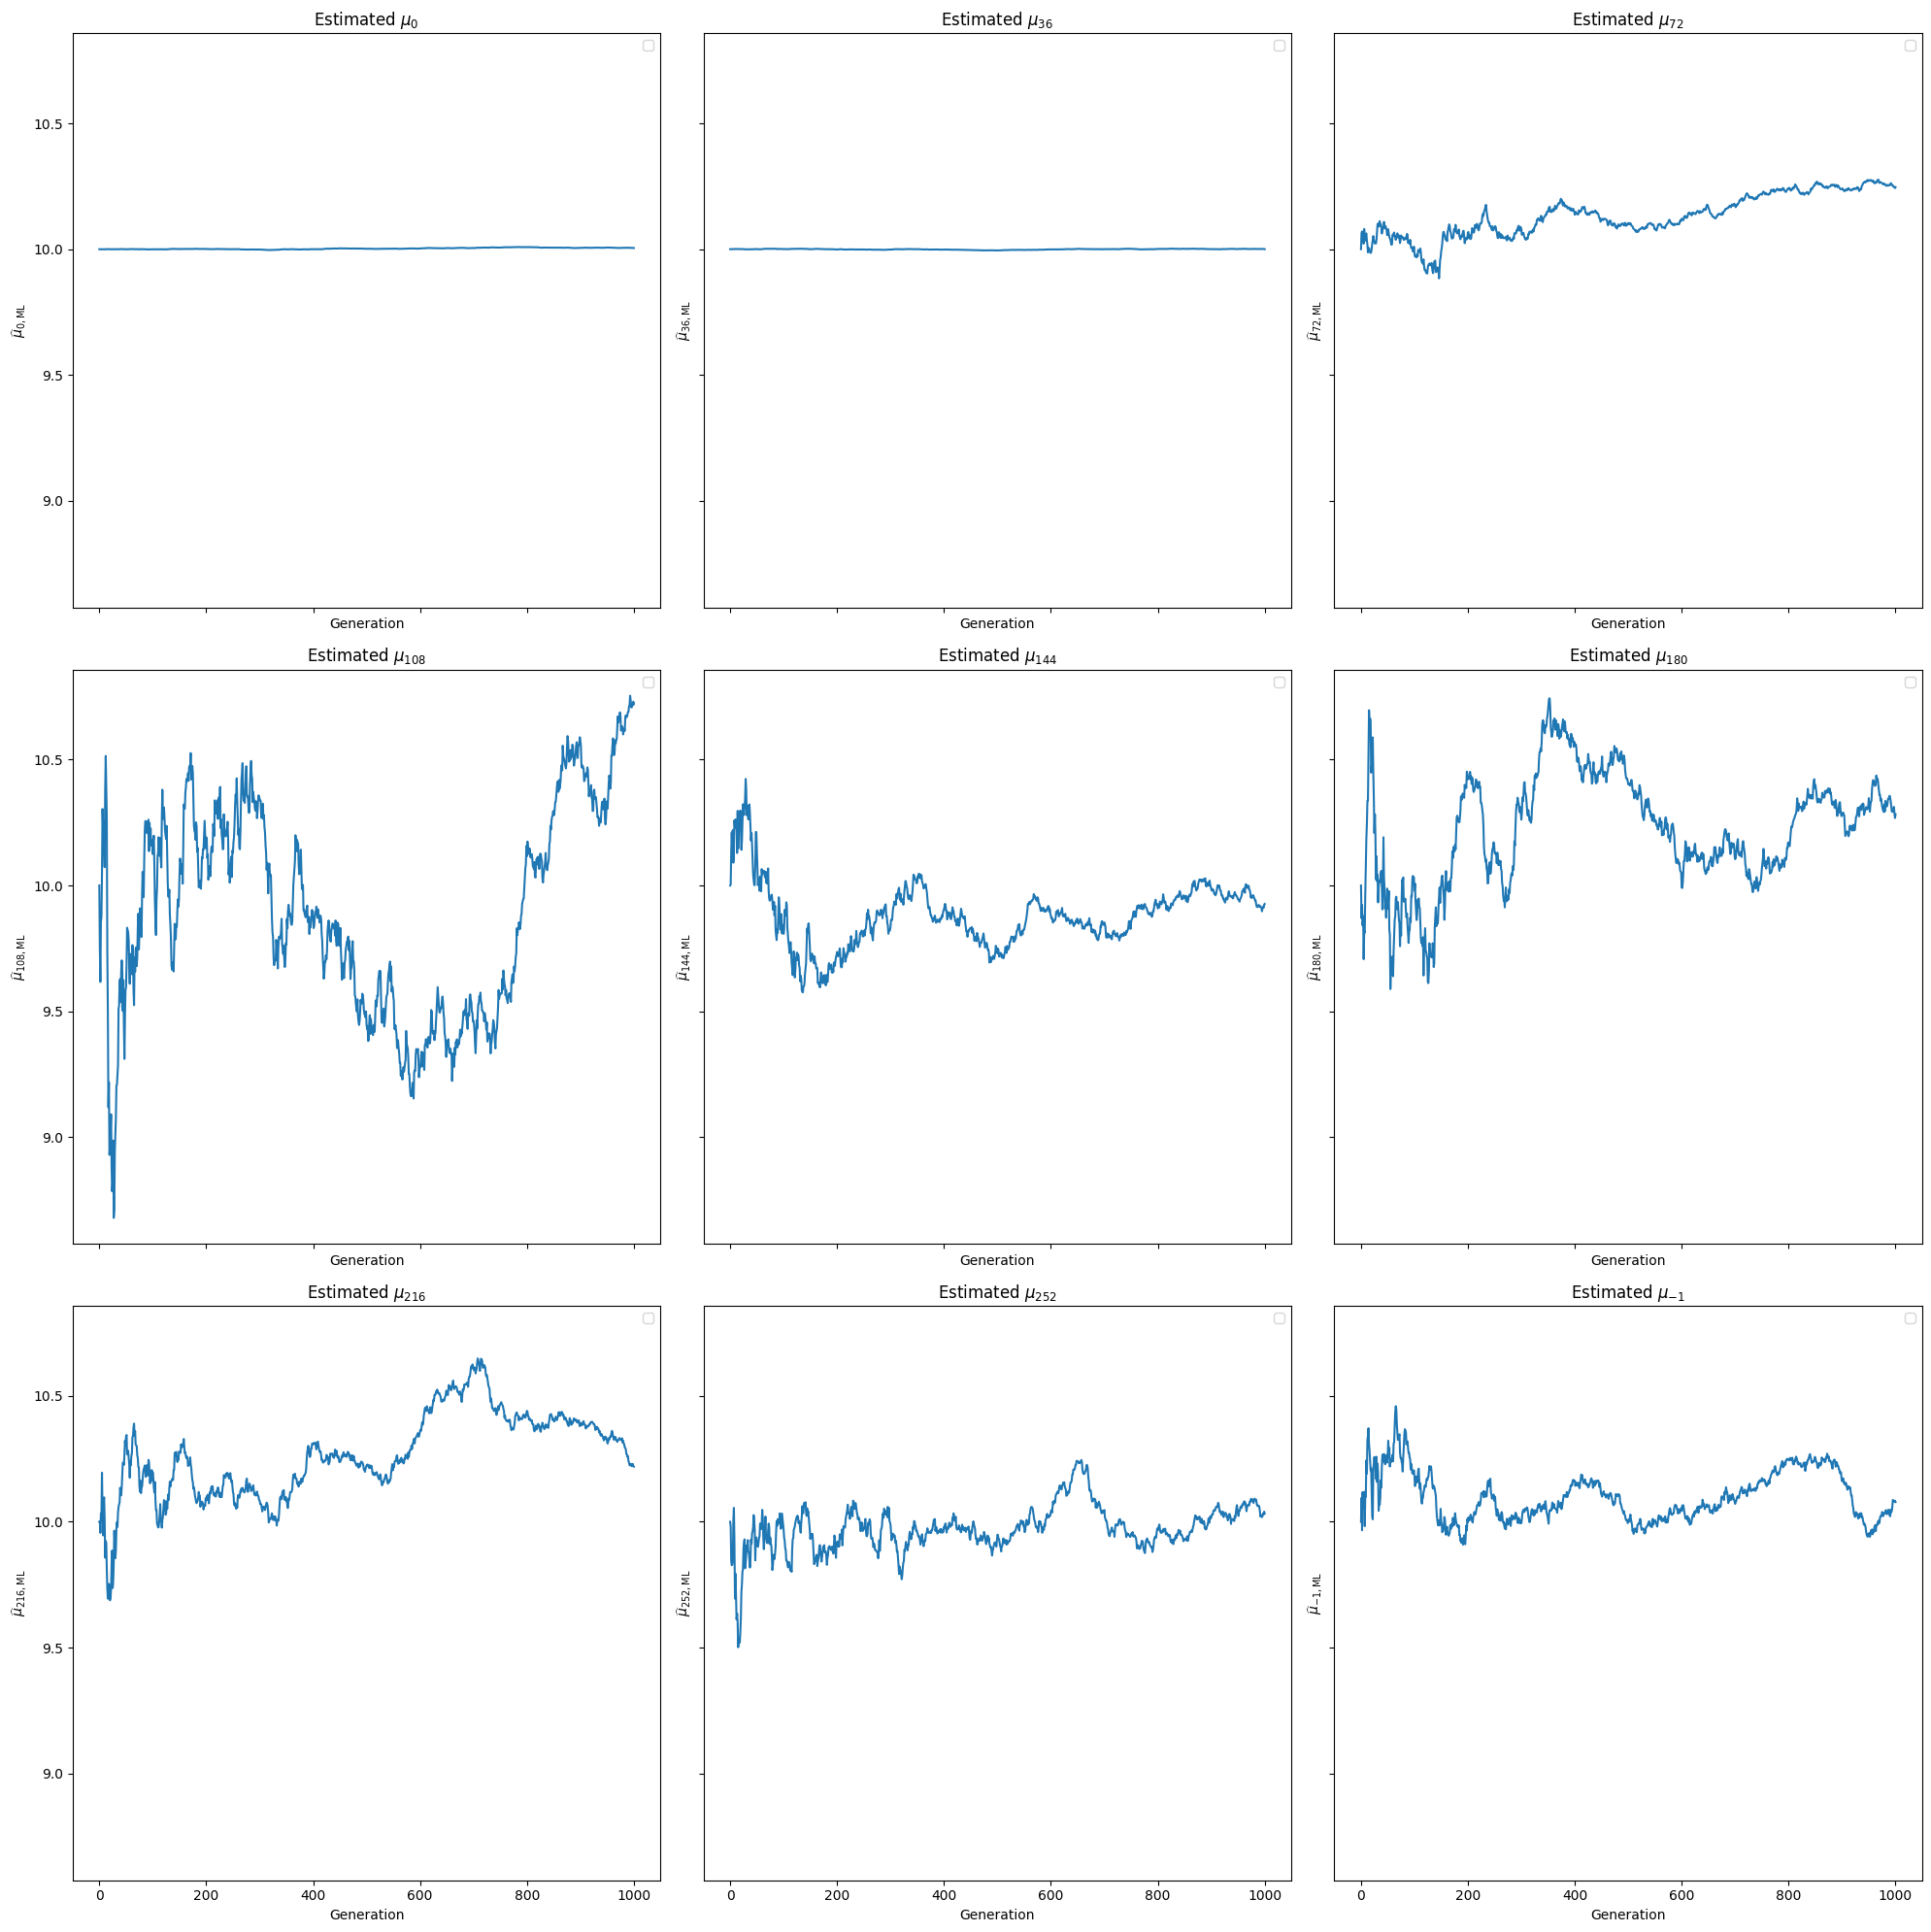

C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\1173561831.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

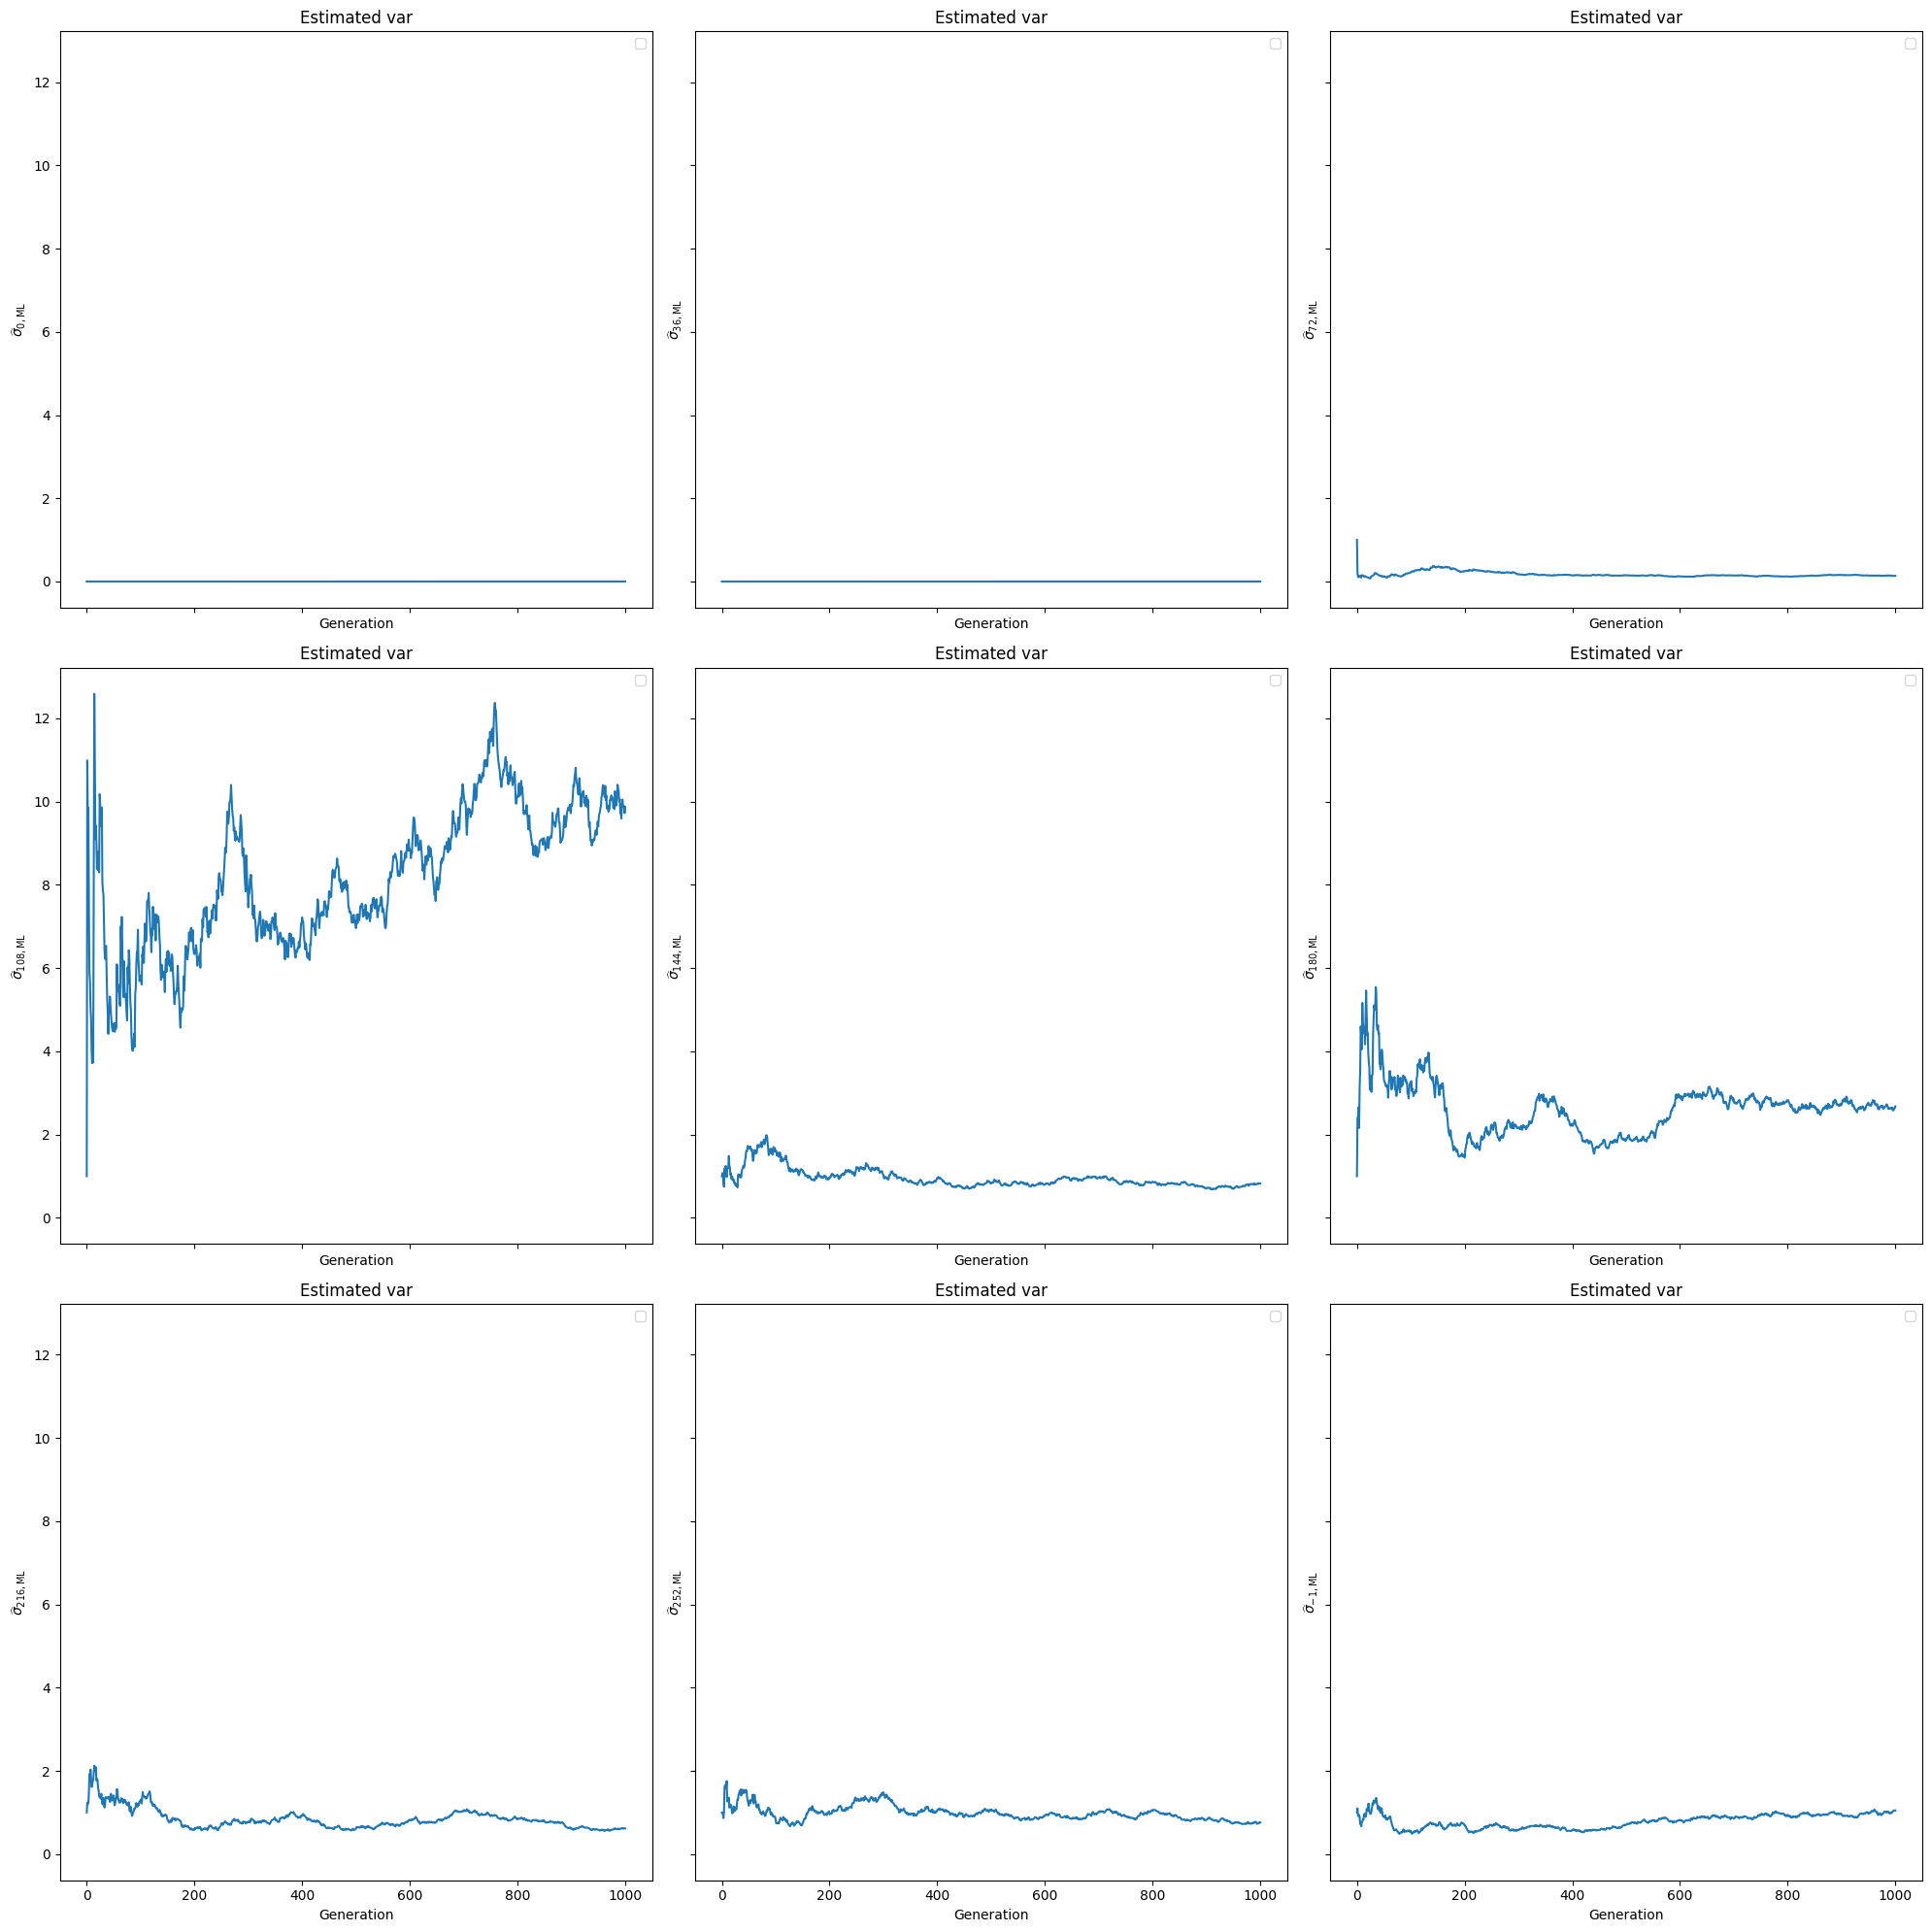

C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\1173561831.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


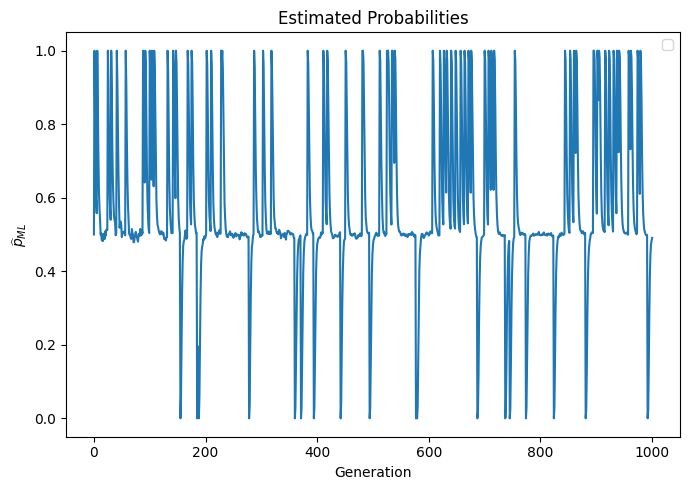

idx_list = [   0  100  200  300  400  500  600  700  800  900 1000]
mean = tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,

C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)


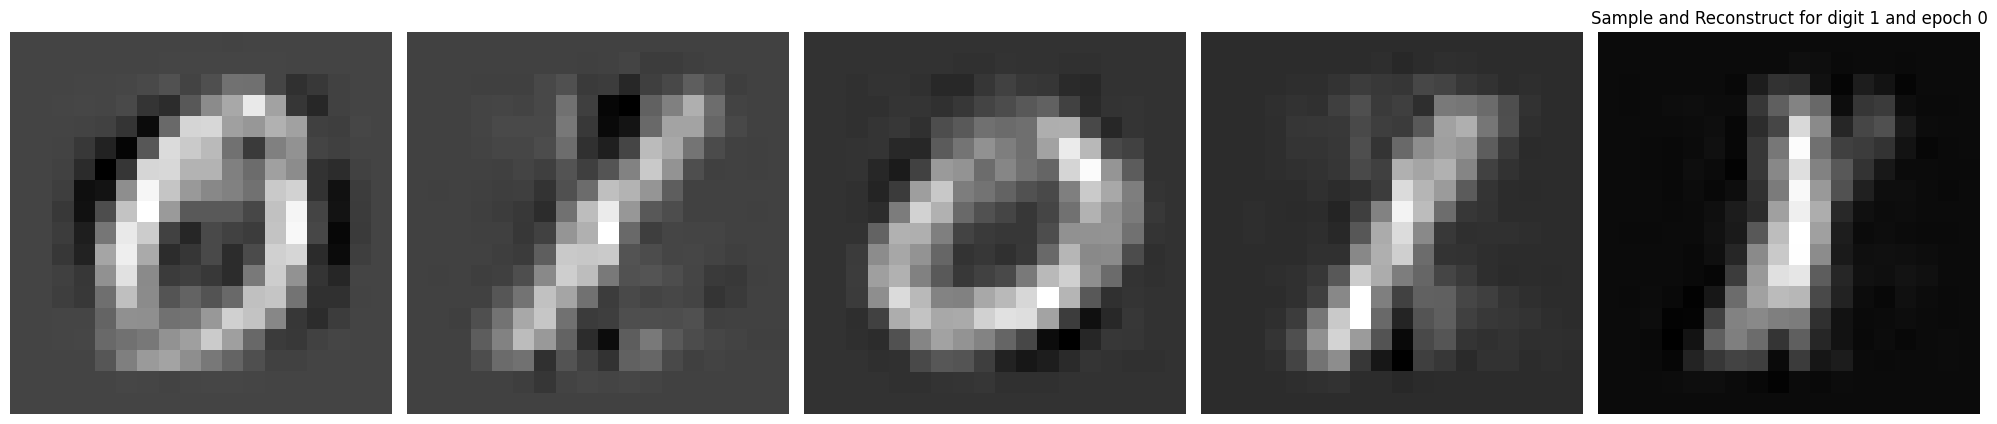

mean = tensor([ 9.9996, 10.0015,  9.9992,  9.9985, 10.0042,  9.9976, 10.0001,  9.9975,
         9.9980, 10.0008,  9.9985, 10.0008, 10.0007,  9.9974, 10.0001,  9.9990,
         9.9995, 10.0037, 10.0005, 10.0007, 10.0007, 10.0004,  9.9997, 10.0001,
         9.9968, 10.0012,  9.9984, 10.0002, 10.0018, 10.0000, 10.0018, 10.0018,
        10.0001, 10.0011,  9.9992, 10.0005, 10.0004,  9.9989,  9.9995, 10.0019,
        10.0012, 10.0017,  9.9984, 10.0000,  9.9989,  9.9991, 10.0007,  9.9989,
        10.0007,  9.9996,  9.9998,  9.9908, 10.0501,  9.6440, 10.0464, 10.1955,
         9.9167,  9.9502,  9.9234,  9.9321,  9.8449,  9.9963, 11.4894,  9.9941,
         8.9713,  9.8492,  9.8970,  9.9925,  9.9793, 10.0665,  9.9119,  9.9932,
         9.9836,  9.8945,  9.9632, 10.1068,  9.5511,  9.8844,  9.0990,  9.9739,
         9.8193,  9.7012,  9.9416, 10.0989, 10.1729,  9.6842, 10.1841, 10.5596,
        10.0291,  9.9266,  9.8303,  9.8137, 10.0211, 10.0434,  9.8314, 10.0835,
         9.5820,  9.8608,  9.5285

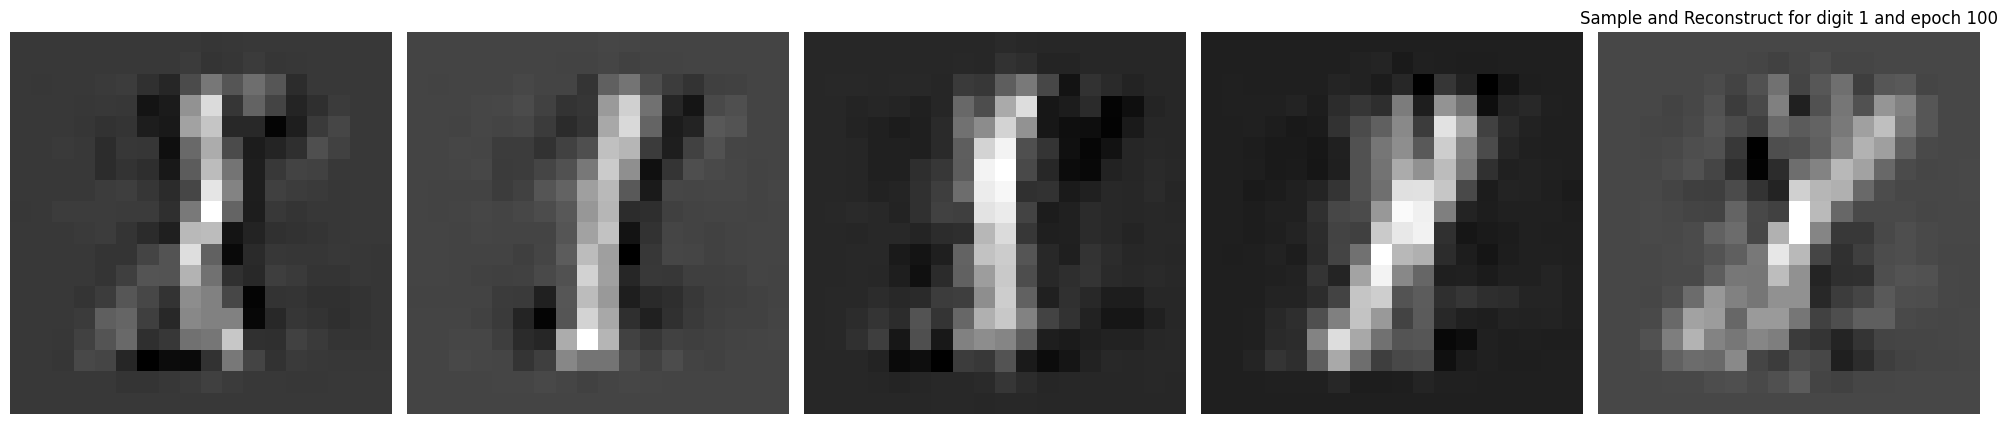

mean = tensor([10.0009, 10.0012, 10.0002,  9.9999, 10.0023,  9.9979, 10.0022,  9.9980,
        10.0000,  9.9987,  9.9968,  9.9997, 10.0005,  9.9985, 10.0006, 10.0021,
        10.0008, 10.0008, 10.0009, 10.0009, 10.0038,  9.9998,  9.9994,  9.9982,
         9.9999, 10.0008,  9.9984,  9.9993, 10.0008, 10.0014, 10.0008, 10.0003,
         9.9986, 10.0017,  9.9989, 10.0015,  9.9988, 10.0010,  9.9989, 10.0022,
         9.9993, 10.0010,  9.9976,  9.9997,  9.9995, 10.0006,  9.9994, 10.0025,
         9.9989,  9.9998,  9.9991, 10.0044, 10.0293,  9.9618, 10.0313, 10.4011,
         9.9007, 10.1556,  9.9446,  9.9077,  9.8994,  9.9975, 11.2054,  9.9239,
         9.4657,  9.8684,  9.9381,  9.9658,  9.7860,  9.7031,  9.8969,  9.9853,
        10.0667, 10.0627, 10.0443, 10.1893,  9.3972,  9.8261,  9.0715,  9.9512,
         9.8378,  9.9646,  9.9700, 10.0289, 10.1210,  9.2089, 10.0833, 10.3831,
        10.1269,  9.9622,  9.9223,  9.8658, 10.0054, 10.0180,  9.9688, 10.1031,
         9.7382,  9.9028, 10.0725

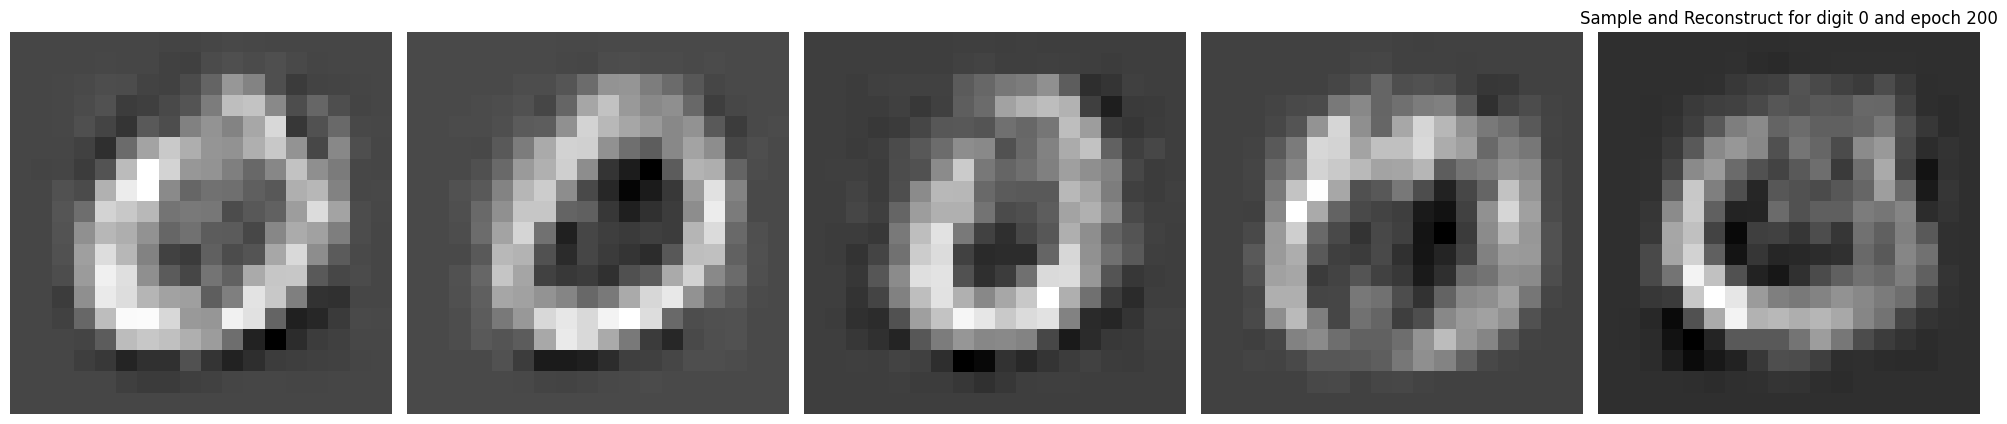

mean = tensor([ 9.9988, 10.0019, 10.0003,  9.9983, 10.0025,  9.9979, 10.0016,  9.9980,
         9.9990, 10.0017,  9.9972, 10.0018, 10.0002,  9.9994,  9.9983, 10.0006,
        10.0010, 10.0022, 10.0022, 10.0009, 10.0020, 10.0009,  9.9979,  9.9960,
         9.9963, 10.0030, 10.0029, 10.0004, 10.0014, 10.0018,  9.9998,  9.9986,
         9.9965,  9.9986,  9.9977, 10.0024,  9.9988, 10.0000,  9.9992, 10.0019,
         9.9962, 10.0008,  9.9981,  9.9985, 10.0007,  9.9987,  9.9975, 10.0042,
         9.9971,  9.9991, 10.0033, 10.0109,  9.9729,  9.9977, 10.0400, 10.2225,
         9.9056, 10.2156,  9.8584,  9.9306,  9.7186,  9.9636, 11.2251, 10.0264,
        10.0061,  9.8875,  9.9325,  9.9759, 10.4708,  9.6151,  9.9694, 10.0082,
        10.0797,  9.9186,  9.9408, 10.2386,  9.2754,  9.8463,  9.3732,  9.9391,
         9.8325,  9.8283,  9.8829, 10.1935, 10.0164,  9.5103, 10.0968, 10.6276,
        10.0691, 10.0287, 10.0484,  9.9901,  9.9559,  9.9922,  9.9916,  9.9926,
         9.6591,  9.9508,  9.9979

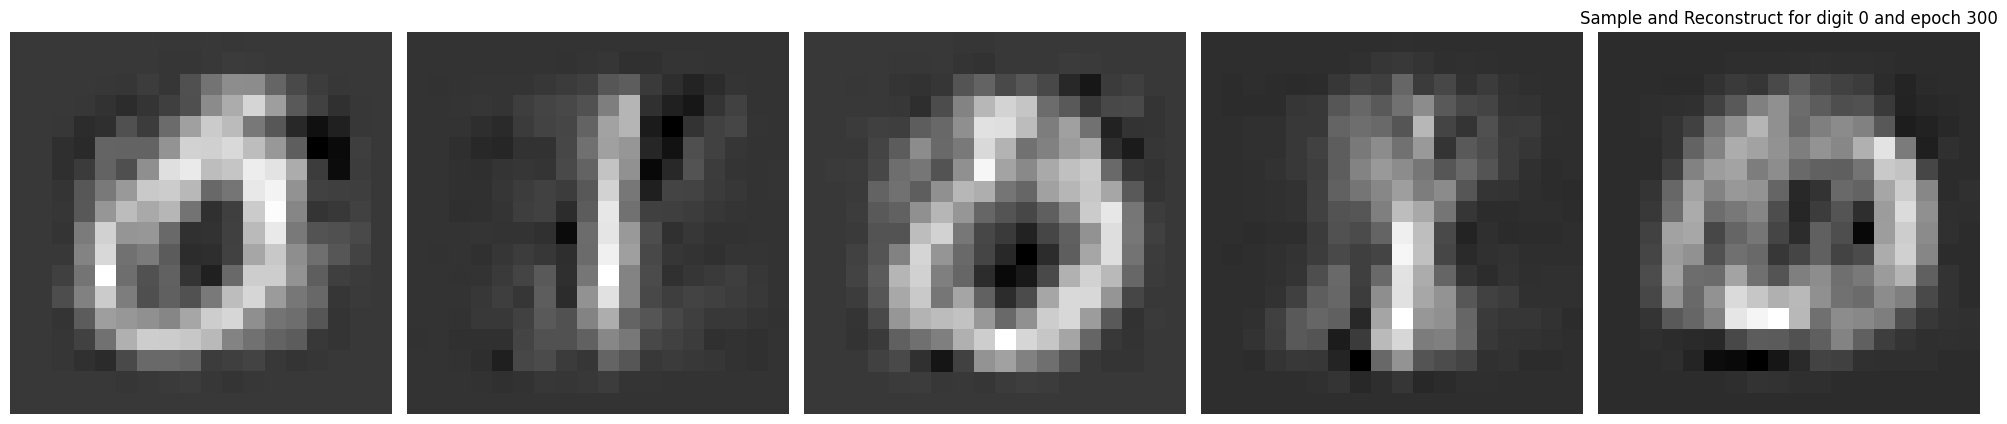

mean = tensor([ 9.9999,  9.9995,  9.9978,  9.9999, 10.0021,  9.9965, 10.0011,  9.9996,
         9.9999, 10.0020,  9.9976,  9.9997,  9.9988, 10.0011,  9.9970, 10.0005,
         9.9995, 10.0015, 10.0020, 10.0011,  9.9994, 10.0019,  9.9997,  9.9961,
         9.9957, 10.0009, 10.0008, 10.0024, 10.0011, 10.0049,  9.9991,  9.9972,
         9.9999, 10.0036,  9.9997,  9.9977,  9.9985, 10.0005,  9.9975, 10.0023,
         9.9950,  9.9986,  9.9970,  9.9984,  9.9978,  9.9959,  9.9972, 10.0027,
         9.9942,  9.9972, 10.0030, 10.0054,  9.9710,  9.9186, 10.0308, 10.0871,
         9.9921, 10.1981,  9.9002,  9.8564,  9.8882,  9.8773, 10.8881, 10.0622,
        10.2092,  9.8389,  9.8834,  9.9820, 10.1291,  9.9132,  9.9648, 10.0235,
        10.1367, 10.0785, 10.1279, 10.1777,  9.3370,  9.8721,  9.2825,  9.9376,
         9.7748,  9.5261,  9.8946, 10.1607, 10.0610,  9.8673, 10.1525, 10.5537,
        10.1491, 10.1301,  9.9803,  9.9109,  9.9281, 10.1544, 10.0161, 10.0537,
         9.7206,  9.8980,  9.6690

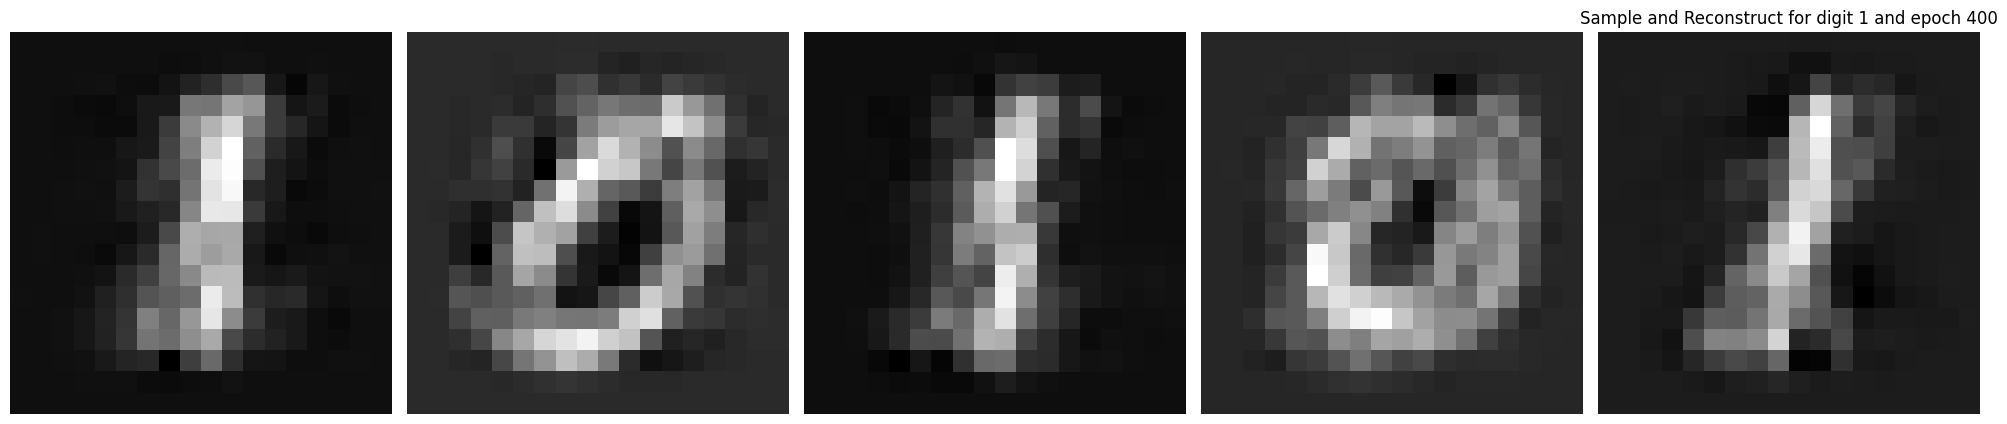

mean = tensor([10.0018, 10.0007,  9.9990, 10.0013, 10.0029,  9.9958, 10.0002,  9.9966,
        10.0037, 10.0000,  9.9991, 10.0028, 10.0001,  9.9991,  9.9960, 10.0003,
         9.9988, 10.0036, 10.0016, 10.0005, 10.0016, 10.0023, 10.0015,  9.9980,
         9.9967,  9.9989, 10.0014, 10.0023, 10.0035, 10.0054, 10.0012,  9.9977,
         9.9962, 10.0029,  9.9986, 10.0002,  9.9949,  9.9979,  9.9953, 10.0002,
         9.9982,  9.9988,  9.9950, 10.0004,  9.9992,  9.9949,  9.9965, 10.0038,
         9.9932,  9.9971, 10.0041, 10.0094,  9.9653, 10.0760,  9.9878, 10.0965,
         9.9015, 10.2557,  9.9138,  9.8713,  9.8274,  9.9987, 11.2085, 10.0773,
        10.9302,  9.7031,  9.8399,  9.9992, 10.4474, 10.0589, 10.0143, 10.0007,
        10.1041,  9.9802, 10.1868, 10.1250,  9.4634,  9.8932,  9.5927,  9.9709,
         9.9255,  9.4328,  9.9183, 10.0499, 10.0994,  9.6017, 10.3825, 10.2571,
        10.1602, 10.1460, 10.1236,  9.7898,  9.9690, 10.1734,  9.9648,  9.9563,
         9.7022,  9.9596,  9.9144

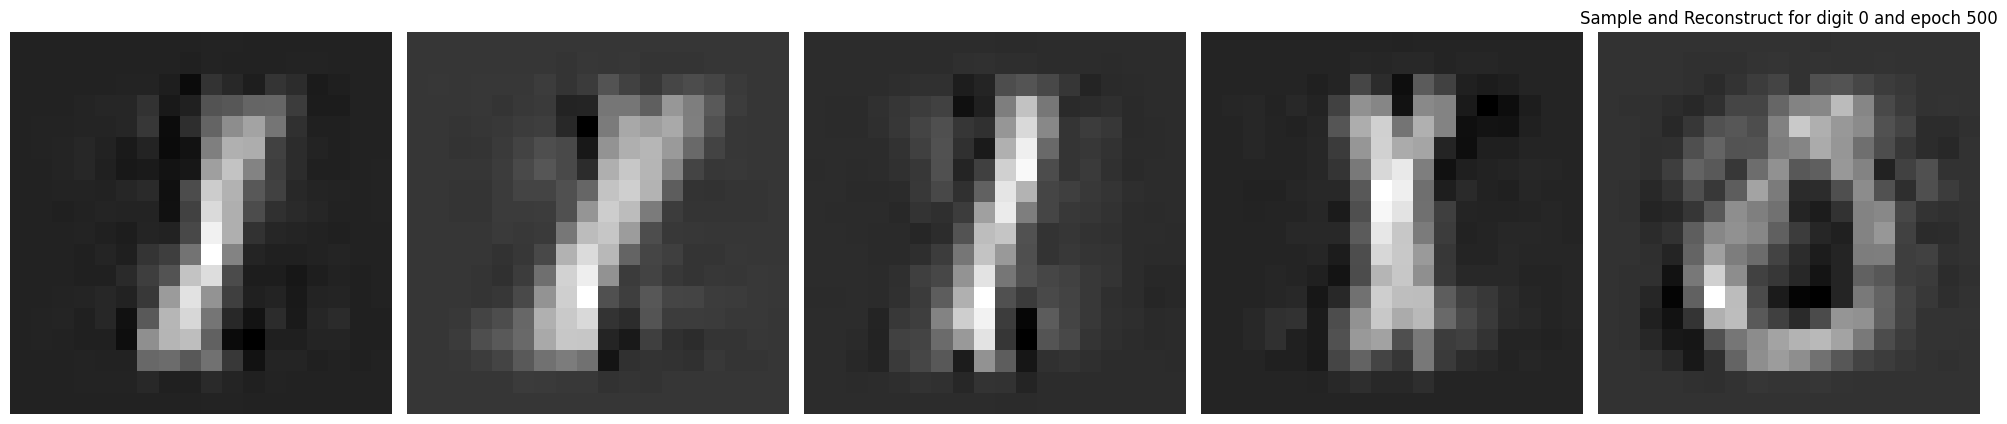

mean = tensor([10.0027, 10.0024, 10.0000,  9.9981,  9.9999,  9.9957,  9.9989,  9.9927,
        10.0029, 10.0000, 10.0010, 10.0003,  9.9999, 10.0002,  9.9947, 10.0017,
         9.9981, 10.0000, 10.0049,  9.9981, 10.0011, 10.0013, 10.0029,  9.9996,
        10.0012,  9.9988,  9.9987, 10.0006, 10.0069, 10.0028, 10.0011,  9.9965,
         9.9951, 10.0000,  9.9978,  9.9978,  9.9995,  9.9994,  9.9939, 10.0006,
         9.9985, 10.0003,  9.9985, 10.0005,  9.9983,  9.9961,  9.9957, 10.0014,
         9.9932,  9.9951, 10.0015, 10.0155,  9.9601, 10.1467,  9.9076, 10.1674,
         9.9059, 10.3235,  9.8713,  9.8656,  9.8217,  9.9926, 10.4784, 10.0383,
        11.1719,  9.4295,  9.8072,  9.9896, 10.2835, 10.1424, 10.0520, 10.0063,
        10.1212,  9.9361, 10.1658, 10.2197,  9.5992,  9.8508,  9.6130,  9.9731,
        10.0235,  9.1366,  9.9867, 10.1624, 10.0254,  9.6678, 10.2116, 10.3115,
        10.1488, 10.1101, 10.1152,  9.8621,  9.9949, 10.1571,  9.9812,  9.9356,
         9.7240,  9.9555,  9.8388

  1%|          | 6/1000 [5:00:35<829:57:58, 3005.91s/it]


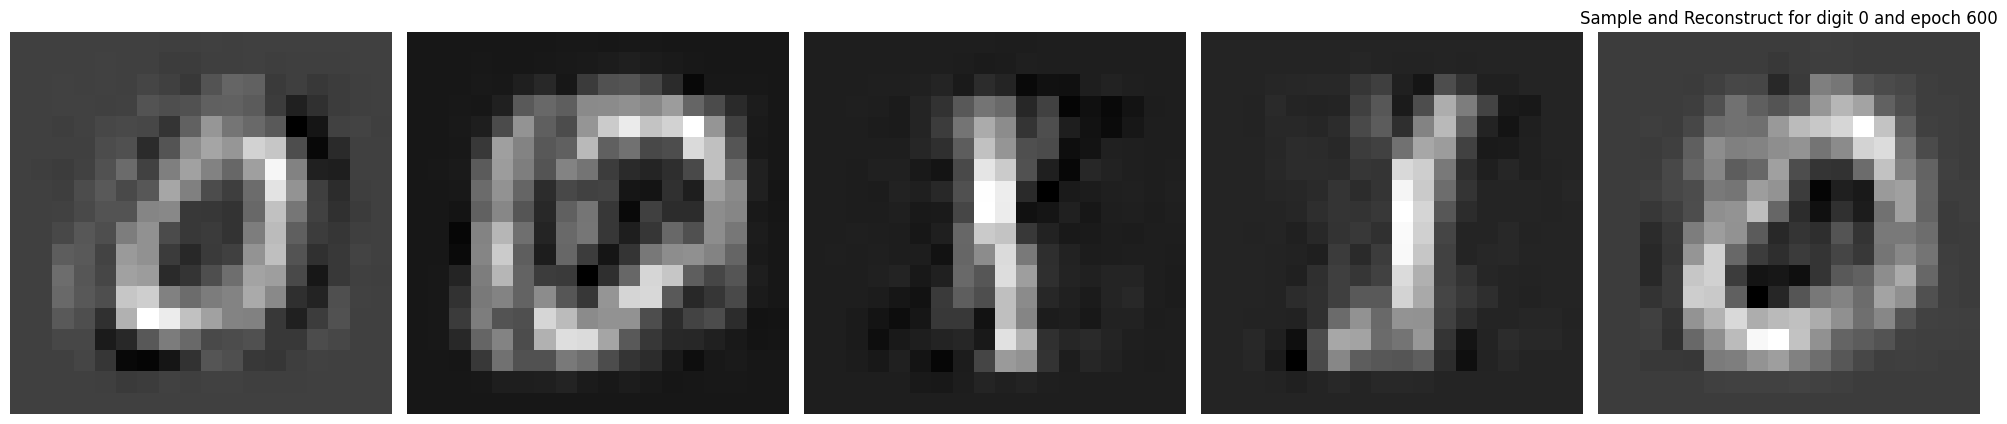

mean = tensor([10.0045,  9.9984,  9.9956,  9.9987,  9.9941,  9.9972,  9.9983,  9.9955,
        10.0027,  9.9990, 10.0024, 10.0003,  9.9995,  9.9990,  9.9975, 10.0014,
         9.9966, 10.0011, 10.0073,  9.9981, 10.0043,  9.9997, 10.0052,  9.9987,
         9.9973,  9.9995,  9.9999, 10.0021, 10.0092, 10.0021,  9.9988,  9.9974,
         9.9971, 10.0001,  9.9953,  9.9968,  9.9997, 10.0009,  9.9973, 10.0022,
         9.9966,  9.9983, 10.0000, 10.0016,  9.9990,  9.9950,  9.9967, 10.0042,
         9.9966,  9.9958, 10.0012,  9.9837,  9.9584, 10.1565,  9.9045, 10.0744,
         9.9065, 10.2946,  9.8512,  9.8385,  9.9627, 10.0630, 10.0184, 10.0344,
        11.7962,  9.4425,  9.8511,  9.9734, 10.3585, 10.2088, 10.0411,  9.9864,
        10.1717,  9.9436, 10.3422, 10.1866,  9.5766,  9.8796,  9.4982, 10.0077,
         9.9620,  9.2361, 10.0012, 10.1945,  9.9704,  9.6474, 10.1519, 10.0123,
        10.2337, 10.0590, 10.0057,  9.7305, 10.0157, 10.1074,  9.8876,  9.9775,
         9.7066,  9.9213,  9.5786

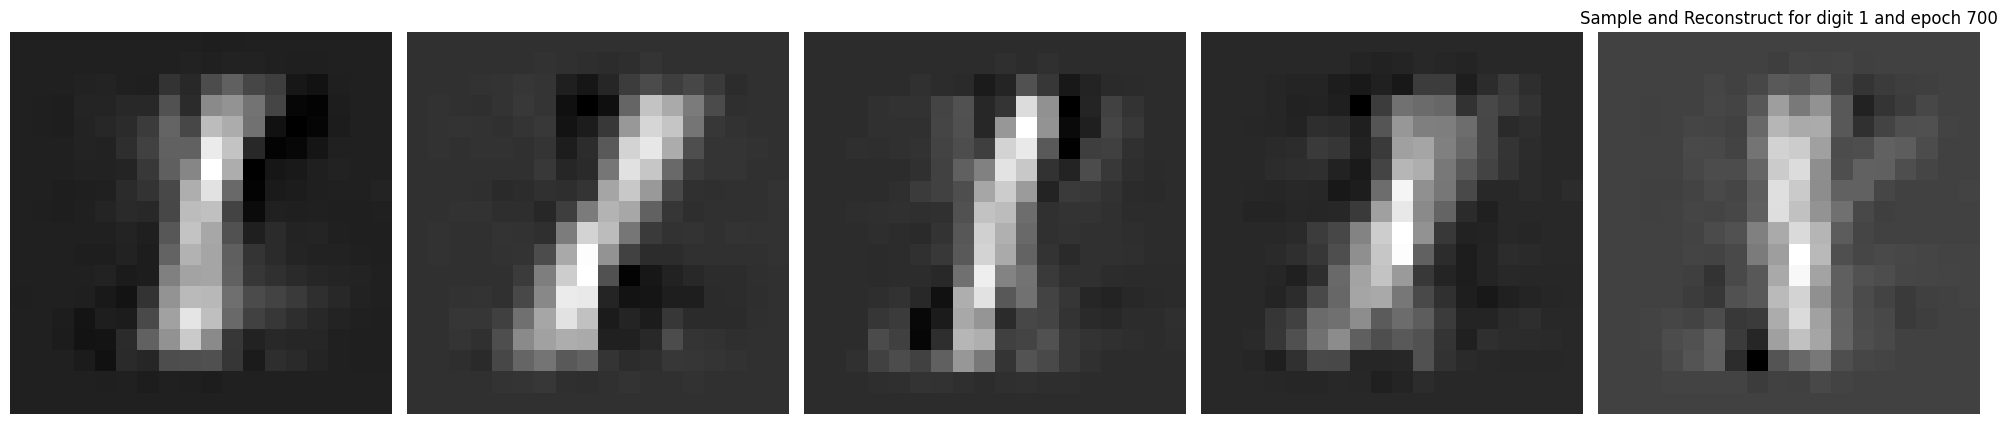

mean = tensor([10.0082,  9.9950,  9.9904,  9.9973,  9.9960,  9.9973, 10.0009,  9.9966,
        10.0020, 10.0001, 10.0047,  9.9977, 10.0023, 10.0023,  9.9982, 10.0015,
        10.0008, 10.0013, 10.0038,  9.9969,  9.9999, 10.0001, 10.0048,  9.9989,
         9.9979, 10.0002,  9.9999,  9.9997, 10.0068, 10.0048,  9.9983,  9.9974,
        10.0001, 10.0010,  9.9934,  9.9960, 10.0010, 10.0005,  9.9967, 10.0023,
         9.9966,  9.9984, 10.0022, 10.0045,  9.9992,  9.9940,  9.9993, 10.0035,
         9.9978,  9.9958,  9.9988,  9.9807,  9.9618, 10.1947,  9.8939,  9.9918,
        10.0434, 10.2242,  9.8445,  9.8451, 10.0407, 10.1032,  9.8018, 10.0576,
        10.4289,  9.3068,  9.8857,  9.9835, 10.2545, 10.2244, 10.0787,  9.9663,
        10.2390,  9.8764, 10.2478, 10.1741,  9.4748,  9.8246,  9.4894, 10.0009,
         9.8663,  9.5437,  9.9965, 10.2028,  9.9510,  9.9879, 10.1240, 10.1048,
        10.2097, 10.0342,  9.9416,  9.7428, 10.0201, 10.1100,  9.9061,  9.9746,
         9.8101,  9.9317,  9.8615

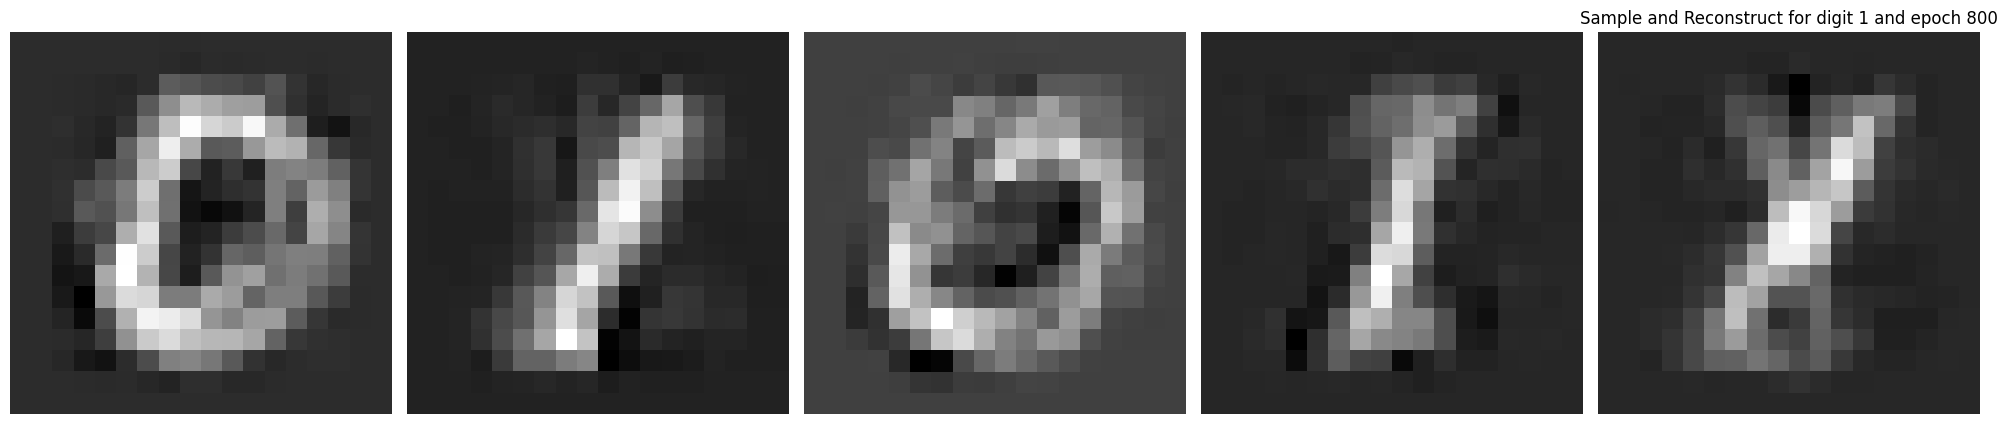

mean = tensor([10.0052,  9.9964,  9.9916,  9.9989,  9.9954,  9.9974, 10.0033,  9.9953,
        10.0022, 10.0018, 10.0062,  9.9944, 10.0005, 10.0015, 10.0008, 10.0002,
         9.9993, 10.0010, 10.0033,  9.9981, 10.0018, 10.0012, 10.0041,  9.9978,
        10.0019, 10.0042, 10.0016, 10.0001, 10.0100, 10.0035,  9.9995,  9.9995,
         9.9982,  9.9983,  9.9924,  9.9973, 10.0004,  9.9975,  9.9931, 10.0003,
         9.9945,  9.9961,  9.9978, 10.0087, 10.0003,  9.9930,  9.9988, 10.0037,
         9.9983,  9.9956,  9.9972,  9.9711,  9.9667, 10.0906,  9.8456,  9.9654,
        10.0154, 10.0861,  9.8506,  9.8663, 10.0538, 10.1469,  9.0660, 10.0006,
        10.3774,  9.4631,  9.9166,  9.9850, 10.2637, 10.2729, 10.0622,  9.9750,
        10.2387,  9.8459, 10.2615, 10.1783,  9.3825,  9.8084,  9.6109,  9.9886,
        10.0042,  9.6206,  9.9785, 10.1521,  9.9723, 10.1964, 10.0576,  9.9763,
        10.2787, 10.0003,  9.8411,  9.7965,  9.9766, 10.1275,  9.9095,  9.9803,
         9.8056, 10.0458,  9.7246

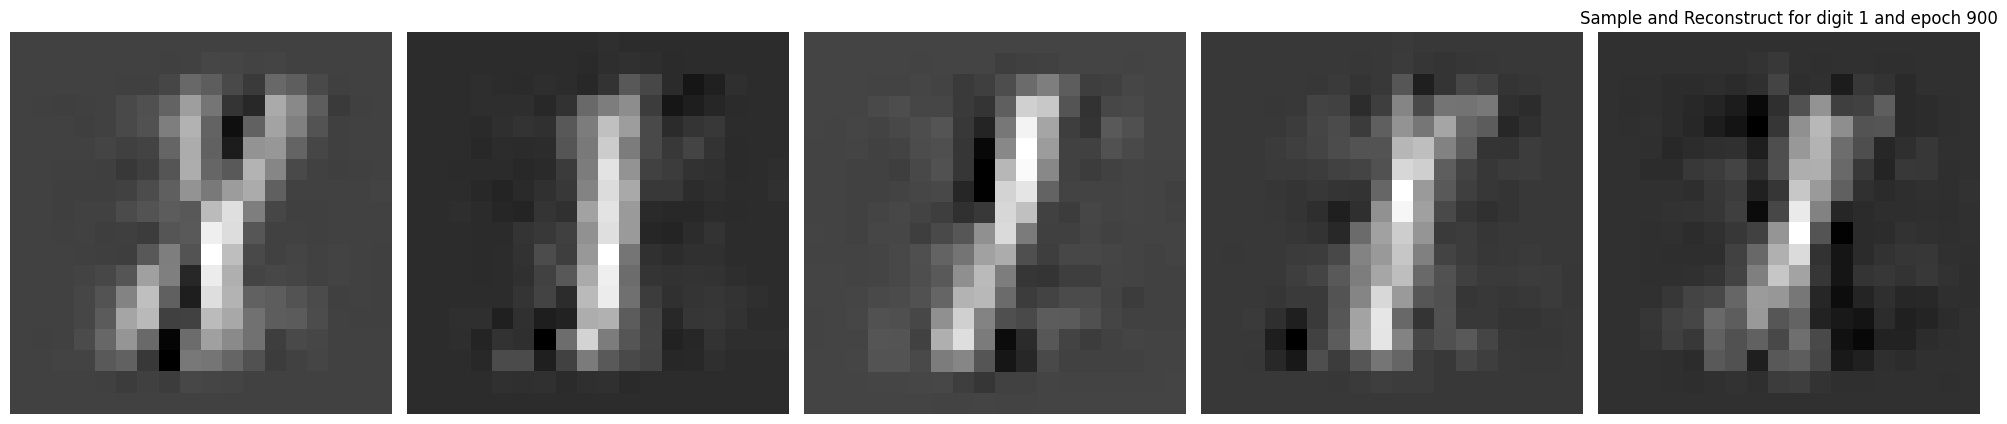

mean = tensor([10.0047,  9.9961,  9.9965,  9.9969,  9.9968,  9.9953, 10.0003,  9.9953,
        10.0010, 10.0019, 10.0060,  9.9970, 10.0006, 10.0034, 10.0010, 10.0014,
        10.0007, 10.0027, 10.0072,  9.9969,  9.9959,  9.9995, 10.0044,  9.9968,
        10.0028, 10.0040, 10.0037,  9.9998, 10.0087, 10.0043,  9.9983, 10.0009,
         9.9980,  9.9992,  9.9939,  9.9999, 10.0002,  9.9976,  9.9910,  9.9995,
         9.9962,  9.9952,  9.9983, 10.0062, 10.0015,  9.9976, 10.0003, 10.0043,
         9.9947,  9.9966,  9.9959,  9.9856,  9.9766, 10.0230,  9.8905, 10.0892,
        10.0262, 10.1217,  9.8423,  9.8917, 10.0859, 10.1051,  9.7513,  9.9633,
        10.2785,  9.3647,  9.8948,  9.9491, 10.3515, 10.3692, 10.0616,  9.9683,
        10.2462,  9.7263, 10.2885, 10.2759,  9.5457,  9.8330,  9.7310, 10.0123,
        10.0994,  9.6430, 10.0436, 10.2048, 10.0580, 10.4287, 10.2458,  9.9982,
        10.4392,  9.9492,  9.8287,  9.7867, 10.0197, 10.0883,  9.8842,  9.9131,
         9.7857,  9.9819,  9.8382

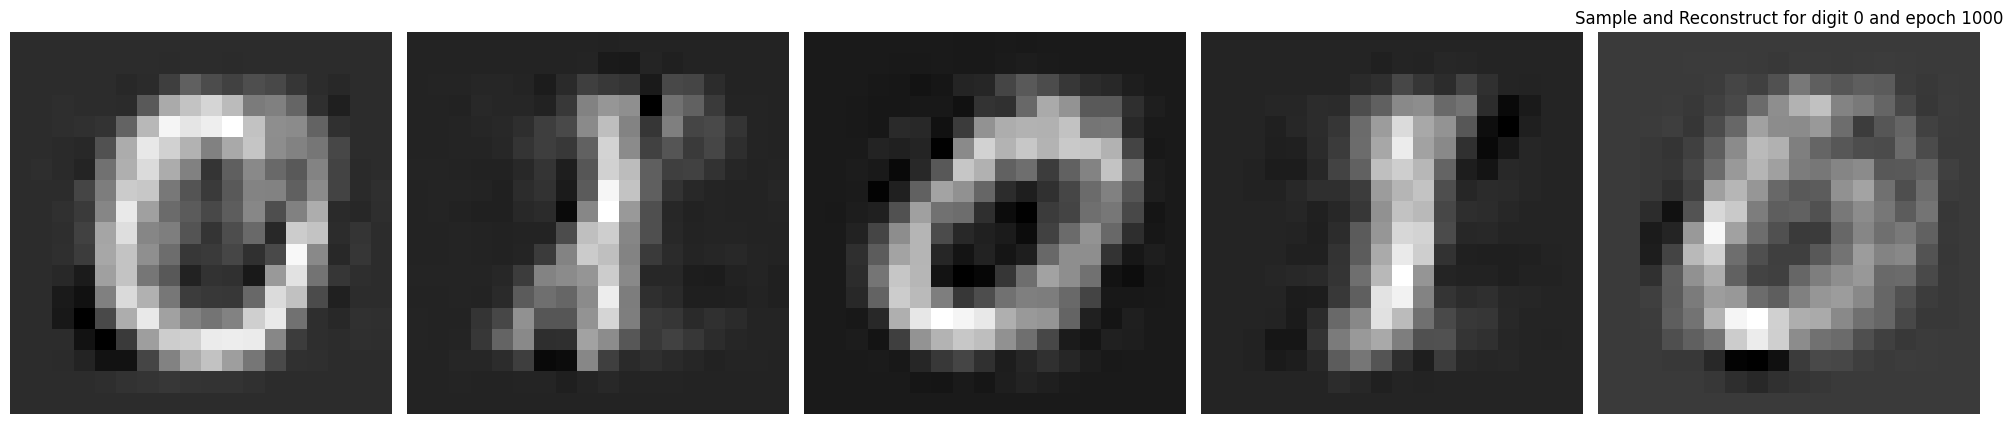

100%|██████████| 1000/1000 [4:59:50<00:00, 17.99s/it]


In [49]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim = 9
num_trajectories = 1
num_generations = 1000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_9 = shuffle(np.concatenate((final_0_9[:num_0], final_1_9[:num_1]), axis=0))
x_data_49 = shuffle(np.concatenate((final_0_49[:num_0], final_1_49[:num_1]), axis=0))
x_data_324 = shuffle(np.concatenate((final_0_324[:num_0], final_1_324[:num_1]), axis=0))

# # Convert numpy arrays to torch tensors
# final_var_9 = final_cov_9.diagonal()
# mu_0_vals = [torch.tensor(final_mean_9, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_9, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_9, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, (avg_mean_9, diff_mean_9, final_mean_9), inv_0_9, inv_1_9, new_shape)

# # repeat for 49
# dim_49 = 49
# final_var_49 = final_cov_49.diagonal()
# mu_0_vals = [torch.tensor(final_mean_49, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_49, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_49, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_49, device, (avg_mean_49, diff_mean_49, final_mean_49), inv_0_49, inv_1_49, new_shape_2)

# repeat for 324
dim_324 = 324
final_var_324 = final_cov_324.diagonal()
mu_0_vals = [torch.tensor(final_mean_324, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_324, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_324, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_324, device, (avg_mean_324, diff_mean_324, final_mean_324), inv_0_324, inv_1_324, new_shape_3, add_old_data = 10)

In [50]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim = 9
num_trajectories = 1
num_generations = 1000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_9 = shuffle(np.concatenate((final_0_9[:num_0], final_1_9[:num_1]), axis=0))
x_data_49 = shuffle(np.concatenate((final_0_49[:num_0], final_1_49[:num_1]), axis=0))
x_data_324 = shuffle(np.concatenate((final_0_324[:num_0], final_1_324[:num_1]), axis=0))

# # Convert numpy arrays to torch tensors
# final_var_9 = final_cov_9.diagonal()
# mu_0_vals = [torch.tensor(final_mean_9, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_9, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_9, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, (avg_mean_9, diff_mean_9, final_mean_9), inv_0_9, inv_1_9, new_shape)

# # repeat for 49
# dim_49 = 49
# final_var_49 = final_cov_49.diagonal()
# mu_0_vals = [torch.tensor(final_mean_49, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_49, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_49, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_49, device, (avg_mean_49, diff_mean_49, final_mean_49), inv_0_49, inv_1_49, new_shape_2)

# repeat for 324
dim_324 = 324
final_var_324 = final_cov_324.diagonal()
mu_0_vals = [torch.tensor(final_mean_324, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_324, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_324, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_324, device, (avg_mean_324, diff_mean_324, final_mean_324), inv_0_324, inv_1_324, new_shape_3, add_old_data = 40)

  0%|          | 0/1000 [00:00<?, ?it/s]

Generation 1


  0%|          | 1/1000 [00:02<42:30,  2.55s/it]C:\Users\shrey\AppData\Local\Temp\ipykernel_28704\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)
 72%|███████▏  | 718/1000 [9:32:27<7:33:33, 96.50s/it]  

KeyboardInterrupt: 

  0%|          | 0/3000 [00:00<?, ?it/s]

Generation 1


  0%|          | 1/3000 [00:02<2:23:04,  2.86s/it]C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)
100%|██████████| 3000/3000 [3:10:03<00:00,  5.08s/it]  C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\1173561831.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


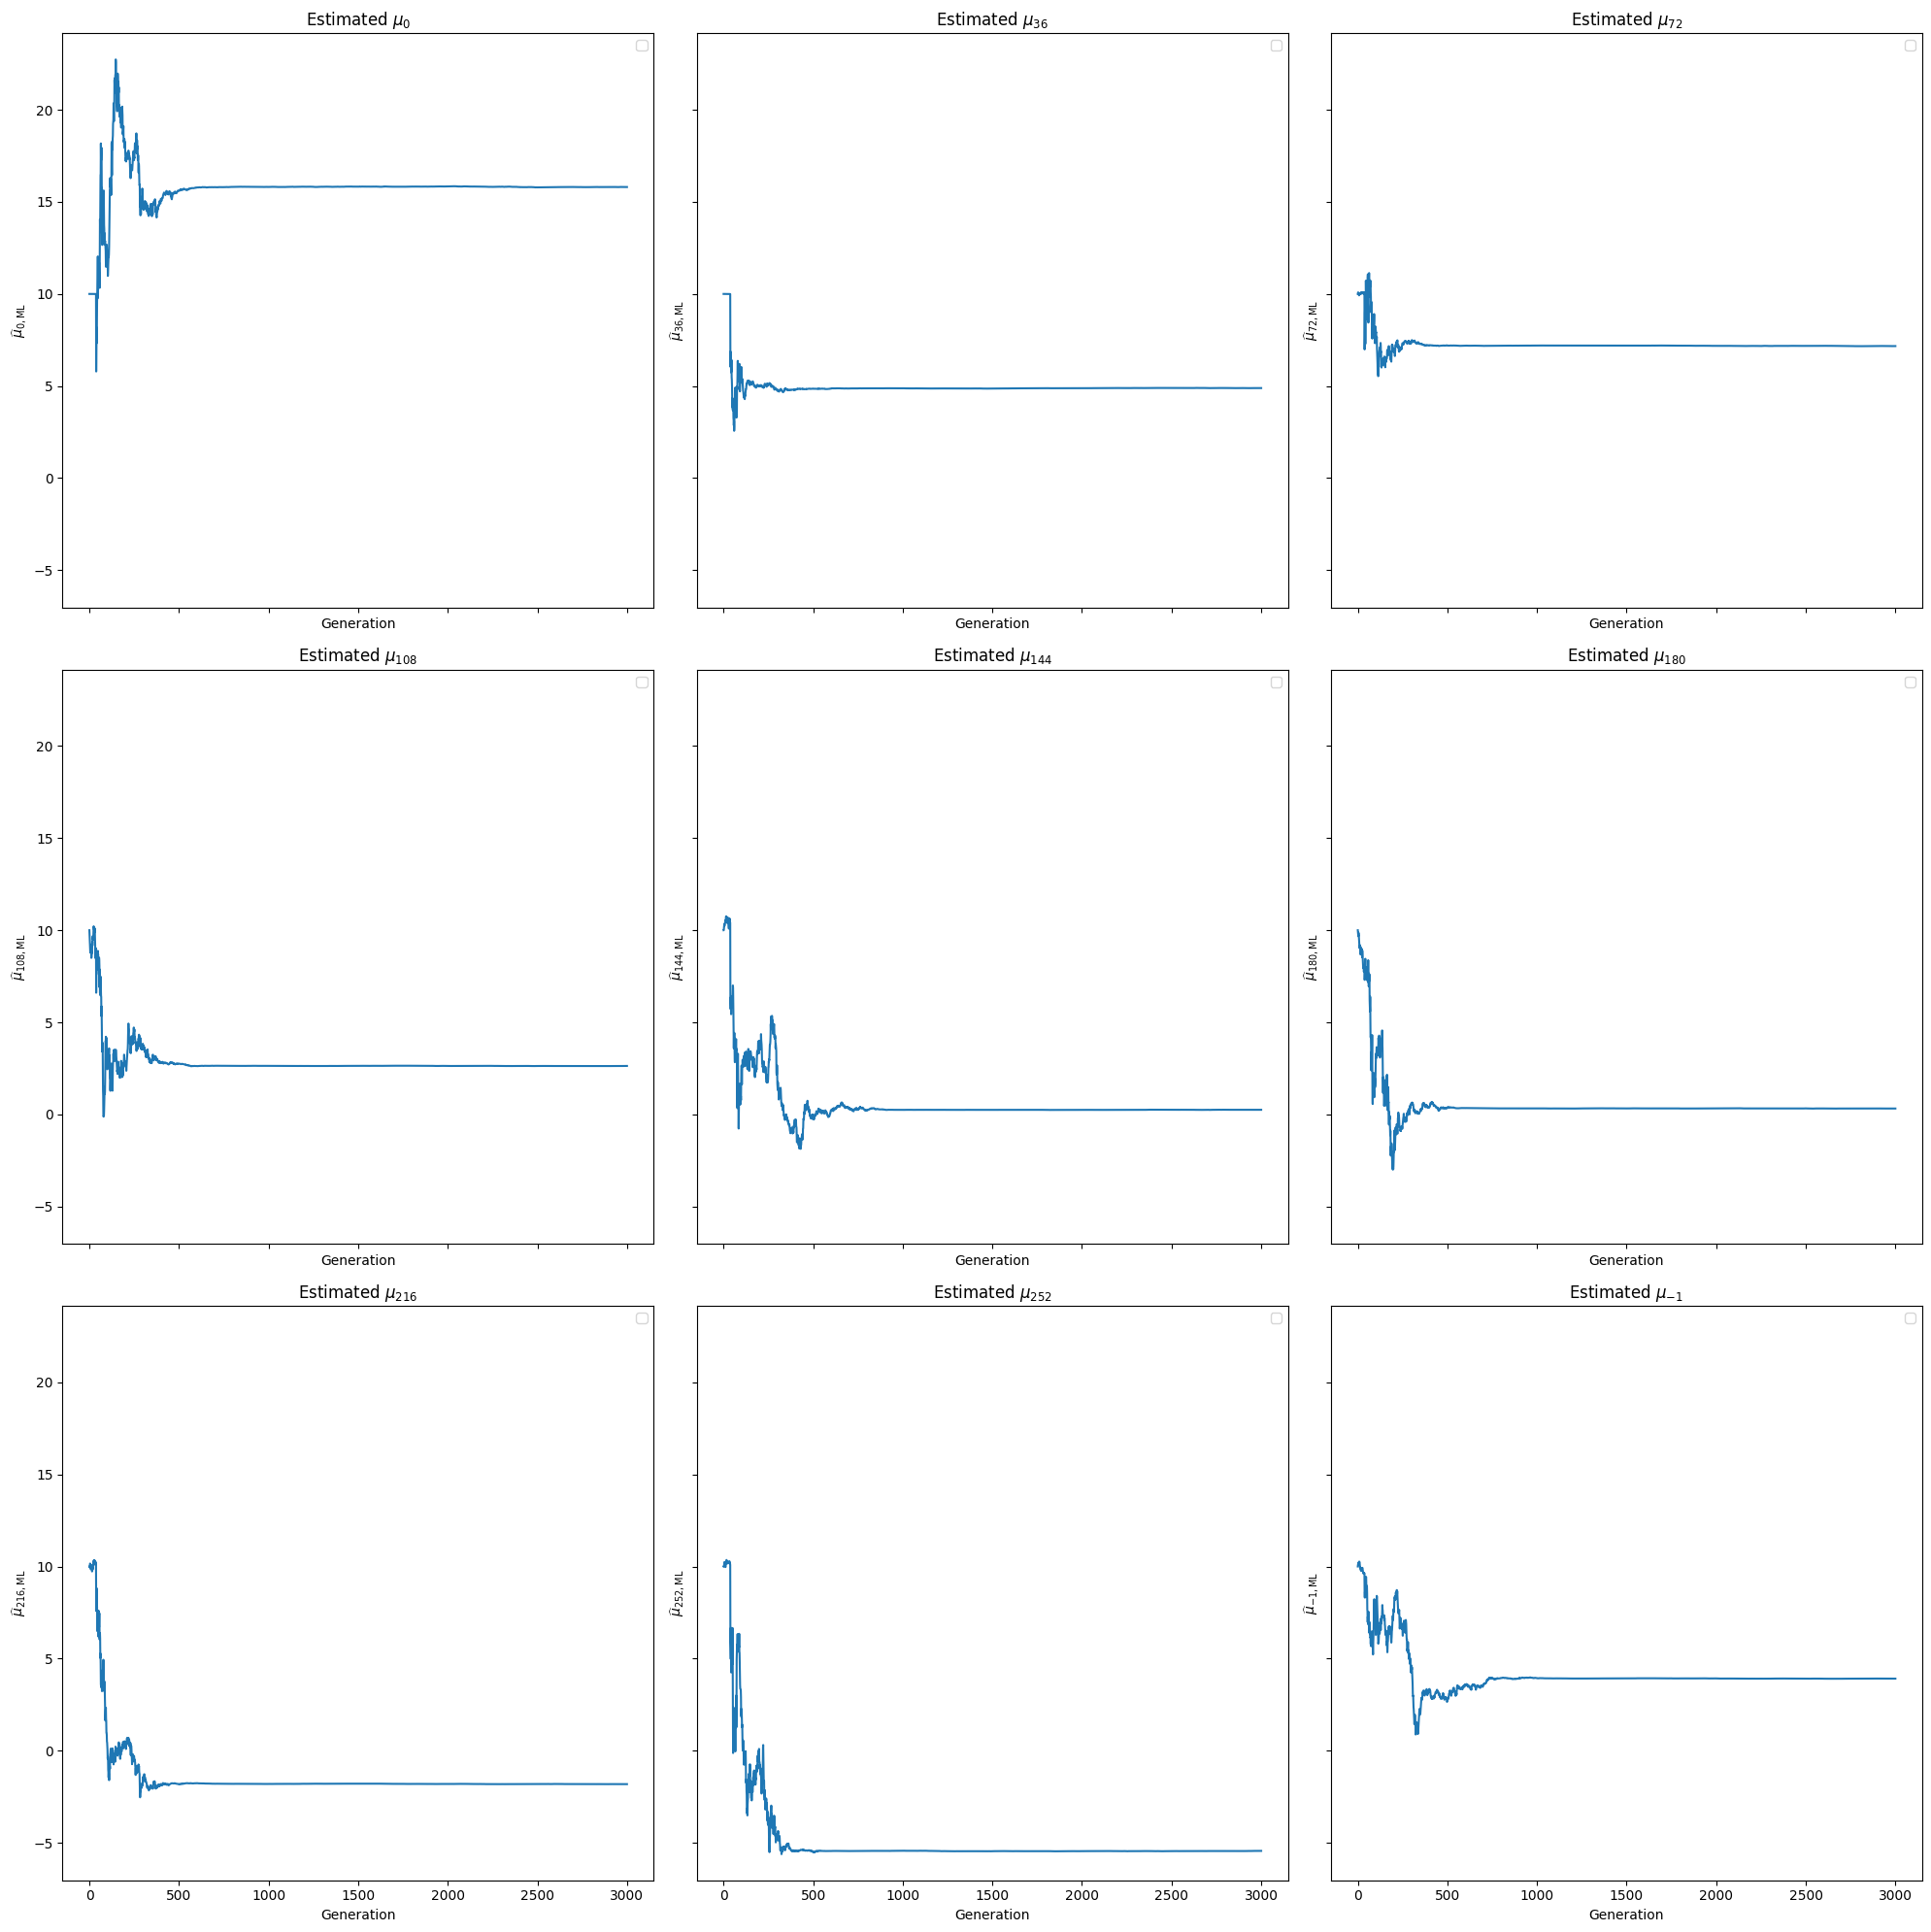

C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\1173561831.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

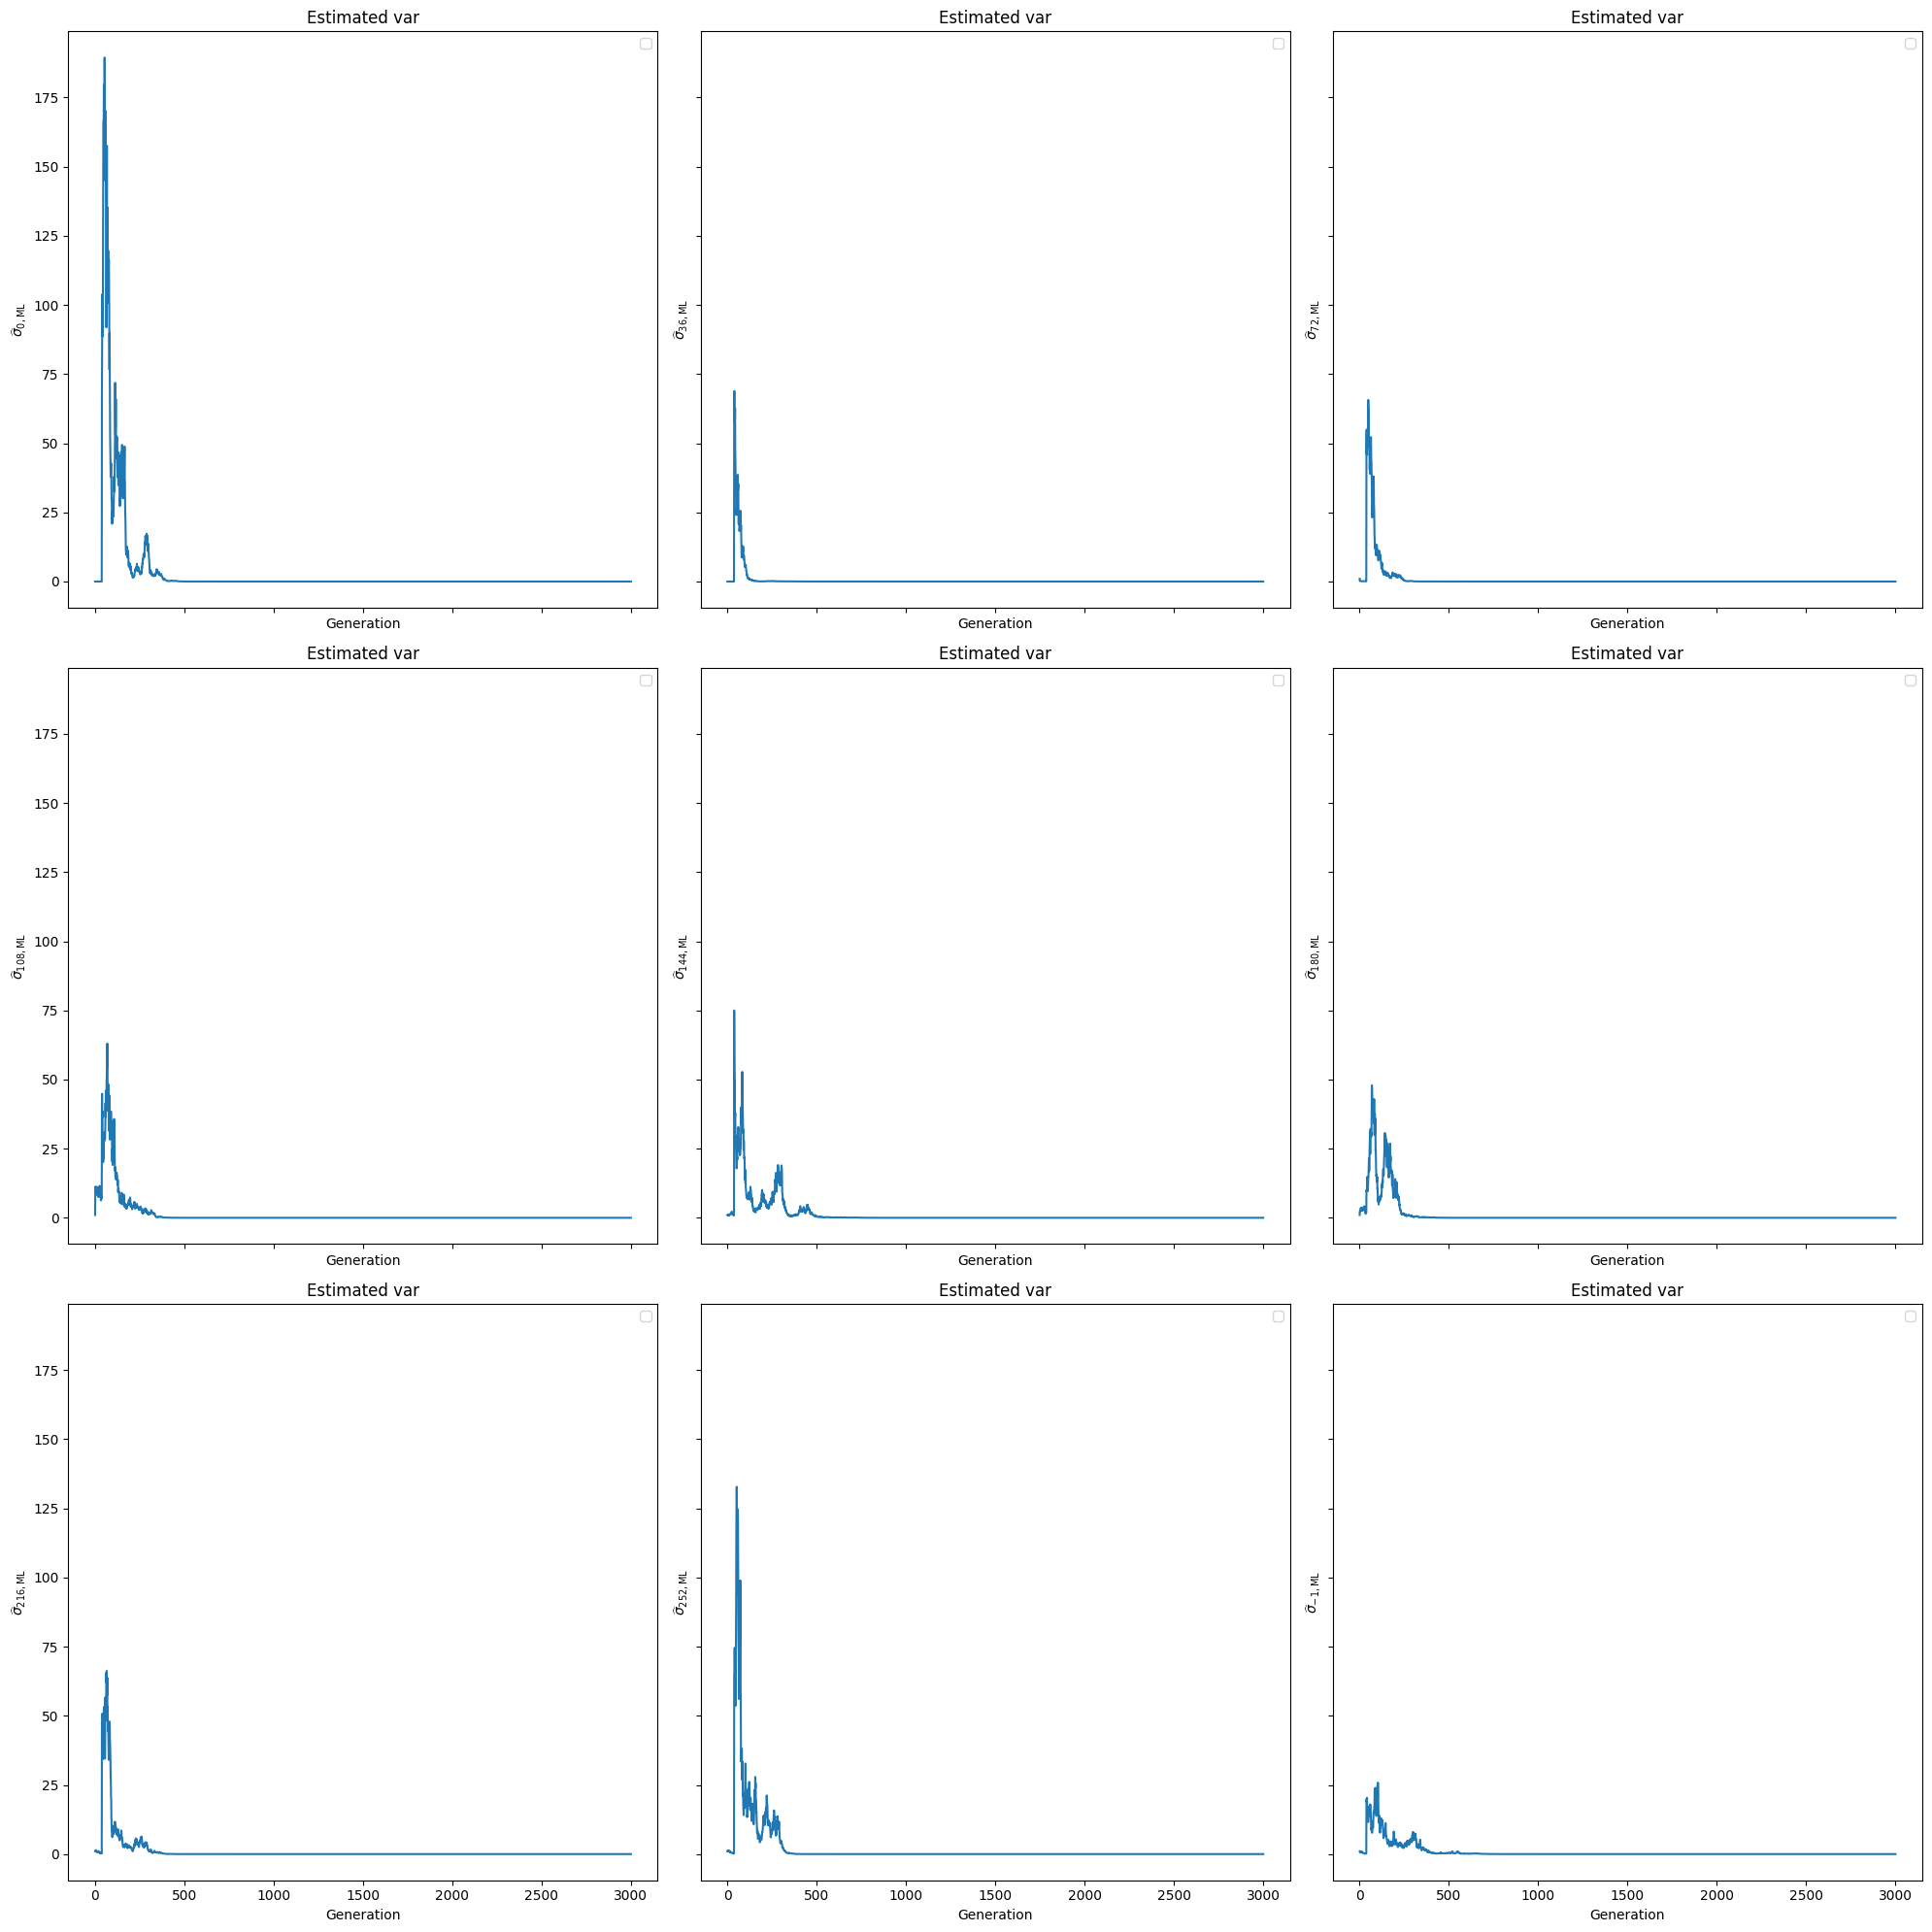

C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\1173561831.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


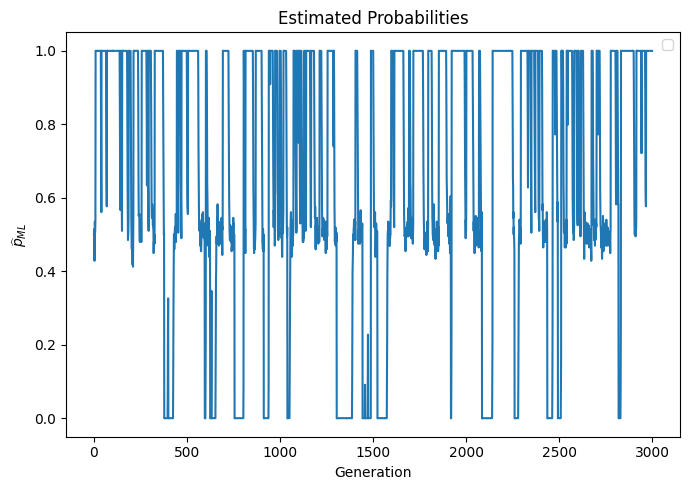

idx_list = [   0  300  600  900 1200 1500 1800 2100 2400 2700 3000]
mean = tensor([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,

C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)


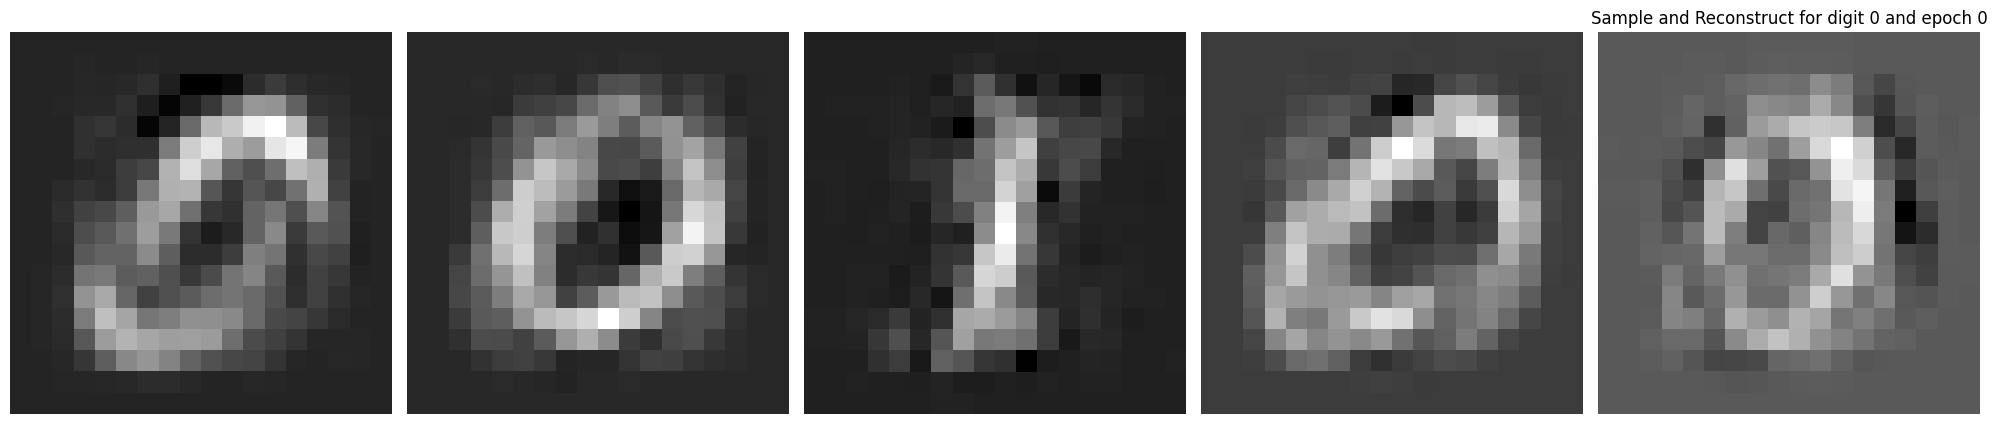

mean = tensor([ 14.7585,   9.2749,  15.5055,   7.0104,   8.1883,   6.6515,   6.1897,
          7.0355,  -1.2807,   7.2206,   5.3909,  10.9648,   9.3794,  -0.8252,
          2.9085,  -0.5284,   3.6627,   6.6329,   6.5907,   8.6650,   1.4287,
         11.5644,   5.6584,   3.2562,  17.9063,  12.2906,   9.3318,  -3.7958,
         -7.4483,  13.3932,  17.7343,   8.4295,   1.5927,   8.4544,  -1.5668,
         -1.5104,   4.7933,   6.9954,  -1.4296,   2.9479,  25.6417,  16.3765,
         -1.9242,   1.0998,   4.2980,   6.0804,  13.9169,   0.8302,   0.3024,
          5.9714,   1.3226,  10.7456,   8.7575,   9.6554,   6.5834,   2.9341,
         10.3475,   5.5001,   8.8098,   9.7232,   7.7612,   4.4371,  11.8691,
          7.5275,   9.2322,   2.6283,   4.6542,   3.9247,   6.8140,   7.1241,
          6.7547,   5.0139,   7.4209,  12.4016,  11.1434,   6.7162,   1.6970,
          6.6978,  22.4351,   2.2216,   2.9600,  18.1310,  10.0441,   0.6759,
          6.1114,  14.1801,  11.6055, -12.8807,  10.6303,

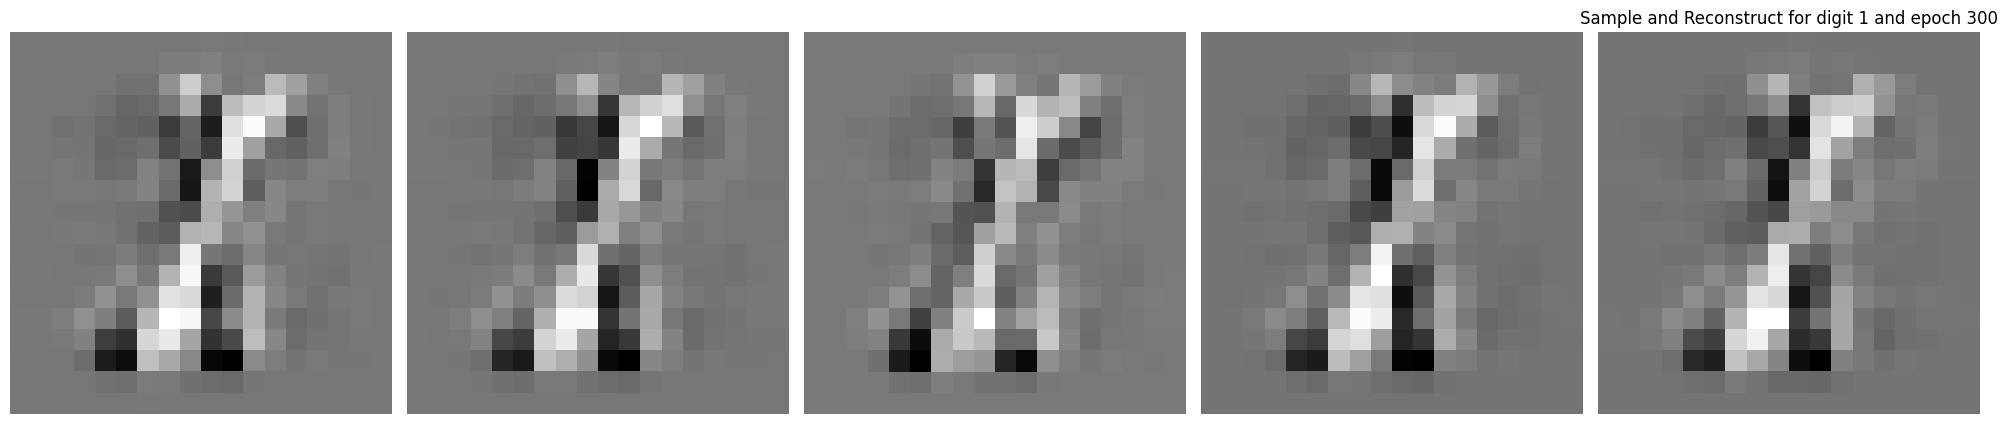

mean = tensor([ 1.5776e+01,  9.1176e+00,  1.5865e+01,  7.0296e+00,  8.1866e+00,
         5.7552e+00,  4.9601e+00,  7.4491e+00, -1.2190e+00,  8.5763e+00,
         5.3145e+00,  1.1791e+01,  1.3990e+01, -5.9950e-01,  2.9176e+00,
         7.8331e-01,  4.6864e+00,  6.7486e+00,  5.2022e+00,  8.0357e+00,
         1.6680e+00,  1.2135e+01,  5.5985e+00,  3.2243e+00,  1.8040e+01,
         1.2389e+01,  9.3007e+00, -3.1892e+00, -4.8149e+00,  1.3267e+01,
         1.4903e+01,  8.3347e+00,  1.5989e+00,  9.6538e+00,  2.6971e+00,
        -1.7048e+00,  4.8679e+00,  6.5266e+00, -1.4146e+00,  3.0235e+00,
         2.3518e+01,  1.7003e+01, -3.7267e+00, -1.6936e-03,  4.2878e+00,
         5.8320e+00,  1.3137e+01,  5.6817e-01,  3.7690e-01,  5.9646e+00,
         7.8451e-01,  1.0486e+01,  9.4108e+00,  9.6851e+00,  6.5378e+00,
         2.8421e+00,  1.1517e+01,  5.6248e+00,  8.1634e+00,  9.6875e+00,
         7.3152e+00,  4.6759e+00,  1.2742e+01,  7.4751e+00,  9.2441e+00,
         1.6627e+00,  4.8030e+00,  4.1452e+0

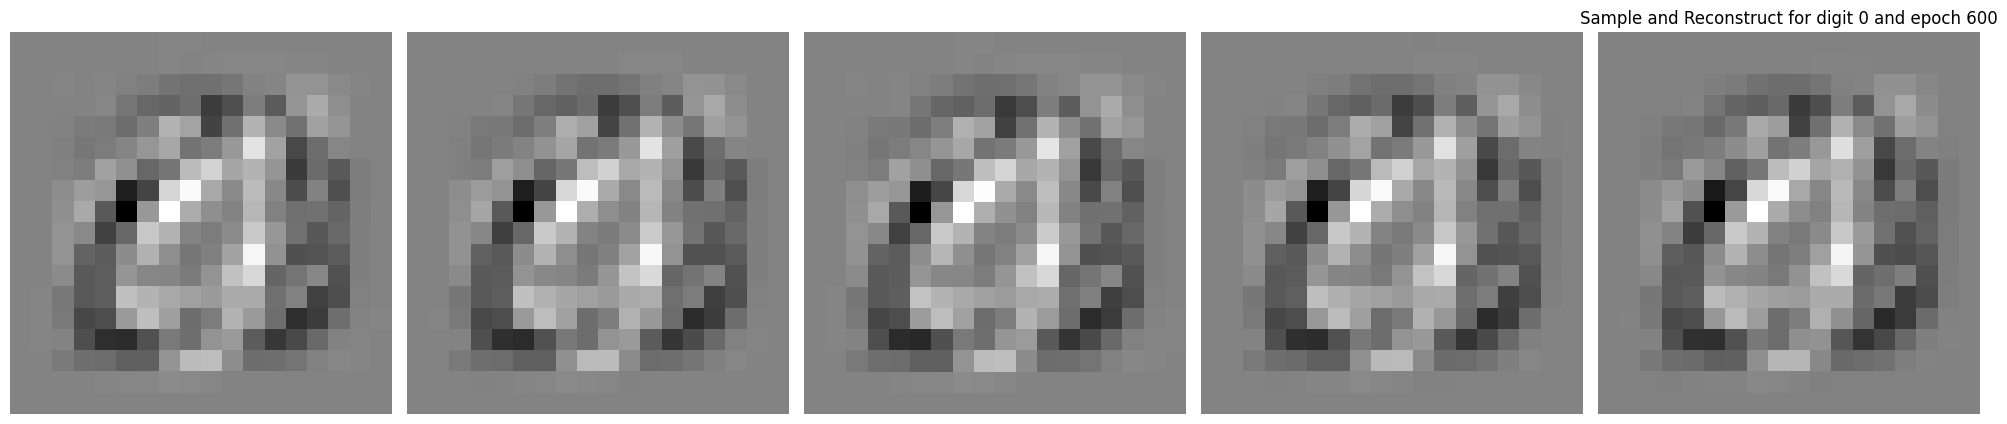

mean = tensor([ 15.8161,   9.1108,  15.8668,   7.0470,   8.1698,   5.7469,   4.9456,
          7.4234,  -1.2103,   8.5494,   5.3091,  11.7723,  14.1579,  -0.5928,
          2.9355,   0.7908,   4.6907,   6.7293,   5.0954,   8.0024,   1.6670,
         12.0334,   5.7135,   3.2321,  17.9972,  12.3693,   9.2557,  -3.1918,
         -5.0307,  13.2759,  14.8909,   8.3370,   1.5968,   9.6900,   2.6439,
         -1.9496,   4.8777,   6.5510,  -1.4358,   2.4178,  23.4559,  17.0119,
         -3.6708,  -0.6092,   4.2821,   5.7894,  13.4565,   0.6005,   0.3872,
          5.9592,   0.7328,  10.4939,   9.5709,   9.7127,   6.5369,   2.8279,
         11.4259,   5.6146,   8.1777,   9.6860,   7.3041,   4.6650,  12.6303,
          7.4770,   9.2472,   1.4931,   4.8415,   4.1597,   7.5311,   7.0160,
          8.7341,   6.8962,   7.1928,  11.6592,  11.1501,   6.7996,   1.4465,
          6.5402,  24.4474,   2.8429,   2.7819,  17.7679,  12.7321,  -0.3366,
          6.0698,  14.4139,  11.5737, -14.6771,  10.5877,

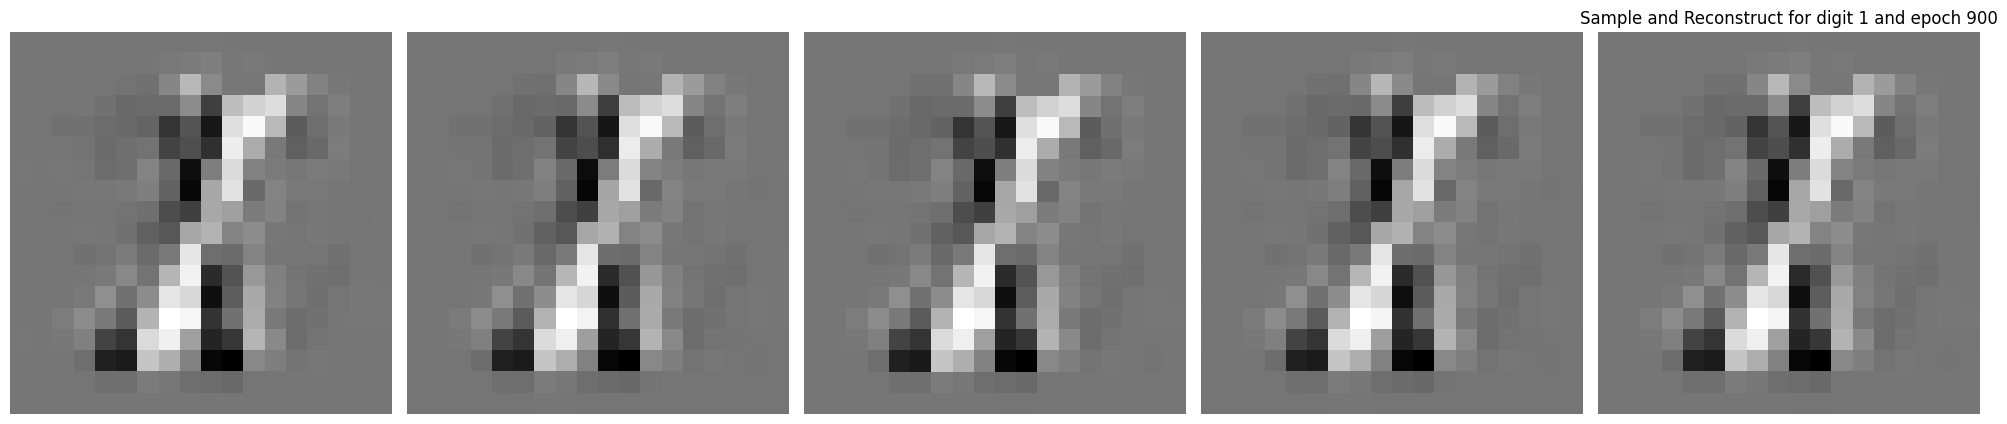

mean = tensor([ 15.8195,   9.1119,  15.8898,   7.0518,   8.1650,   5.7514,   4.9291,
          7.4210,  -1.2096,   8.5406,   5.3093,  11.7853,  14.1387,  -0.5861,
          2.9311,   0.7930,   4.6923,   6.7327,   5.0873,   8.0036,   1.6679,
         11.9705,   5.7194,   3.2381,  17.9890,  12.3716,   9.2767,  -3.1932,
         -5.0467,  13.2579,  14.8740,   8.3320,   1.5926,   9.7179,   2.7135,
         -1.9326,   4.8713,   6.5540,  -1.4330,   2.1183,  23.4946,  17.0187,
         -3.6751,  -0.5775,   4.2785,   5.7939,  13.4224,   0.5992,   0.3704,
          5.9680,   0.7237,  10.4930,   9.6012,   9.7160,   6.5441,   2.8235,
         11.3758,   5.6152,   8.1536,   9.6915,   7.3170,   4.6544,  12.6297,
          7.4879,   9.2570,   1.4922,   4.8512,   4.1596,   7.5300,   7.0217,
          8.7207,   6.8861,   7.1973,  11.6726,  11.1707,   6.7929,   1.4474,
          6.5308,  24.3732,   2.8350,   2.7841,  17.7517,  12.7295,  -0.3360,
          6.0747,  14.4229,  11.5638, -14.6880,  10.5916,

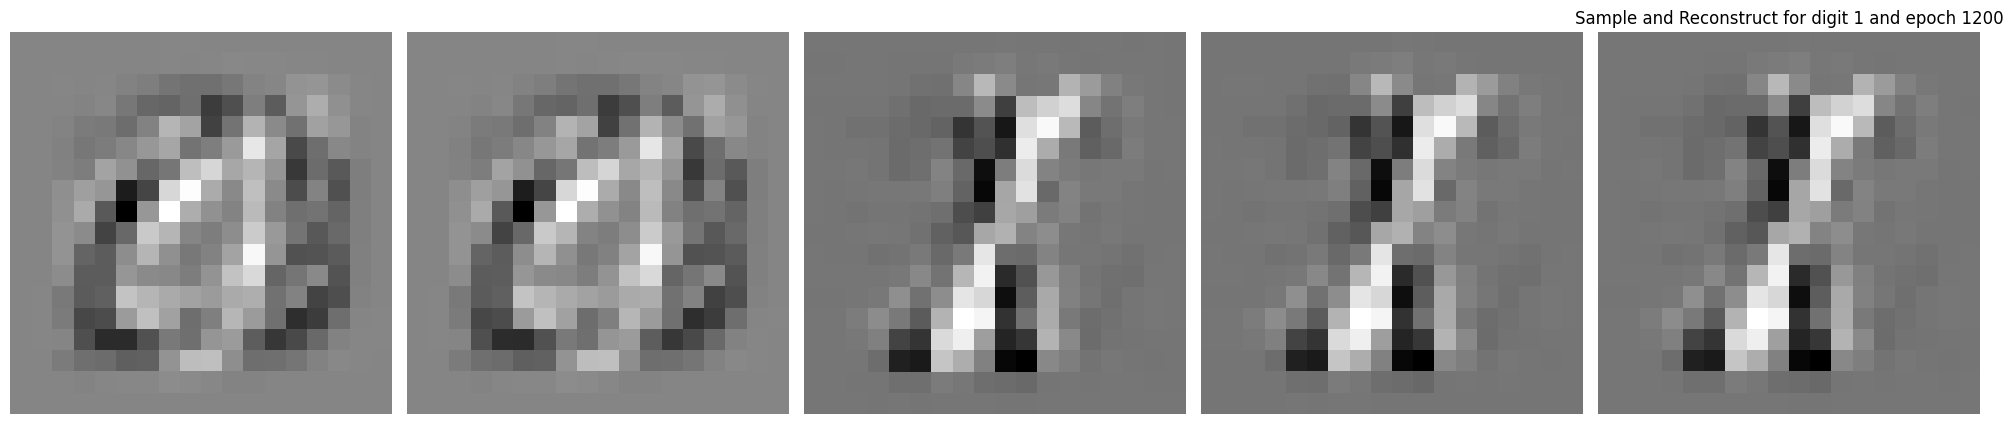

mean = tensor([ 15.8223,   9.1232,  15.8689,   7.0596,   8.1671,   5.7487,   4.9364,
          7.4348,  -1.2005,   8.5674,   5.3048,  11.7667,  14.1237,  -0.5964,
          2.9483,   0.8087,   4.7062,   6.7542,   5.0996,   8.0093,   1.6642,
         11.9647,   5.7162,   3.2416,  18.0174,  12.3718,   9.2810,  -3.2066,
         -5.0403,  13.2680,  14.8613,   8.3364,   1.5895,   9.7161,   2.7084,
         -1.9359,   4.8660,   6.5536,  -1.4298,   2.1244,  23.4956,  17.0243,
         -3.6709,  -0.5723,   4.2737,   5.7913,  13.4377,   0.6021,   0.3709,
          5.9654,   0.7176,  10.5259,   9.5856,   9.7457,   6.5329,   2.8313,
         11.3612,   5.6166,   8.1346,   9.6993,   7.3318,   4.6584,  12.5882,
          7.4784,   9.2296,   1.4868,   4.8599,   4.1524,   7.5396,   7.0332,
          8.6924,   6.8941,   7.1881,  11.6738,  11.1678,   6.8017,   1.4560,
          6.5332,  24.4073,   2.8386,   2.7899,  17.7588,  12.7239,  -0.3329,
          6.0844,  14.4491,  11.5724, -14.7041,  10.5855,

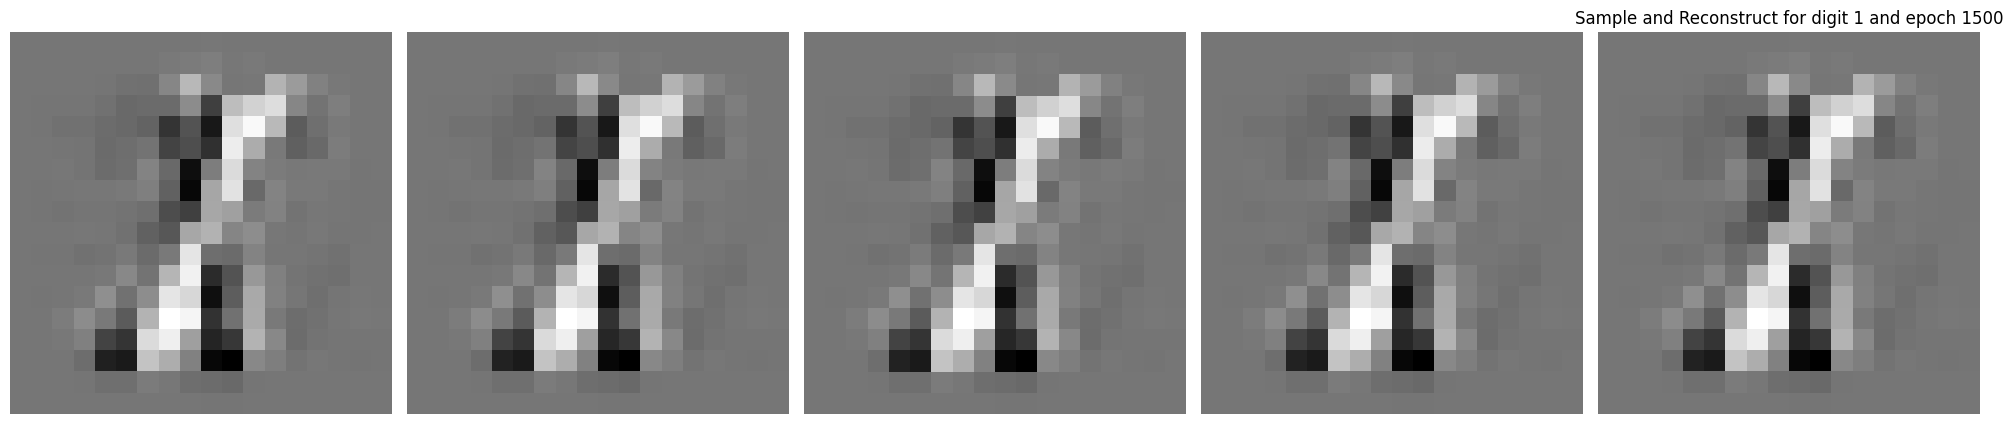

mean = tensor([ 15.8292,   9.1220,  15.8753,   7.0703,   8.1794,   5.7521,   4.9322,
          7.4389,  -1.2053,   8.5839,   5.3089,  11.7566,  14.1435,  -0.6018,
          2.9477,   0.8070,   4.7093,   6.7656,   5.1032,   7.9911,   1.6623,
         11.9300,   5.7147,   3.2345,  18.0803,  12.3733,   9.2589,  -3.2054,
         -5.0438,  13.2585,  14.8526,   8.3381,   1.6000,   9.7127,   2.7084,
         -1.9364,   4.8872,   6.5459,  -1.4330,   2.1324,  23.4548,  17.0194,
         -3.6818,  -0.5599,   4.2687,   5.7841,  13.4401,   0.5993,   0.3712,
          5.9669,   0.7154,  10.5327,   9.6042,   9.7509,   6.5253,   2.8402,
         11.3871,   5.6104,   8.1319,   9.7082,   7.3397,   4.6545,  12.5825,
          7.4677,   9.2230,   1.4792,   4.8805,   4.1552,   7.5420,   7.0026,
          8.6912,   6.8893,   7.1914,  11.6737,  11.1786,   6.7958,   1.4623,
          6.5317,  24.4258,   2.8286,   2.8101,  17.8326,  12.7038,  -0.3305,
          6.0873,  14.4546,  11.5642, -14.7020,  10.6209,

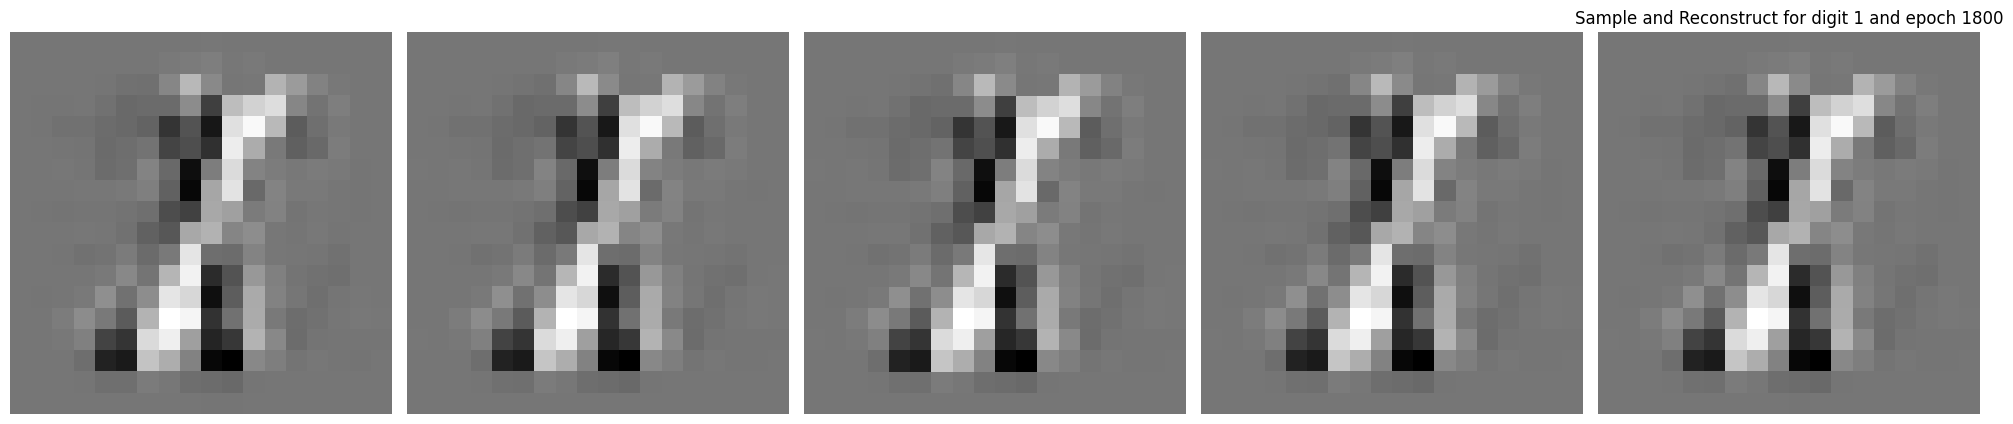

mean = tensor([ 15.8398,   9.1655,  15.8936,   7.0721,   8.1849,   5.7765,   4.9237,
          7.4507,  -1.2133,   8.5964,   5.3161,  11.7770,  14.1489,  -0.5947,
          2.9384,   0.8083,   4.6977,   6.7830,   5.1198,   8.0074,   1.6562,
         11.8585,   5.7004,   3.2296,  18.0924,  12.4005,   9.2424,  -3.2236,
         -5.0397,  13.2419,  14.8511,   8.3391,   1.5971,   9.7254,   2.7054,
         -1.9384,   4.8882,   6.5301,  -1.4368,   2.1383,  23.4919,  16.9672,
         -3.6859,  -0.5649,   4.2678,   5.7799,  13.4285,   0.5933,   0.3709,
          5.9544,   0.7108,  10.5334,   9.5956,   9.7680,   6.5392,   2.8287,
         11.3652,   5.6013,   8.1421,   9.7034,   7.3464,   4.6585,  12.5789,
          7.4808,   9.2194,   1.4671,   4.8788,   4.1467,   7.5341,   7.0078,
          8.6947,   6.8966,   7.1792,  11.6720,  11.1789,   6.7942,   1.4585,
          6.4955,  24.4837,   2.8324,   2.8130,  17.7439,  12.7170,  -0.3307,
          6.0905,  14.4417,  11.5732, -14.6797,  10.6326,

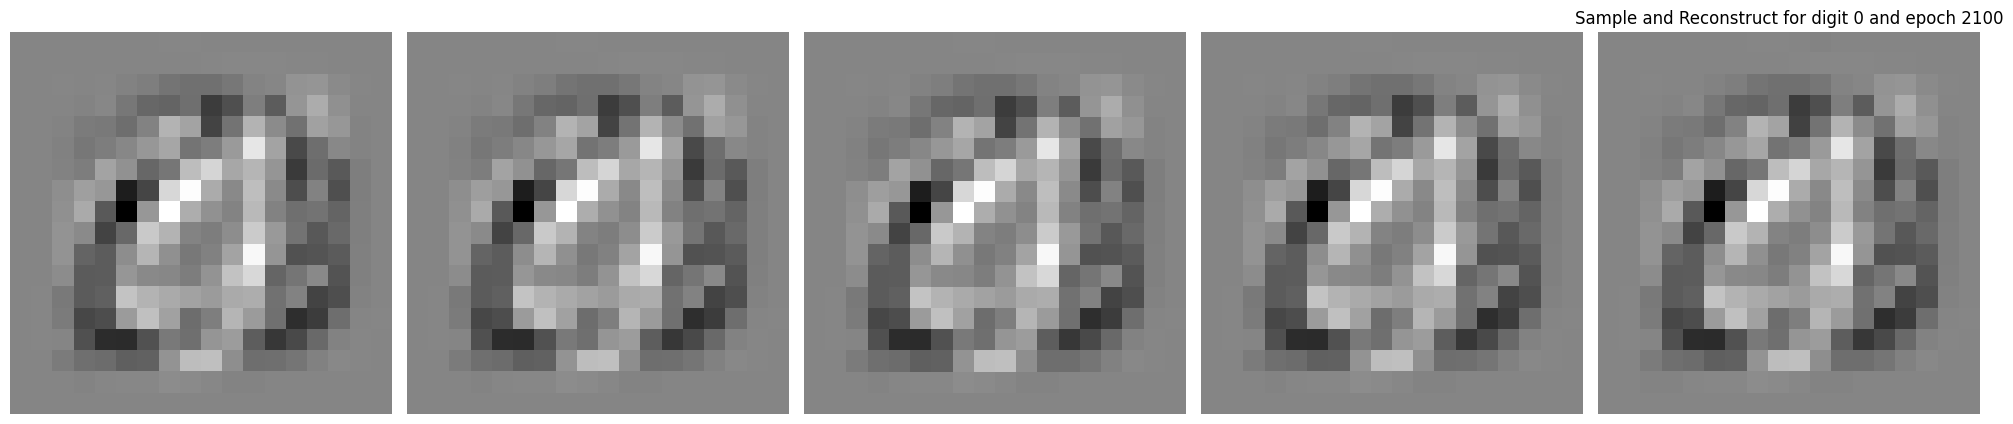

mean = tensor([ 15.8010,   9.1659,  15.8875,   7.0718,   8.1914,   5.7803,   4.9009,
          7.4458,  -1.2125,   8.5970,   5.3053,  11.7856,  14.1500,  -0.5918,
          2.9460,   0.8097,   4.7030,   6.8082,   5.1171,   8.0133,   1.6530,
         11.8359,   5.6942,   3.2201,  18.1019,  12.4114,   9.2272,  -3.2287,
         -5.0398,  13.2608,  14.8591,   8.3414,   1.6056,   9.7206,   2.6981,
         -1.9278,   4.8928,   6.5310,  -1.4323,   2.1265,  23.5431,  16.9722,
         -3.6884,  -0.5726,   4.2569,   5.7940,  13.4318,   0.5920,   0.3651,
          5.9510,   0.7156,  10.5330,   9.6106,   9.7690,   6.5314,   2.8354,
         11.4300,   5.6024,   8.0836,   9.7005,   7.3130,   4.6575,  12.6072,
          7.4830,   9.2290,   1.4776,   4.8951,   4.1181,   7.5352,   7.0108,
          8.6847,   6.8911,   7.1775,  11.6896,  11.1785,   6.7956,   1.4437,
          6.4410,  24.4199,   2.8283,   2.8118,  17.7538,  12.7587,  -0.3174,
          6.0974,  14.4723,  11.5705, -14.6947,  10.6367,

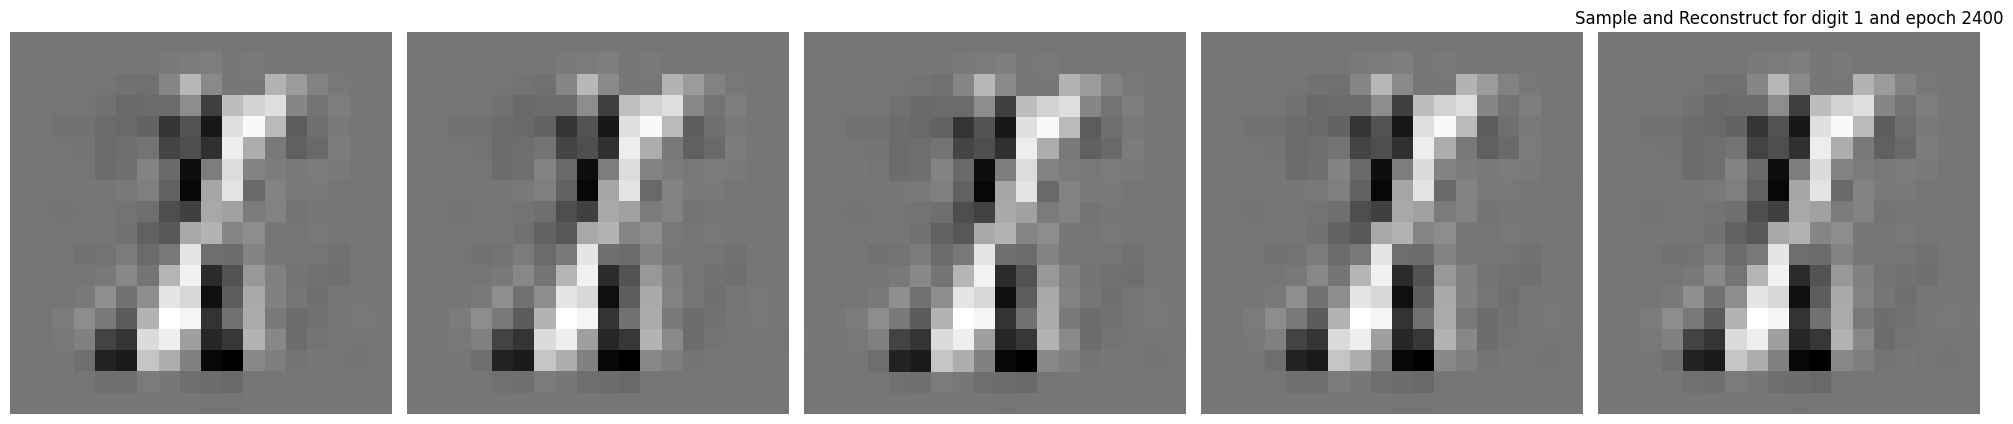

mean = tensor([ 15.8062,   9.1683,  15.8897,   7.0701,   8.1716,   5.7727,   4.9134,
          7.4478,  -1.2142,   8.5949,   5.3078,  11.8101,  14.2277,  -0.5944,
          2.9409,   0.8069,   4.6999,   6.8441,   5.1183,   7.9940,   1.6551,
         11.8176,   5.6947,   3.2171,  18.1158,  12.4103,   9.2179,  -3.2271,
         -5.0573,  13.2750,  14.8438,   8.3512,   1.6046,   9.7082,   2.7015,
         -1.9380,   4.8937,   6.5242,  -1.4207,   2.1183,  23.6097,  16.9485,
         -3.6958,  -0.5690,   4.2495,   5.8045,  13.4145,   0.5989,   0.3573,
          5.9337,   0.7110,  10.5420,   9.6127,   9.7674,   6.5329,   2.8359,
         11.4261,   5.5947,   8.1000,   9.6863,   7.2839,   4.6660,  12.6107,
          7.4821,   9.2382,   1.4814,   4.8954,   4.0672,   7.5611,   6.9971,
          8.6784,   6.9012,   7.1819,  11.6855,  11.1549,   6.8056,   1.4587,
          6.4610,  24.4127,   2.8148,   2.8241,  17.7417,  12.7361,  -0.3035,
          6.1029,  14.4449,  11.5712, -14.7219,  10.6418,

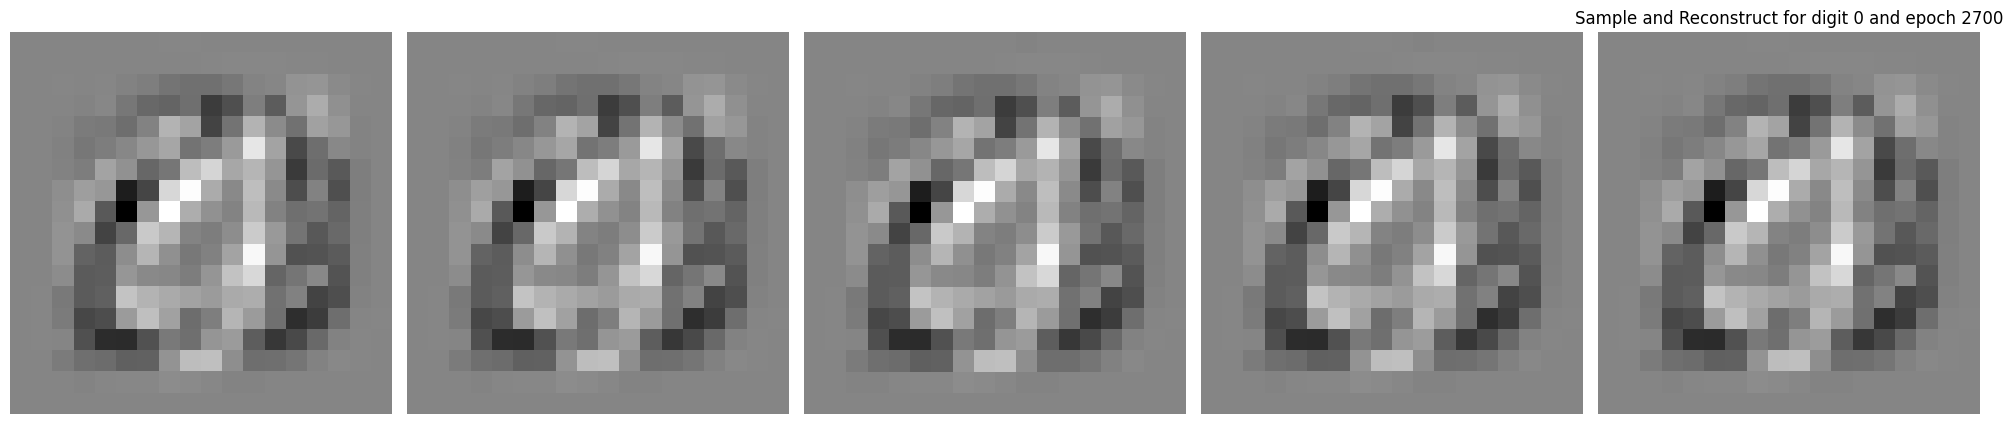

mean = tensor([ 15.8047,   9.1809,  15.8941,   7.0654,   8.1902,   5.7713,   4.8998,
          7.4445,  -1.1950,   8.5984,   5.3078,  11.8130,  14.3002,  -0.5982,
          2.9418,   0.8071,   4.6955,   6.8471,   5.1157,   8.0074,   1.6493,
         11.7947,   5.6638,   3.2198,  18.1421,  12.4033,   9.2380,  -3.2250,
         -5.0599,  13.2925,  14.8356,   8.3582,   1.6006,   9.7389,   2.7078,
         -1.9379,   4.8900,   6.5236,  -1.4383,   2.1130,  23.5901,  16.8876,
         -3.7023,  -0.5676,   4.2480,   5.8106,  13.4810,   0.5977,   0.3527,
          5.9313,   0.7130,  10.5353,   9.6138,   9.7629,   6.5097,   2.8455,
         11.4473,   5.6009,   8.0872,   9.6962,   7.2960,   4.6686,  12.5973,
          7.4810,   9.2473,   1.4656,   4.8849,   4.0618,   7.5602,   6.9999,
          8.6742,   6.8904,   7.1694,  11.6905,  11.1619,   6.8024,   1.4704,
          6.4618,  24.4471,   2.8059,   2.8097,  17.7111,  12.7536,  -0.3089,
          6.1091,  14.4470,  11.5830, -14.7196,  10.6483,

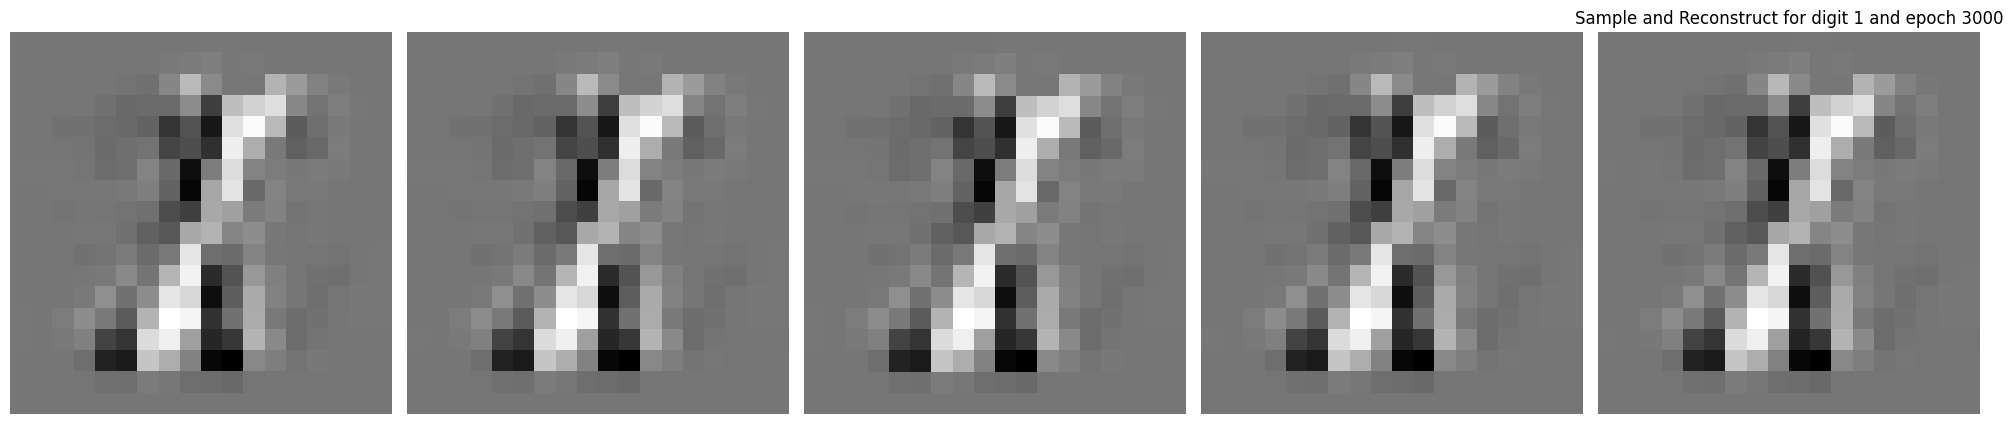

100%|██████████| 3000/3000 [3:10:12<00:00,  3.80s/it]


In [ ]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim = 9
num_trajectories = 1
num_generations = 3000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_9 = shuffle(np.concatenate((final_0_9[:num_0], final_1_9[:num_1]), axis=0))
x_data_49 = shuffle(np.concatenate((final_0_49[:num_0], final_1_49[:num_1]), axis=0))
x_data_324 = shuffle(np.concatenate((final_0_324[:num_0], final_1_324[:num_1]), axis=0))

# # Convert numpy arrays to torch tensors
# final_var_9 = final_cov_9.diagonal()
# mu_0_vals = [torch.tensor(final_mean_9, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_9, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_9, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, (avg_mean_9, diff_mean_9, final_mean_9), inv_0_9, inv_1_9, new_shape)

# # repeat for 49
# dim_49 = 49
# final_var_49 = final_cov_49.diagonal()
# mu_0_vals = [torch.tensor(final_mean_49, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_49, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_49, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_49, device, (avg_mean_49, diff_mean_49, final_mean_49), inv_0_49, inv_1_49, new_shape_2)

# repeat for 324
dim_324 = 324
final_var_324 = final_cov_324.diagonal()
mu_0_vals = [torch.tensor(final_mean_324, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_324, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_324, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_324, device, (avg_mean_324, diff_mean_324, final_mean_324), inv_0_324, inv_1_324, new_shape_3)

In [ ]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0

dim = 9
num_trajectories = 1
num_generations = 1000
num_1 = 50
num_0 = 50
n = num_0 + num_1

x_data_9 = shuffle(np.concatenate((final_0_9[:num_0], final_1_9[:num_1]), axis=0))
x_data_49 = shuffle(np.concatenate((final_0_49[:num_0], final_1_49[:num_1]), axis=0))
x_data_324 = shuffle(np.concatenate((final_0_324[:num_0], final_1_324[:num_1]), axis=0))

# # Convert numpy arrays to torch tensors
# final_var_9 = final_cov_9.diagonal()
# mu_0_vals = [torch.tensor(final_mean_9, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_9, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_9, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, (avg_mean_9, diff_mean_9, final_mean_9), inv_0_9, inv_1_9, new_shape)

# # repeat for 49
# dim_49 = 49
# final_var_49 = final_cov_49.diagonal()
# mu_0_vals = [torch.tensor(final_mean_49, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_49, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_49, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_49, device, (avg_mean_49, diff_mean_49, final_mean_49), inv_0_49, inv_1_49, new_shape_2)

# repeat for 324
dim_324 = 324
final_var_324 = final_cov_324.diagonal()
mu_0_vals = [torch.tensor(final_mean_324, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_324, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_324, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_324, device, (avg_mean_324, diff_mean_324, final_mean_324), inv_0_324, inv_1_324, new_shape_3)

  0%|          | 0/6000 [00:00<?, ?it/s]C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)
  0%|          | 4/6000 [00:00<03:12, 31.11it/s]

Generation 1


100%|█████████▉| 5998/6000 [04:17<00:00, 26.17it/s]C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\1173561831.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


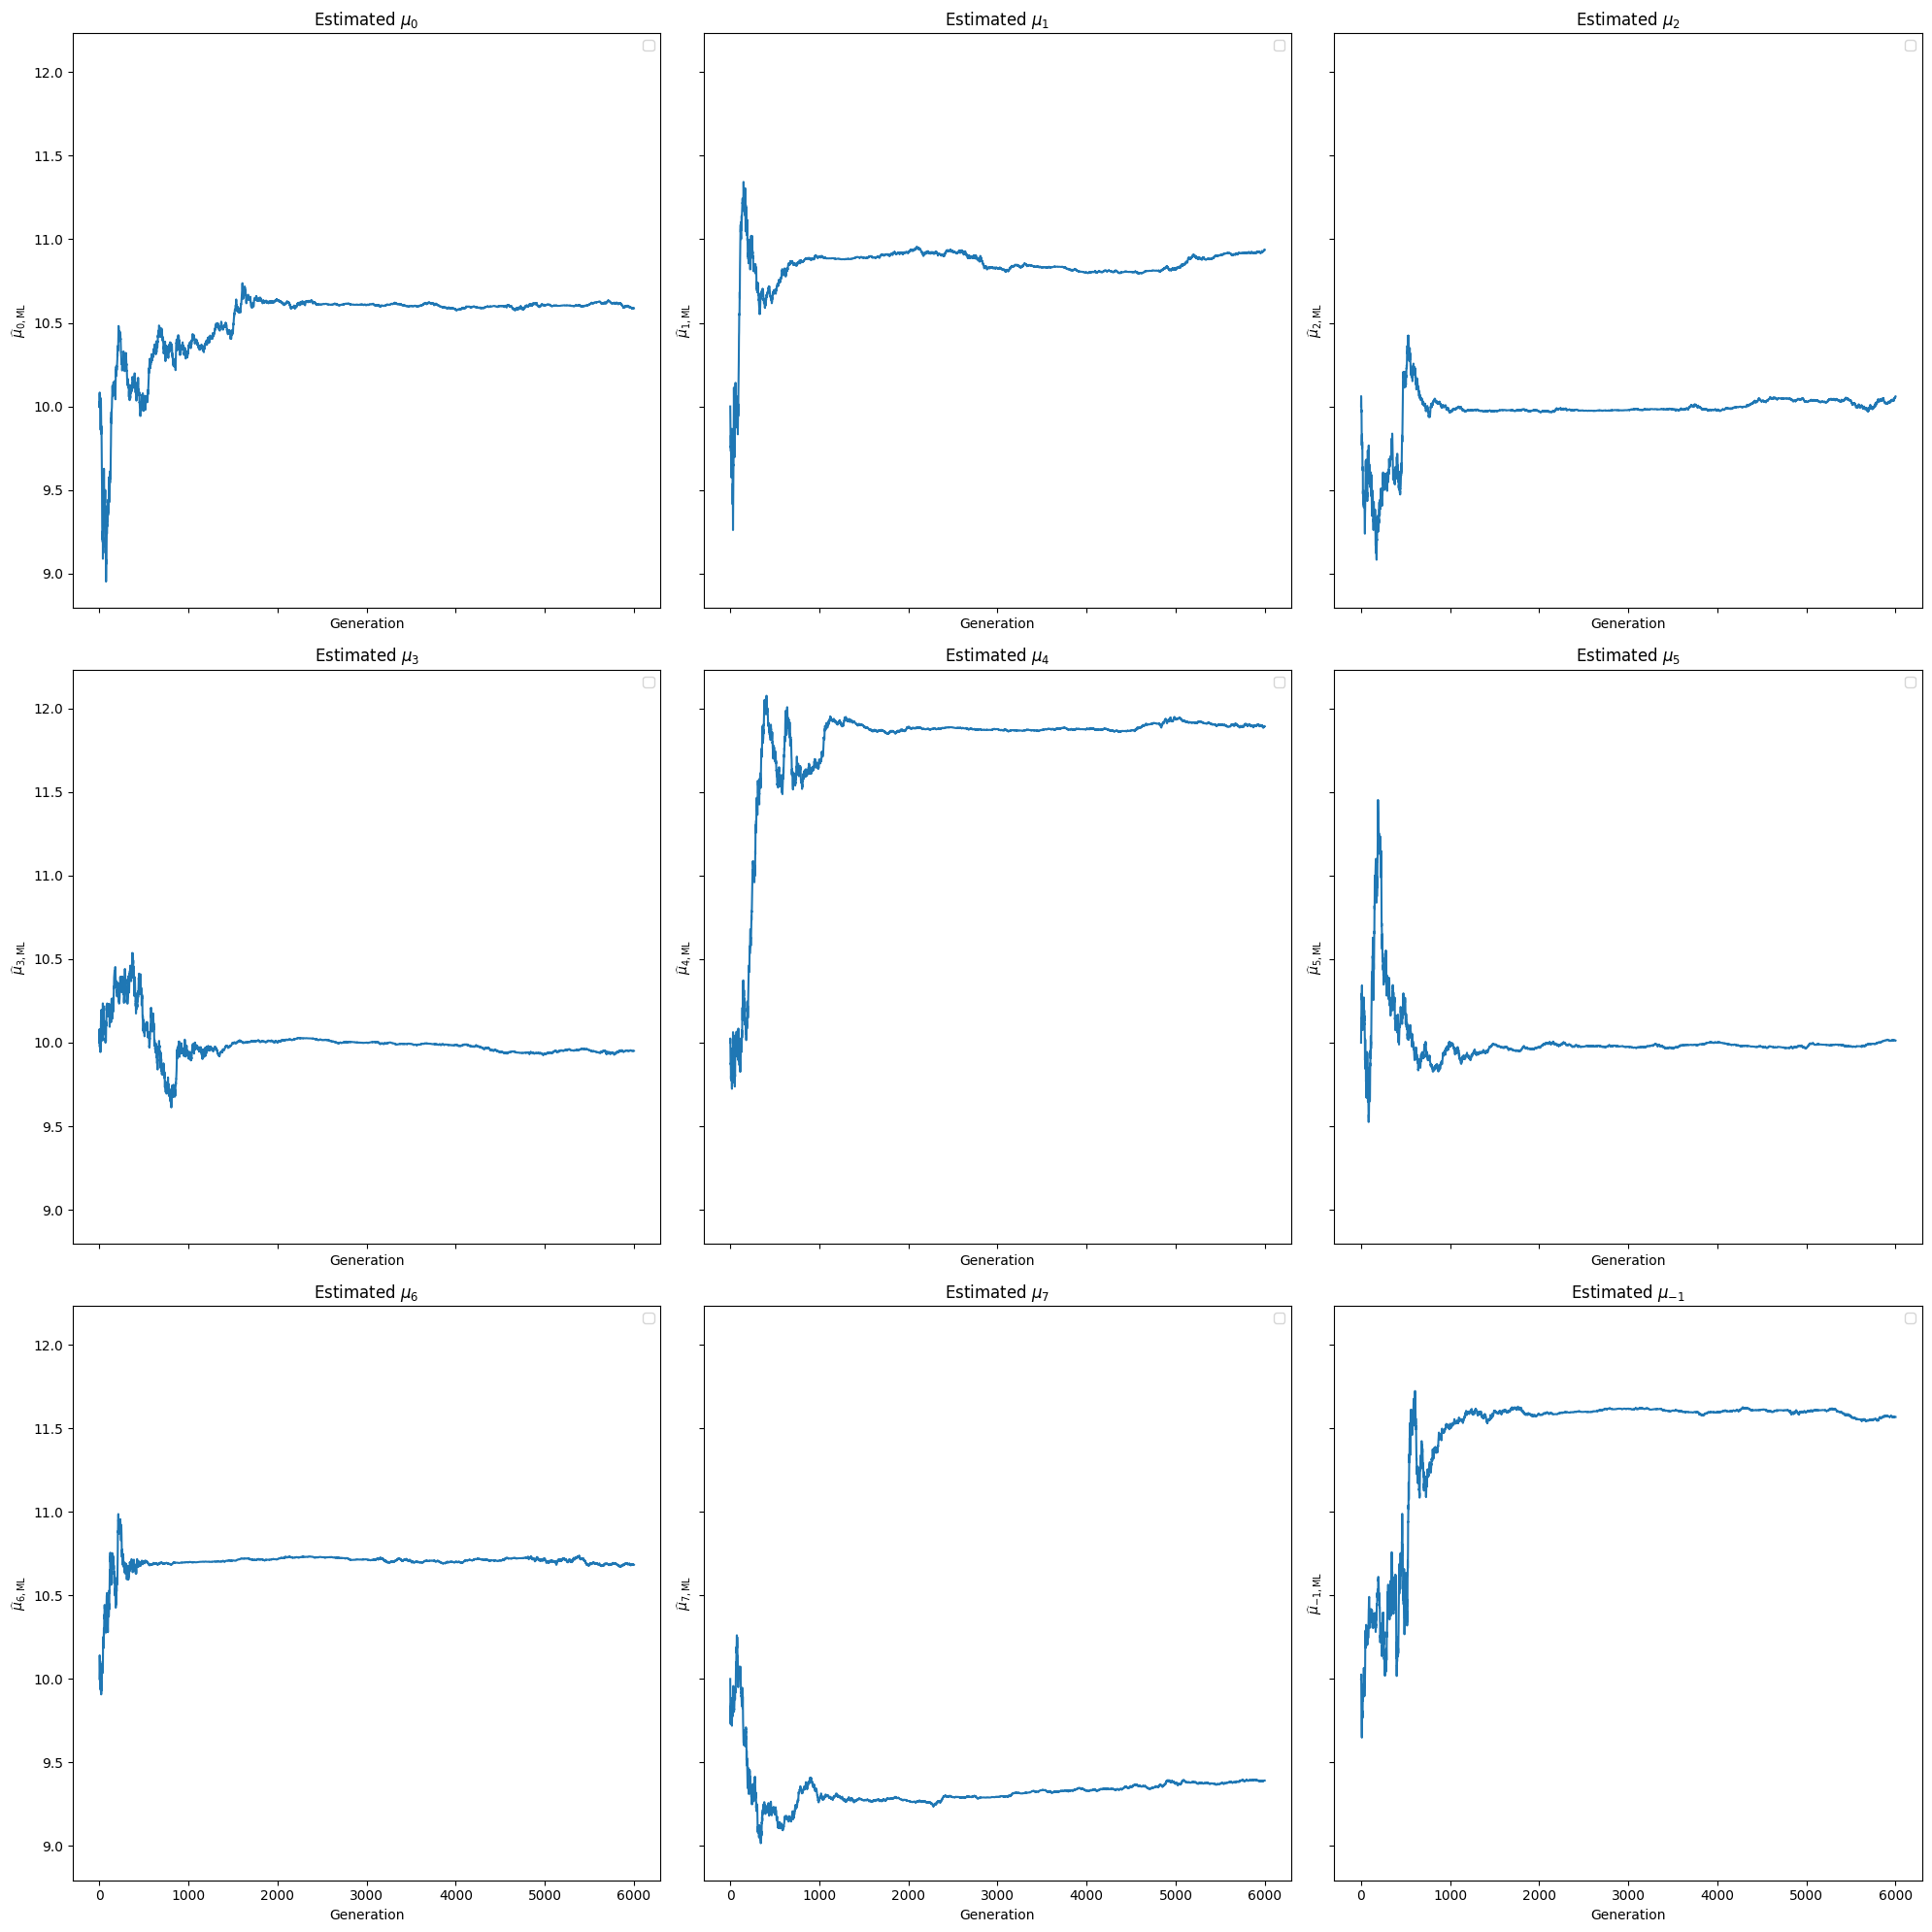

C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\1173561831.py:82: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


<Figure size 640x480 with 0 Axes>

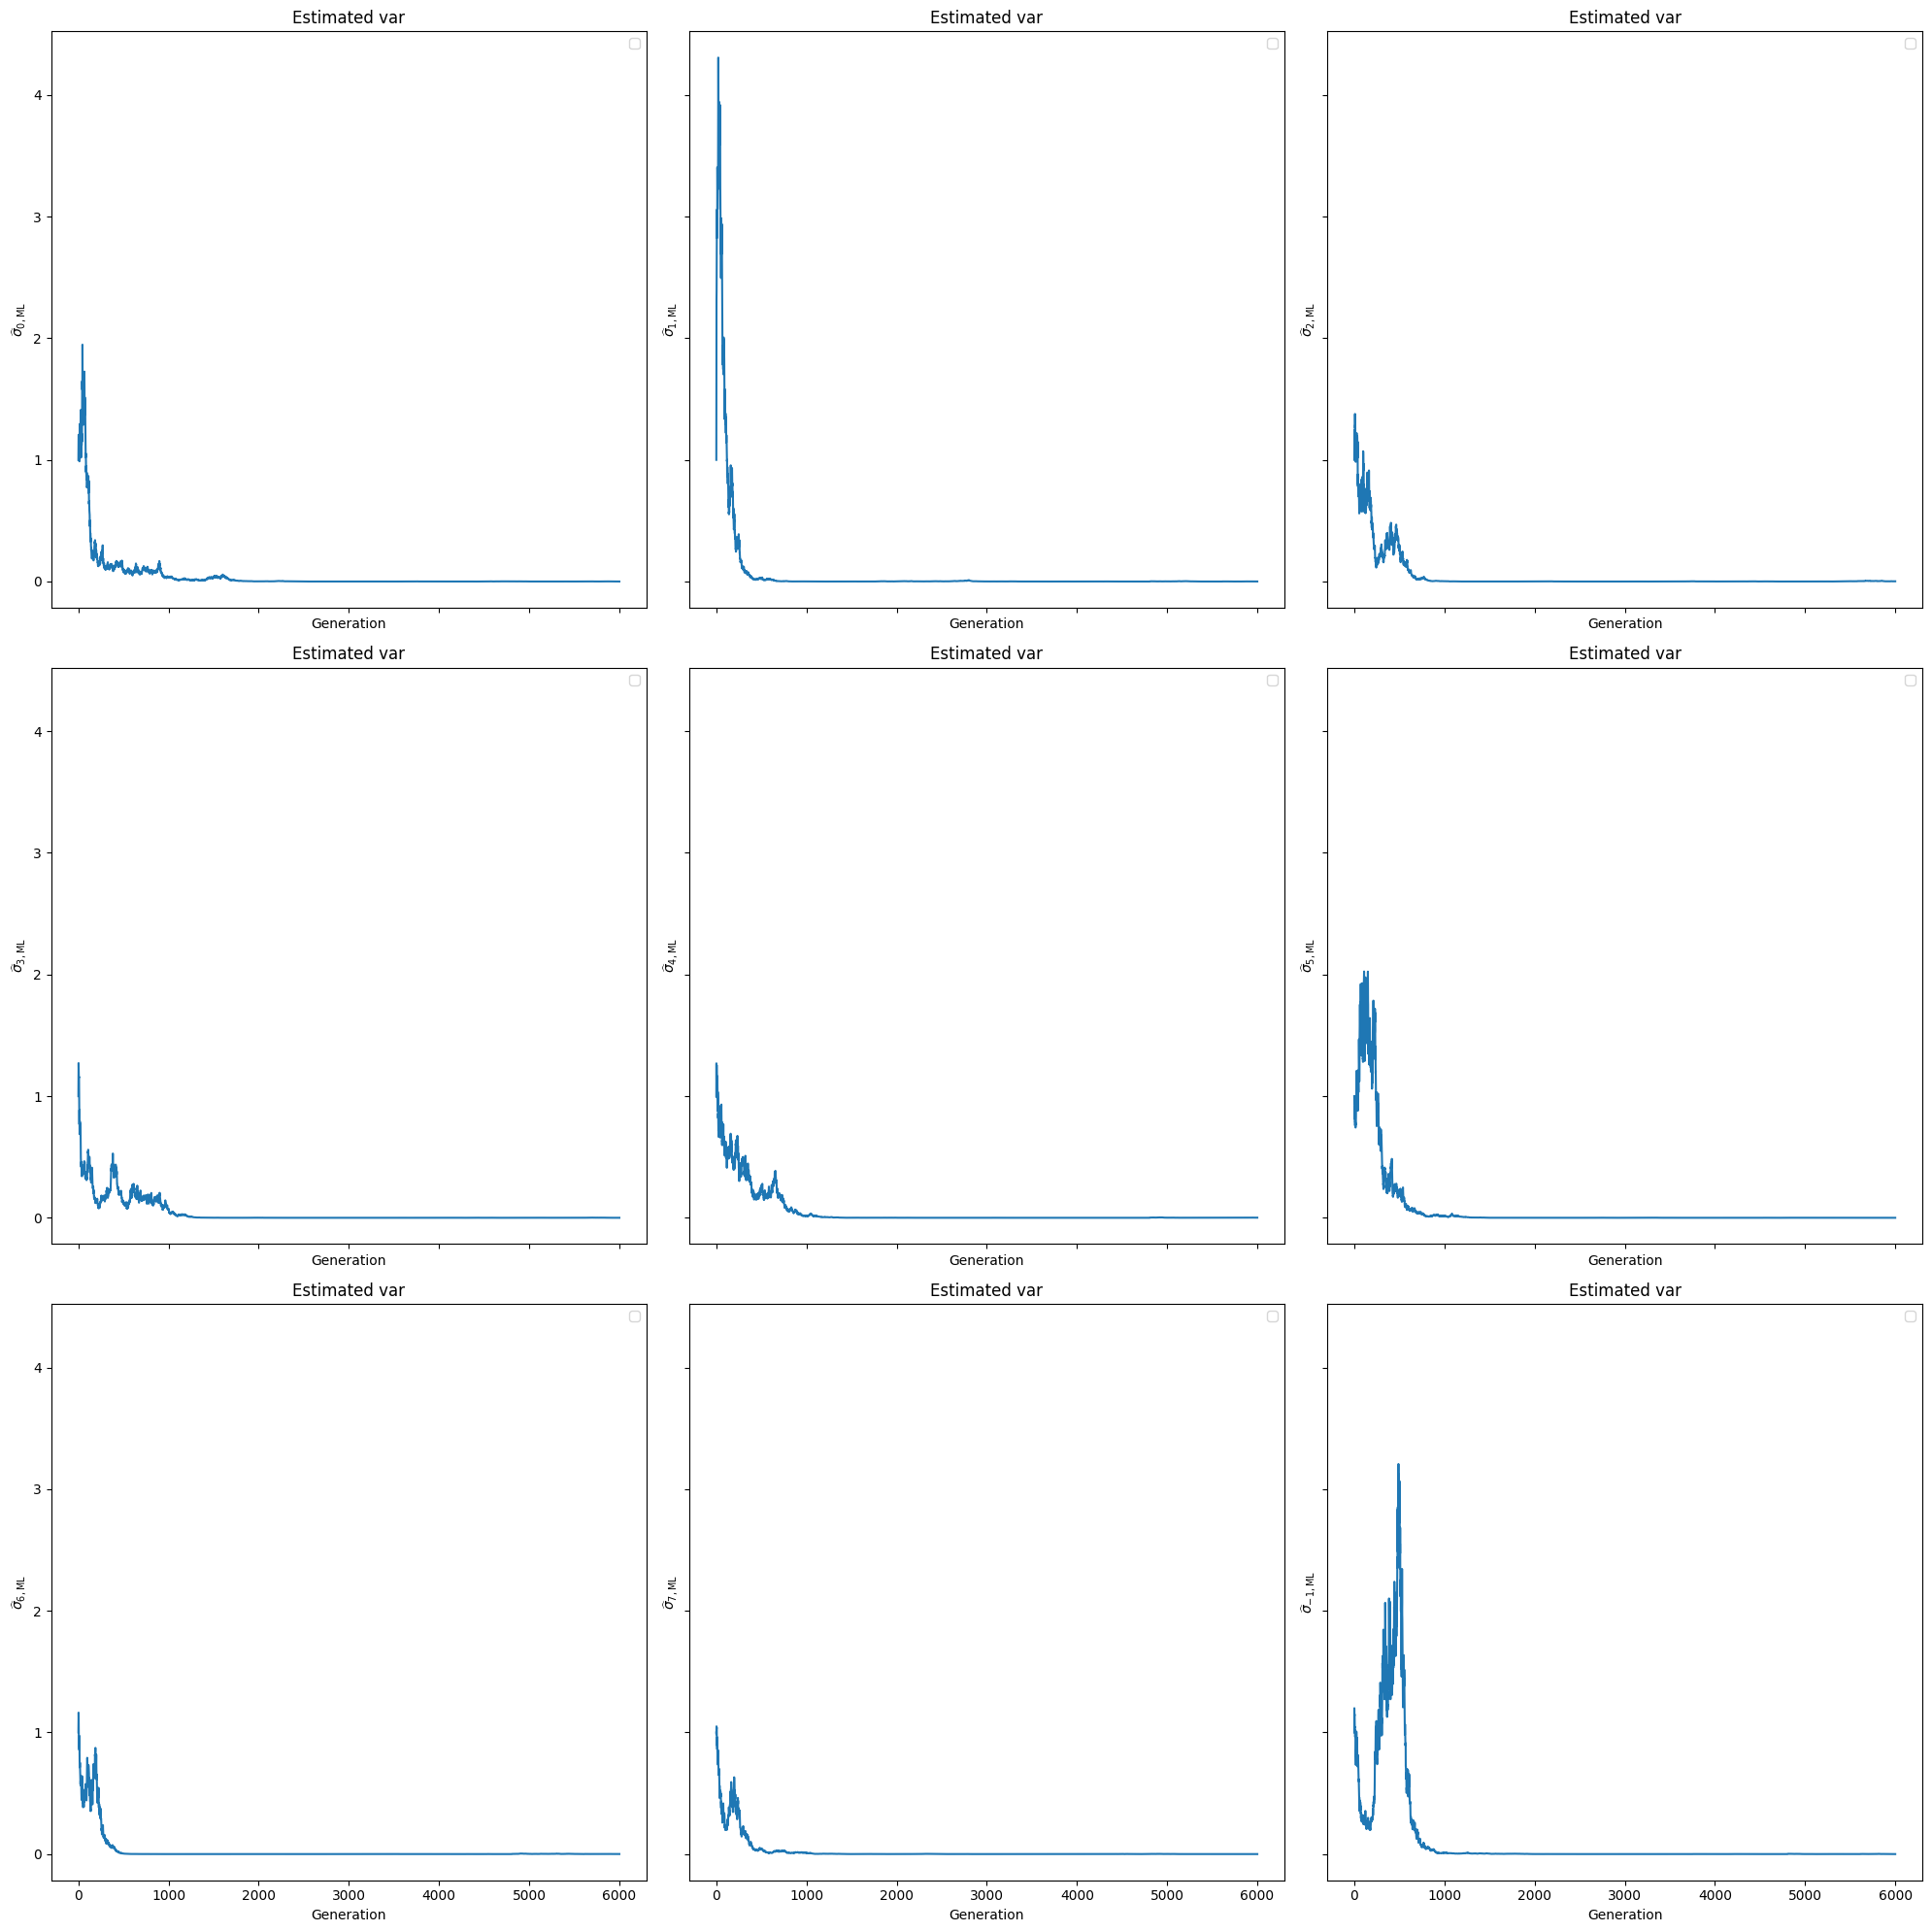

C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\1173561831.py:96: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


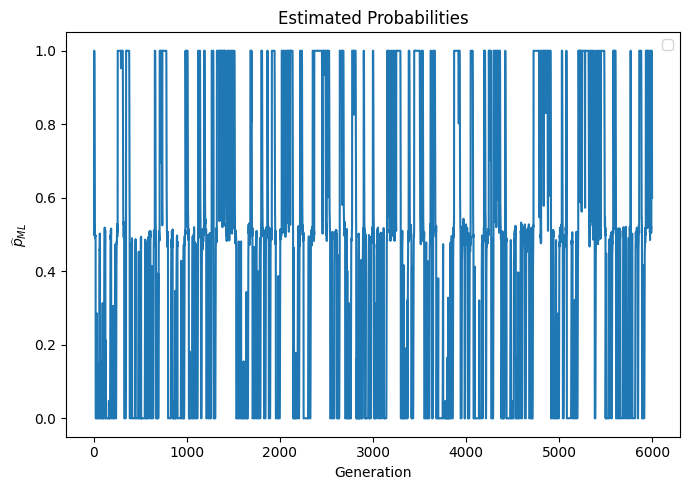

idx_list = [   0  600 1200 1800 2400 3000 3600 4200 4800 5400 6000]
mean = tensor([10., 10., 10., 10., 10., 10., 10., 10., 10.])
var = tensor([1., 1., 1., 1., 1., 1., 1., 1., 1.])
p = 0.5


C:\Users\shrey\AppData\Local\Temp\ipykernel_20256\2153345488.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  std = np.sqrt(var)


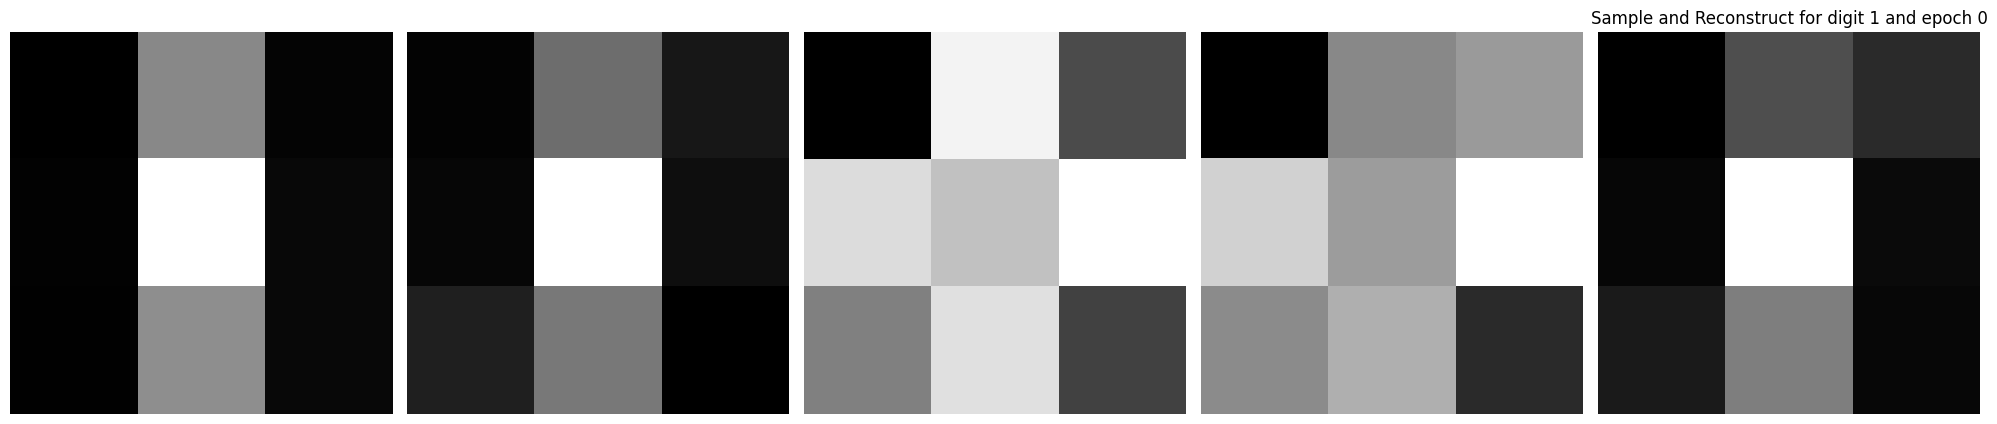

mean = tensor([10.2990, 10.7993, 10.2146, 10.1381, 11.6411,  9.8969, 10.6878,  9.1194,
        11.5162], dtype=torch.float64)
var = tensor([0.0504, 0.0210, 0.0940, 0.2440, 0.1837, 0.0870, 0.0010, 0.0122, 0.4824],
       dtype=torch.float64)
p = 0.488744298960134


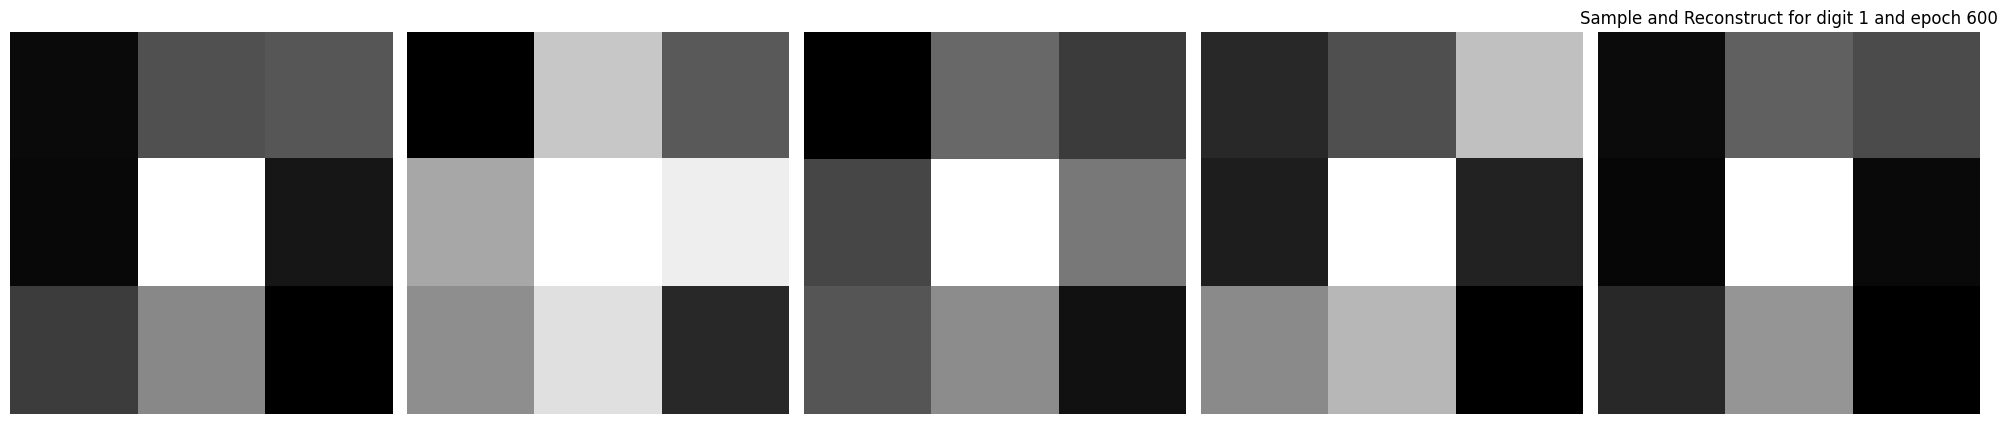

mean = tensor([10.3883, 10.8836,  9.9769,  9.9458, 11.9079,  9.9198, 10.7020,  9.3093,
        11.5957], dtype=torch.float64)
var = tensor([1.4972e-02, 1.9509e-05, 3.3013e-04, 1.7102e-02, 6.8350e-03, 7.7632e-03,
        1.5645e-05, 2.8548e-03, 5.6280e-03], dtype=torch.float64)
p = 0.5125078222292849


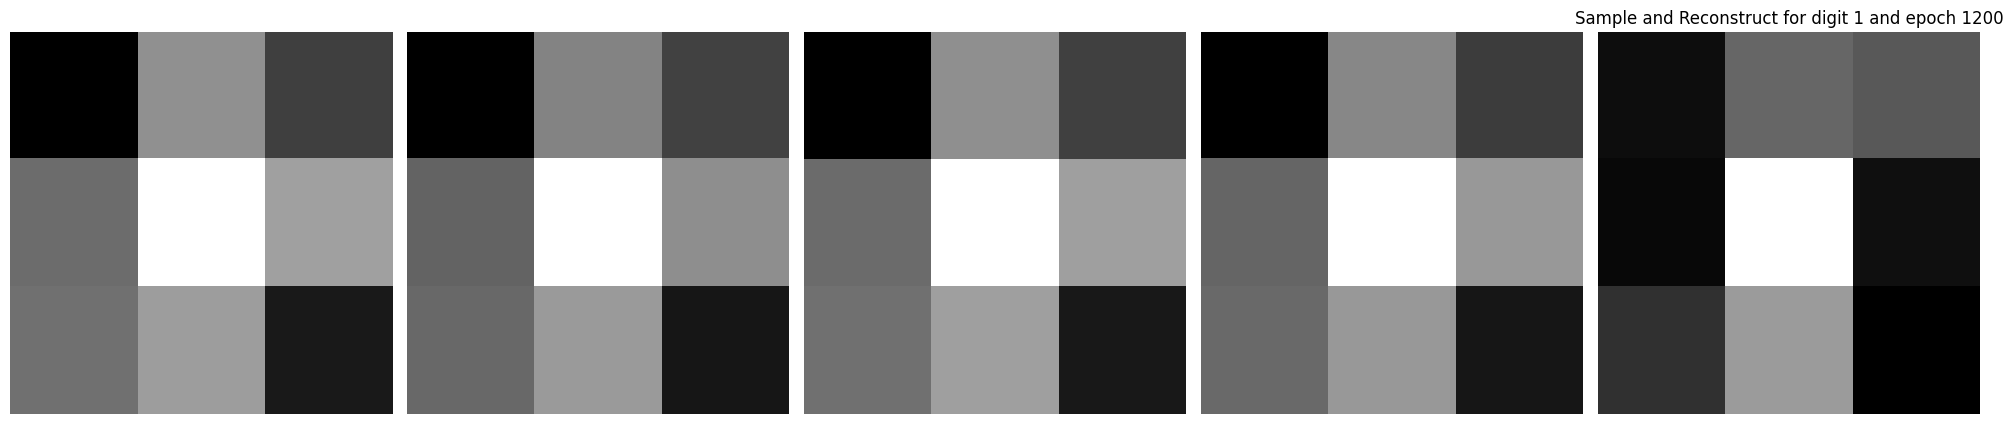

mean = tensor([10.6454, 10.9086,  9.9783, 10.0072, 11.8618,  9.9600, 10.7148,  9.2831,
        11.6179], dtype=torch.float64)
var = tensor([0.0065, 0.0010, 0.0002, 0.0002, 0.0009, 0.0009, 0.0002, 0.0003, 0.0029],
       dtype=torch.float64)
p = 0.9997339514207492


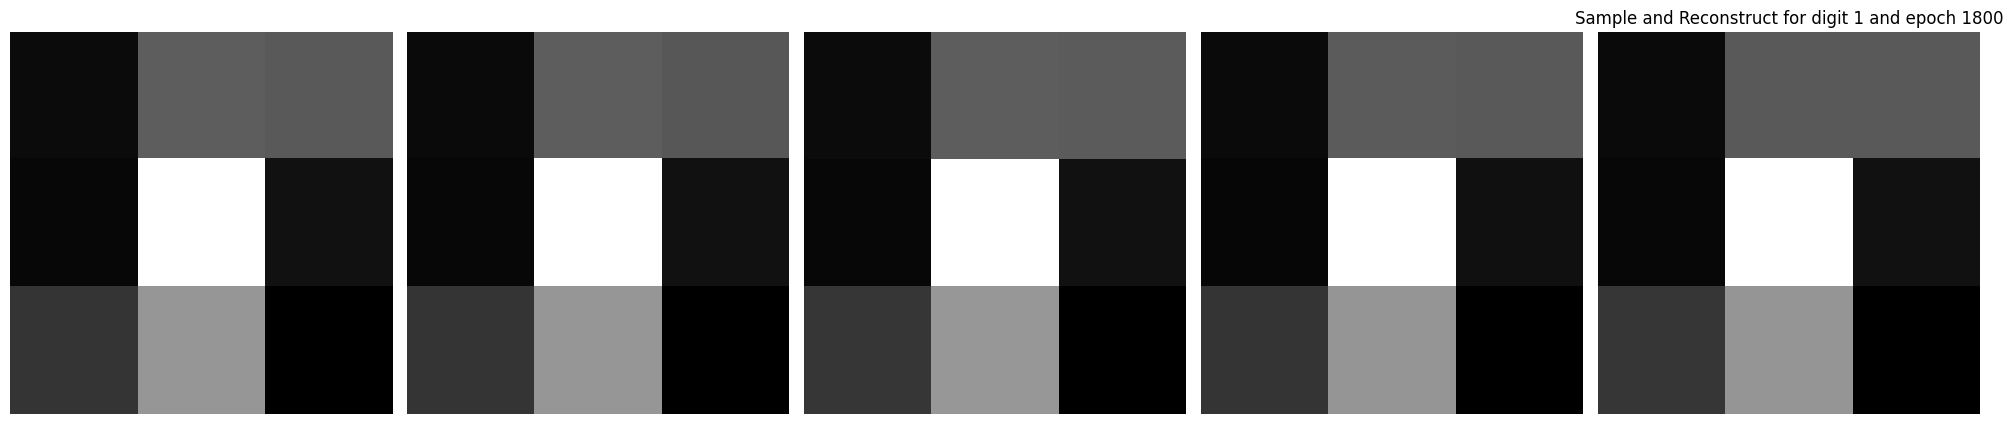

mean = tensor([10.6203, 10.9035,  9.9771, 10.0247, 11.8826,  9.9778, 10.7299,  9.2959,
        11.5988], dtype=torch.float64)
var = tensor([1.0164e-03, 1.6579e-03, 1.2463e-04, 6.4218e-05, 8.0964e-05, 2.9905e-04,
        6.5240e-05, 1.3334e-03, 4.5721e-05], dtype=torch.float64)
p = 0.9997980194750549


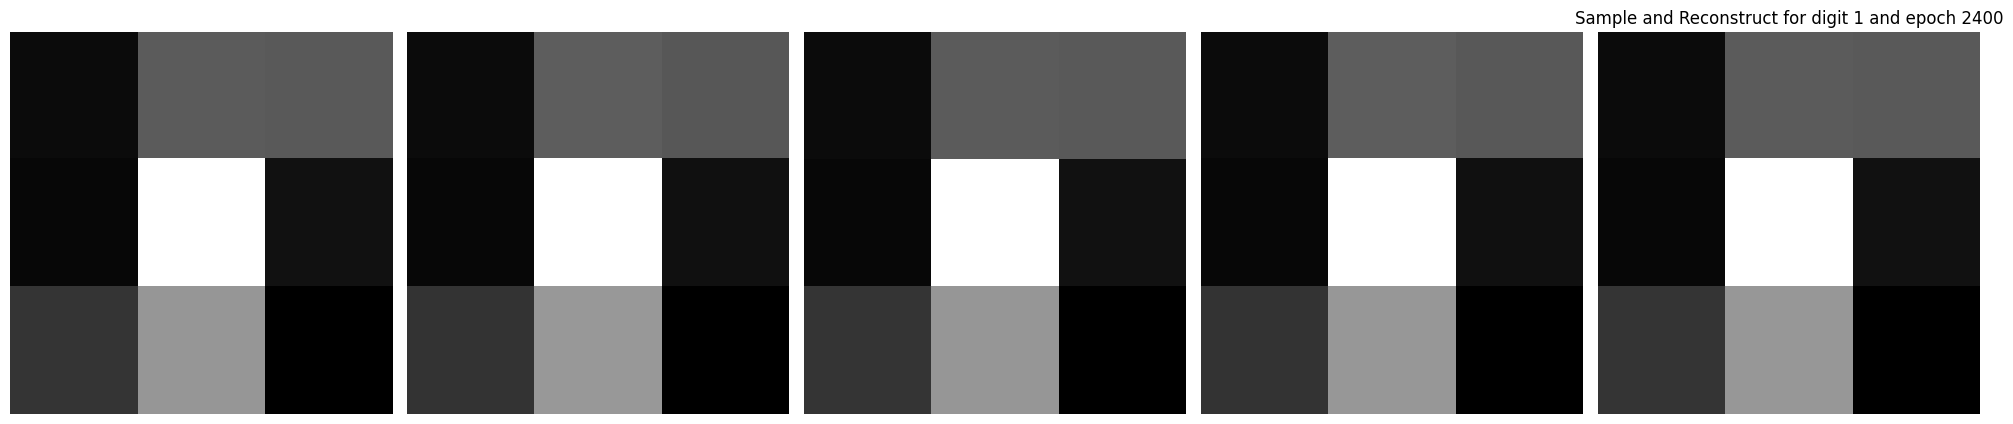

mean = tensor([10.6070, 10.8276,  9.9784, 10.0004, 11.8761,  9.9750, 10.7147,  9.2951,
        11.6171], dtype=torch.float64)
var = tensor([1.6972e-04, 6.0973e-04, 6.2989e-05, 4.7988e-05, 1.2040e-04, 8.3653e-05,
        1.0615e-04, 7.7153e-05, 8.7099e-05], dtype=torch.float64)
p = 0.9997316913974755


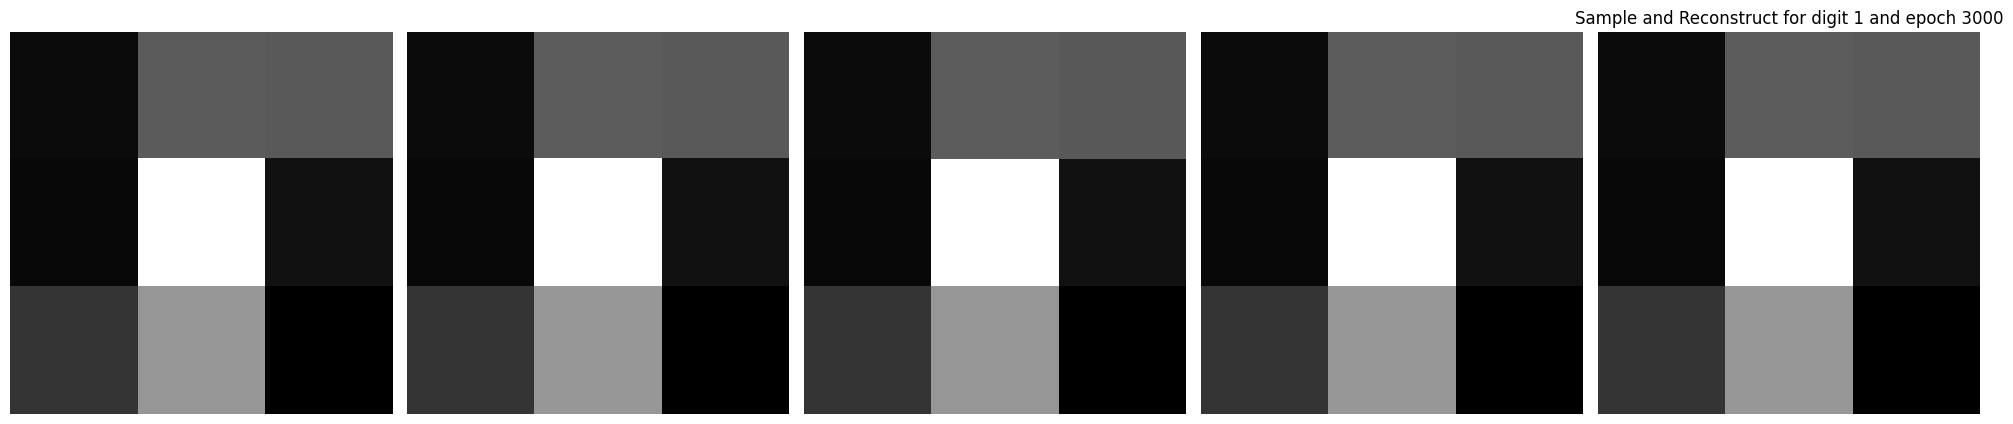

mean = tensor([10.6004, 10.8318,  9.9829,  9.9895, 11.8754,  9.9830, 10.6963,  9.3249,
        11.6036], dtype=torch.float64)
var = tensor([0.0003, 0.0001, 0.0003, 0.0002, 0.0002, 0.0001, 0.0002, 0.0003, 0.0002],
       dtype=torch.float64)
p = 0.0002878076986085228


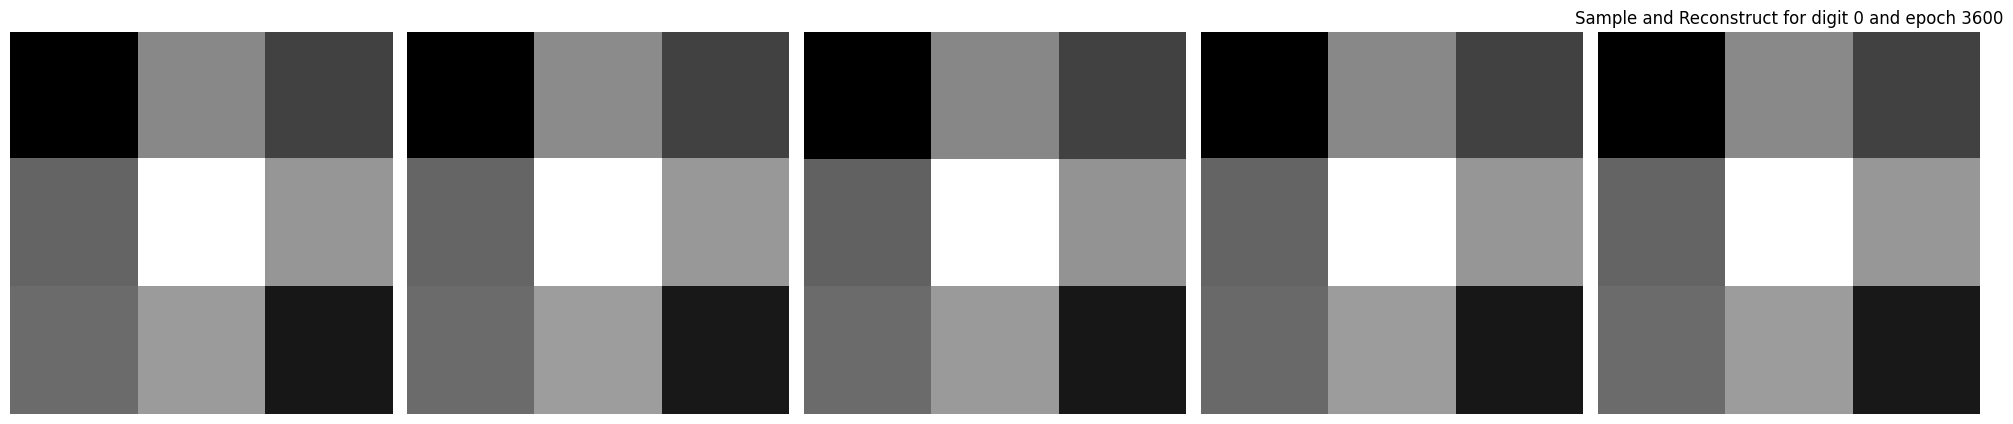

mean = tensor([10.5981, 10.8133,  9.9940,  9.9765, 11.8800,  9.9875, 10.7137,  9.3405,
        11.6067], dtype=torch.float64)
var = tensor([0.0002, 0.0004, 0.0003, 0.0002, 0.0002, 0.0001, 0.0002, 0.0003, 0.0004],
       dtype=torch.float64)
p = 0.6581274699878941


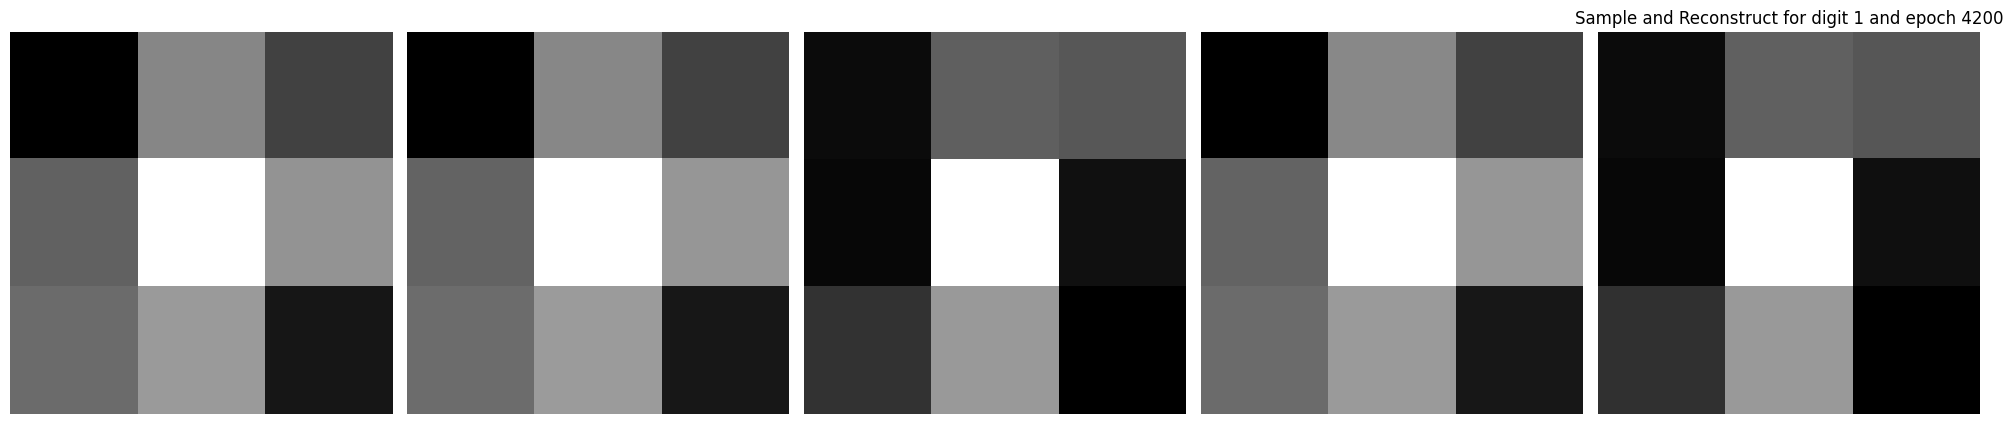

mean = tensor([10.6036, 10.8122, 10.0462,  9.9419, 11.9092,  9.9687, 10.7245,  9.3534,
        11.6057], dtype=torch.float64)
var = tensor([1.0129e-03, 4.3498e-05, 1.4536e-04, 3.5741e-05, 5.9219e-05, 7.0691e-05,
        8.6981e-05, 2.1742e-04, 1.0423e-04], dtype=torch.float64)
p = 0.5313730332727624


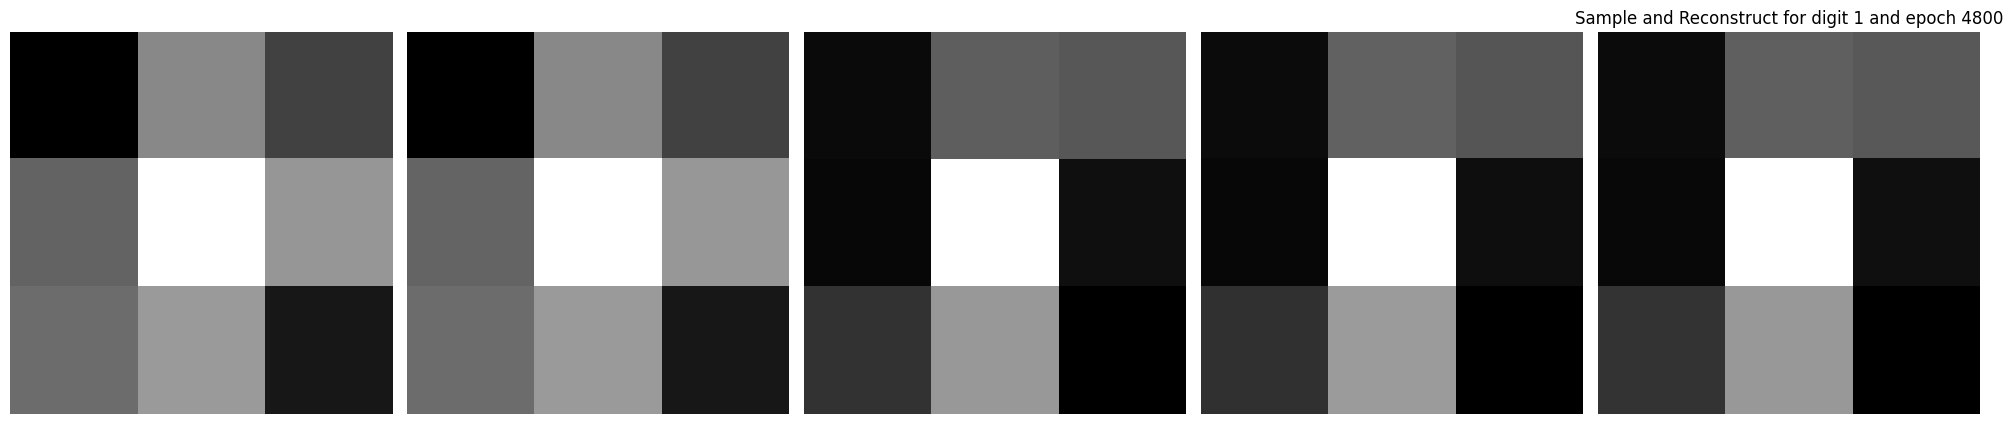

mean = tensor([10.6010, 10.8832, 10.0354,  9.9606, 11.9084,  9.9844, 10.7163,  9.3741,
        11.5936], dtype=torch.float64)
var = tensor([0.0005, 0.0004, 0.0012, 0.0002, 0.0003, 0.0003, 0.0015, 0.0002, 0.0007],
       dtype=torch.float64)
p = 0.9997583604291983


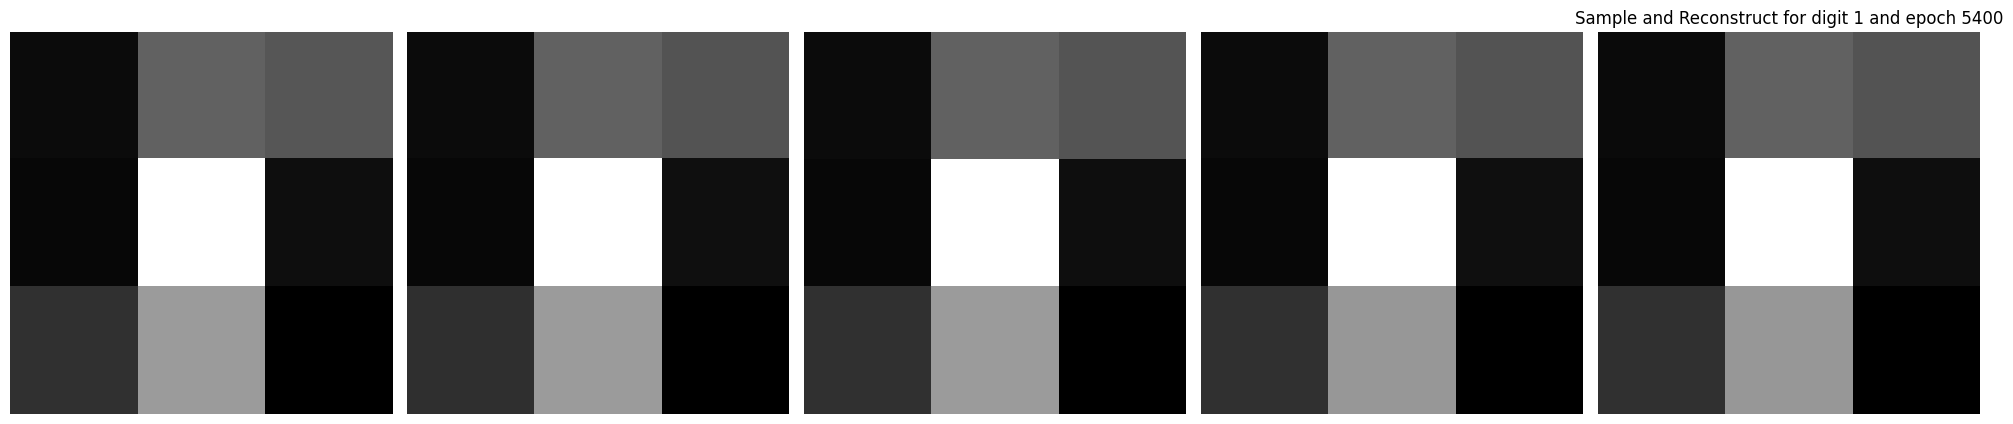

mean = tensor([10.5875, 10.9372, 10.0589,  9.9513, 11.8938, 10.0128, 10.6828,  9.3922,
        11.5677], dtype=torch.float64)
var = tensor([1.7904e-04, 5.0742e-04, 1.9450e-03, 1.2715e-04, 1.1208e-03, 8.1166e-05,
        5.3301e-04, 2.3510e-05, 1.7489e-05], dtype=torch.float64)
p = 0.6001083468113214


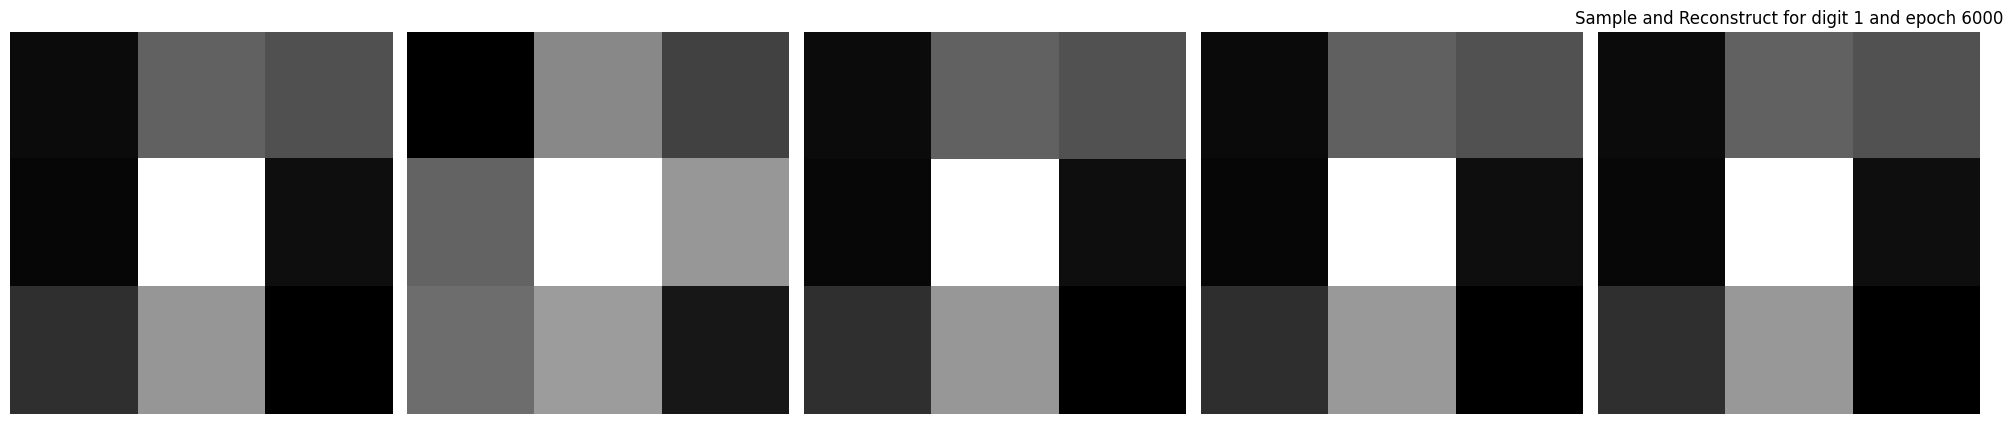

100%|██████████| 6000/6000 [04:26<00:00, 22.55it/s]


In [ ]:
from sklearn.utils import shuffle

# Move computation to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# initial guess 2.0
# init_guess = torch.tensor([7.0]*(dim) + [0.2], device=device) + torch.randn(dim + 1, device=device)
dim = 9
num_trajectories = 1
num_generations = 6000
num_1 = 200
num_0 = 200
n = num_0 + num_1

x_data_9 = shuffle(np.concatenate((final_0_9[:num_0], final_1_9[:num_1]), axis=0))
x_data_49 = shuffle(np.concatenate((final_0_49[:num_0], final_1_49[:num_1]), axis=0))

# Convert numpy arrays to torch tensors
final_var_9 = final_cov_9.diagonal()
mu_0_vals = [torch.tensor(final_mean_9, dtype=torch.float32, device=device)]
var_0_vals = [torch.tensor(final_var_9, dtype=torch.float32, device=device)]
p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

mnist_exp(x_data_9, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim, device, (avg_mean_9, diff_mean_9, final_mean_9), inv_0_9, inv_1_9, new_shape)

# repeat for 49
# dim_49 = 49
# final_var_49 = final_cov_49.diagonal()
# mu_0_vals = [torch.tensor(final_mean_49, dtype=torch.float32, device=device)]
# var_0_vals = [torch.tensor(final_var_49, dtype=torch.float32, device=device)]
# p_0_vals = [torch.tensor(num_1/(num_1 + num_0), dtype=torch.float32, device=device)]

# mnist_exp(x_data_49, mu_0_vals, var_0_vals, p_0_vals, n, num_trajectories, num_generations, dim_49, device, (avg_mean_49, diff_mean_49, final_mean_49), inv_0_49, inv_1_49, new_shape_2)